In [1]:
%matplotlib notebook

import numpy as np
from matplotlib import pyplot as plt
import math

import pandas as pd
import xarray as xr

import os
import qcodes as qc
from qcodes.dataset.data_set import DataSet, new_data_set
from qcodes.dataset.experiment_container import load_experiment_by_name, new_experiment
from qcodes.dataset.measurements import ParamSpec
from qcodes.dataset.sqlite_base import (connect, get_dependencies,
                                        get_dependents, get_layout, get_runs)

In [2]:
from scipy import constants
from scipy.interpolate import interp1d
from scipy.optimize import fmin
from scipy.integrate import cumtrapz
from scipy.optimize import curve_fit
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
from plottr.data.datadict import DataDict
from plottr.data.qcodes import DataSetDict

In [4]:
from qcodes.dataset.sqlite_base import transaction, one

# qc.config['core']['db_location'] = r"d:/OneDrive/BF1/Data/experiments_20180820.db"
qc.config['core']['db_location'] = r"d:/OneDrive/BF1/Data/experiments_20181011.db"

def get_timestamp(run_id):
    DB = qc.config["core"]["db_location"]
    
    d = DataSet(DB)
    sql = """
    SELECT run_timestamp
    FROM
      runs
    WHERE
      run_id= ?
    """
    c = transaction(d.conn, sql, run_id)
    run_timestamp = one(c, 'run_timestamp')
    return run_timestamp

def timestamp_to_fmt(ts, fmt):
    return time.strftime(fmt, time.gmtime(ts))

def img_basepath(run_id):
    ts = get_timestamp(run_id)
    return timestamp_to_fmt(ts, qc.config['user']['img_dir'] + str(run_id).zfill(4) + '_')

def ds_title(run_id):
    return "{} #{}".format(os.path.abspath(qc.config['core']['db_location']), run_id)

qc.config['user']['img_dir'] = "d:/data/images/%Y-%m/%Y-%m-%d/"
qc.config.save_to_cwd()

In [5]:
def centers2edges(arr):
    e = (arr[1:] + arr[:-1]) / 2.
    e = np.concatenate(([arr[0] - (e[0] - arr[0])], e))
    e = np.concatenate((e, [arr[-1] + (arr[-1] - e[-1])]))
    return e

def pcolorgrid(xaxis, yaxis):
    xedges = centers2edges(xaxis)
    yedges = centers2edges(yaxis)
    xx, yy = np.meshgrid(xedges, yedges)
    return xx, yy

def pcolormesh(ax, x, y, z, **kw):
    xx, yy = pcolorgrid(x, y)
    im = ax.pcolormesh(xx, yy, z, **kw)
    return im

# Old code

## Frequency sweeps

In [6]:
def res_fit(f, f0, q, smin, a):
    df = (f-f0)/f0
    s = a*((smin/a)+2j*q*df)/(1+2j*q*df)
    return abs(s)

### Frequency versus magnetic field

In [ ]:
run_id = 932
data = DataSetDict(run_id=run_id)
q = data.get_snapshot()

ret   = dict(data.get_grid('avgiq_detector_signal_abs'))
ret_r = dict(data.get_grid('avgiq_detector_signal_real'))
ret_i = dict(data.get_grid('avgiq_detector_signal_imag'))

mag  = ret['avgiq_detector_signal_abs'][:,:,0,1]
real = ret_r['avgiq_detector_signal_real'][:,:,0,1]
imag = ret_i['avgiq_detector_signal_imag'][:,:,0,1]

z = real+1j*imag
phi = np.angle(z, deg=1)

freq = ret['het_src_frequency']
B = ret['AMI430_field']

popt, pcov = curve_fit(res_fit, freq, mag[:,0], p0 = [4.44e8, 200, 0.045, 0.065])
# popt, pcov = curve_fit(res_fit, freq, mag[:,15], p0 = [4.43e8, 200, 0.045, 0.065])

fig = plt.figure(figsize=(8,5))

ax1 = plt.subplot(211)
ax2 = plt.subplot(223)
ax3 = plt.subplot(224)


im1 = ax1.plot(freq, mag[:,0])
ax1.plot(freq, res_fit(freq, *popt))
ax1.set_xlabel('freq (Hz)')
ax1.set_ylabel("abs (V)")


im2 = ax2.pcolor(freq, B, mag.T)
cb2 = fig.colorbar(im2, ax=ax2)
ax2.set_xlabel('freq (Hz)')
ax2.set_ylabel('field (T)')
cb2.set_label('abs (V)')

im3 = ax3.pcolor(freq, B, mag.T-mag[:,0])
cb2 = fig.colorbar(im3, ax=ax3)
ax3.set_xlabel('freq (Hz)')
ax3.set_ylabel('field (T)')
cb3.set_label('abs (V)')

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

In [ ]:
run_id = 932
data = DataSetDict(run_id=run_id)
q = data.get_snapshot()

ret   = dict(data.get_grid('avgiq_detector_signal_abs'))
ret_r = dict(data.get_grid('avgiq_detector_signal_real'))
ret_i = dict(data.get_grid('avgiq_detector_signal_imag'))

mag  = ret['avgiq_detector_signal_abs']['values'][:,:,0,1]
real = ret_r['avgiq_detector_signal_real']['values'][:,:,0,1]
imag = ret_i['avgiq_detector_signal_imag']['values'][:,:,0,1]

z = real+1j*imag
phi = np.angle(z, deg=1)

freq = ret['het_src_frequency']['values']
B = ret['AMI430_field']['values']

res = []
freq0 = []
Qres0 = []
fguess= 4.43e8
for i in range(B.size):
    popt, pcov = curve_fit(res_fit, freq, mag[:,i], p0 = [fguess, 200, 0.045, 0.065])
    fguess = popt[0]
    res.append([*popt])
    freq0.append(popt[0])
    Qres0.append(popt[1])

    
print(freq0)
print(B.size)
freq0 = np.array(freq0)
    
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,5))
ax1.plot(B, freq0, label = 'Z')
ax1.set_xlabel('field (T)')
ax1.set_ylabel(r'f$_0$ (Hz)')

ax2.plot(B, Qres0, label = 'Z')
# print(freq0[-1])
ax2.set_xlabel('field (T)')
ax2.set_ylabel(r'Q$_L$')


run_id = 937
data = DataSetDict(run_id=run_id)
q = data.get_snapshot()

ret   = dict(data.get_grid('avgiq_detector_signal_abs'))
ret_r = dict(data.get_grid('avgiq_detector_signal_real'))
ret_i = dict(data.get_grid('avgiq_detector_signal_imag'))

mag  = ret['avgiq_detector_signal_abs']['values'][:,:,0,1]
real = ret_r['avgiq_detector_signal_real']['values'][:,:,0,1]
imag = ret_i['avgiq_detector_signal_imag']['values'][:,:,0,1]

z = real+1j*imag
phi = np.angle(z, deg=1)

freq = ret['het_src_frequency']['values']
B = ret['AMI430_field']['values']

res = []
freq1 = []
Qres1 = []
fguess= 4.43e8
for i in range(B.size):
    popt, pcov = curve_fit(res_fit, freq, mag[:,i], p0 = [fguess, 200, 0.045, 0.065])
    fguess = popt[0]
    res.append([*popt])
    freq1.append(popt[0])
    Qres1.append(popt[1])


freq0 = np.array(freq0)
    
# fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,5))
ax1.plot(B, freq1, label = 'X')
ax1.set_xlabel('field (T)')
ax1.set_ylabel(r'f$_0$ (Hz)')

ax2.plot(B, Qres1, label = 'X')
# print(freq0[-1])
ax2.set_xlabel('field (T)')
ax2.set_ylabel(r'Q$_L$')

ax1.legend()
ax2.legend()

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

freq1[0]


freq

# B.size

In [ ]:
run_id = 932
data = DataSetDict(run_id=run_id)

ret   = dict(data.get_grid('avgiq_detector_signal_abs'))

mag  = ret['avgiq_detector_signal_abs']['values'][:,:,0,1]

mag

## Hard sweeps

### Diamond scan

In [ ]:
run_id = 1098

data = DataSetDict(run_id=run_id)

data.structure()

# q = data.get_snapshot()
# print("field " + str(q['station']['instruments']['AMI430']['parameters']['field']['value']) + " T")
# dac8 = q['station']['instruments']['ivvi']['parameters']['dac8']['value']
# dac10 = q['station']['instruments']['ivvi']['parameters']['dac10']['value']
# dac11 = q['station']['instruments']['ivvi']['parameters']['dac11']['value']
# print('T2 ' + str(dac10) + ' mV')
# print('T3 ' + str(dac8) + ' mV')
# print('T4 ' + str(dac11) + ' mV')

ret   = dict(data.get_grid('avgiq_detector_signal_abs'))
ret_r = dict(data.get_grid('avgiq_detector_signal_real'))
ret_i = dict(data.get_grid('avgiq_detector_signal_imag'))

mag  = ret['avgiq_detector_signal_abs'][:,:,1]
real = ret_r['avgiq_detector_signal_real'][:,:,1]
imag = ret_i['avgiq_detector_signal_imag'][:,:,1]

mag_ref  = ret['avgiq_detector_signal_abs'][:,:,0]
real_ref = ret_r['avgiq_detector_signal_real'][:,:,0]
imag_ref = ret_i['avgiq_detector_signal_imag'][:,:,0]

z = real+1j*imag
phi = np.angle(z, deg=1)

z_ref = real_ref+1j*imag_ref
phi_ref = np.angle(z_ref, deg=1)

r2 = np.flip(ret['awg_ramp_voltage_vals'],0)
bias = ret['ivvi_setup_dac4']*1e3

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
im1 = ax1.pcolor(bias, r2, ((phi-phi_ref)%360.0).T)
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("R2 (mV)")
cb1.set_label('phase (deg)')

im2 = ax2.pcolor(bias, r2, mag.T)
cb2 = fig.colorbar(im2, ax=ax2)
cb2.set_label('abs (V)')

im3 = ax3.pcolor(bias, r2, real.T)
cb3 = fig.colorbar(im3, ax=ax3)
ax3.set_xlabel('bias (mV)')
ax3.set_ylabel("R2 (mV)")
cb3.set_label('real (V)')

im4 = ax4.pcolor(bias, r2, imag.T)
cb4 = fig.colorbar(im4, ax=ax4)
ax4.set_xlabel('bias (mV)')
cb4.set_label('imag (V)')

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

### Charge stability diagram

In [ ]:
run_id = 1286

data = DataSetDict(run_id=run_id)

data.structure()

# q = data.get_snapshot()
# print("field " + str(q['station']['instruments']['AMI430']['parameters']['field']['value']) + " T")
# dac8 = q['station']['instruments']['ivvi']['parameters']['dac8']['value']
# dac10 = q['station']['instruments']['ivvi']['parameters']['dac10']['value']
# dac11 = q['station']['instruments']['ivvi']['parameters']['dac11']['value']
# print('T2 ' + str(dac10) + ' mV')
# print('T3 ' + str(dac8) + ' mV')
# print('T4 ' + str(dac11) + ' mV')

ret   = dict(data.get_grid('avgiq_detector_signal_abs'))
ret_r = dict(data.get_grid('avgiq_detector_signal_real'))
ret_i = dict(data.get_grid('avgiq_detector_signal_imag'))

mag  = ret['avgiq_detector_signal_abs'][:,:,1]
real = ret_r['avgiq_detector_signal_real'][:,:,1]
imag = ret_i['avgiq_detector_signal_imag'][:,:,1]

mag_ref  = ret['avgiq_detector_signal_abs'][:,:,0]
real_ref = ret_r['avgiq_detector_signal_real'][:,:,0]
imag_ref = ret_i['avgiq_detector_signal_imag'][:,:,0]

z = real+1j*imag
phi = np.angle(z, deg=1)

z_ref = real_ref+1j*imag_ref
phi_ref = np.angle(z_ref, deg=1)

r2 = np.flip(ret['awg_ramp_voltage_vals'],0)
# r2 = ret['awg_ramp_voltage_vals']
bias = ret['ivvi_setup_dac16']*1e3

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
im1 = ax1.pcolor(bias, r2, ((phi-phi_ref)%360.0).T)
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("R2 (mV)")
cb1.set_label('phase (deg)')

im2 = ax2.pcolor(bias, r2, mag.T)
cb2 = fig.colorbar(im2, ax=ax2)
cb2.set_label('abs (V)')

im3 = ax3.pcolor(bias, r2, real.T)
cb3 = fig.colorbar(im3, ax=ax3)
ax3.set_xlabel('G (mV)')
ax3.set_ylabel("R2 (mV)")
cb3.set_label('real (V)')

im4 = ax4.pcolor(bias, r2, imag.T)
cb4 = fig.colorbar(im4, ax=ax4)
ax4.set_xlabel('G (mV)')
cb4.set_label('imag (V)')

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

## RF diamond scan

In [ ]:
qc.config['core']['db_location'] = r"d:/OneDrive/BF1/Data/experiments.db"

run_id = 1031

data = DataSetDict(run_id=run_id)

q = data.get_snapshot()
print("field " + str(q['station']['instruments']['AMI430']['parameters']['field']['value']) + " T")
dac8 = q['station']['instruments']['ivvi']['parameters']['dac8']['value']
dac10 = q['station']['instruments']['ivvi']['parameters']['dac10']['value']
dac11 = q['station']['instruments']['ivvi']['parameters']['dac11']['value']
print('T2 ' + str(dac10) + ' mV')
print('T3 ' + str(dac8) + ' mV')
print('T4 ' + str(dac11) + ' mV')

ret  = dict(data.get_grid('avgiq_detector_signal_abs'))
mag  = ret['avgiq_detector_signal_abs']['values'][:,:,0,1]
r2   = ret['ivvi_setup_dac7']['values']*1e3
bias = ret['ivvi_setup_dac4']['values']*1e3

ret_r = dict(data.get_grid('avgiq_detector_signal_real'))
ret_i = dict(data.get_grid('avgiq_detector_signal_imag'))

real = ret_r['avgiq_detector_signal_real']['values'][:,:,0,1]
imag = ret_i['avgiq_detector_signal_imag']['values'][:,:,0,1]
real_ref = ret_r['avgiq_detector_signal_real']['values'][:,:,0,0]
imag_ref = ret_i['avgiq_detector_signal_imag']['values'][:,:,0,0]

z = real+1j*imag
phi = np.angle(z, deg=1)
z_ref = real_ref+1j*imag_ref
phi_ref = np.angle(z_ref, deg=1)
cphase = (phi-phi_ref+100)%360.0

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6, 2.5))

im1 = ax1.pcolor(r2, bias, cphase)
cb1 = fig.colorbar(im1, ax=ax1)
# ax1.axhline(y=0.16, color = "white")
# ax1.axhline(y=0.51, color = "white")
# ax1.axhline(y=-0.16, color = "white")
# ax1.axhline(y=-0.51, color = "white")
cb1.set_label('phase (deg)')
ax1.set_xlabel('R2 (mV)')
ax1.set_ylabel('Bias (mV)')
# ax1.set_xlim([0, 2])

im2 = ax2.pcolor(r2, bias, mag)
cb2 = fig.colorbar(im2, ax=ax2)
cb2.set_label('mag (V)')
ax2.set_xlabel('R2 (mV)')
# ax2.set_xlim([0, 2])

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

plt.figure()
plt.plot(bias, np.average(cphase, axis=1))

In [ ]:
run_id = 648

data = DataSetDict(run_id=run_id)
q = data.get_snapshot()
print("field " + str(q['station']['instruments']['AMI430']['parameters']['field']['value']) + " T")
dac8 = q['station']['instruments']['ivvi']['parameters']['dac8']['value']
dac10 = q['station']['instruments']['ivvi']['parameters']['dac10']['value']
dac11 = q['station']['instruments']['ivvi']['parameters']['dac11']['value']
print('T2 ' + str(dac10) + ' mV')
print('T3 ' + str(dac8) + ' mV')
print('T4 ' + str(dac11) + ' mV')

ret   = dict(data.get_grid('avgiq_detector_signal_abs'))
ret_r = dict(data.get_grid('avgiq_detector_signal_real'))
ret_i = dict(data.get_grid('avgiq_detector_signal_imag'))

mag  = ret['avgiq_detector_signal_abs'][:,:,0,1]
real = ret_r['avgiq_detector_signal_real'][:,:,0,1]
imag = ret_i['avgiq_detector_signal_imag'][:,:,0,1]

mag_ref  = ret['avgiq_detector_signal_abs'][:,:,0,0]
real_ref = ret_r['avgiq_detector_signal_real'][:,:,0,0]
imag_ref = ret_i['avgiq_detector_signal_imag'][:,:,0,0]


z = real+1j*imag
phi = np.angle(z, deg=1)

z_ref = real_ref+1j*imag_ref
phi_ref = np.angle(z_ref, deg=1)

r2 = np.flip(ret['ivvi_setup_dac7'],0)*1e3
bias = ret['ivvi_setup_dac4']*1e3

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
im1 = ax1.pcolor(bias, r2, ((phi-phi_ref)%360.0).T)
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("R2 (mV)")
cb1.set_label('phase (deg)')

im2 = ax2.pcolor(bias, r2, mag.T)
cb2 = fig.colorbar(im2, ax=ax2)
cb2.set_label('abs (V)')

im3 = ax3.pcolor(bias, r2, real.T)
cb3 = fig.colorbar(im3, ax=ax3)
ax3.set_xlabel('bias (mV)')
ax3.set_ylabel("R2 (mV)")
cb3.set_label('real (V)')

im4 = ax4.pcolor(bias, r2, imag.T)
cb4 = fig.colorbar(im4, ax=ax4)
ax4.set_xlabel('bias (mV)')
cb4.set_label('imag (V)')

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

## Gate sweep

In [ ]:
run_id = 1093

data = DataSetDict(run_id=run_id)
q = data.get_snapshot()
print("field " + str(q['station']['instruments']['AMI430']['parameters']['field']['value']) + " T")
dac8 = q['station']['instruments']['ivvi']['parameters']['dac8']['value']
dac10 = q['station']['instruments']['ivvi']['parameters']['dac10']['value']
dac11 = q['station']['instruments']['ivvi']['parameters']['dac11']['value']
print('T2 ' + str(dac10) + ' mV')
print('T3 ' + str(dac8) + ' mV')
print('T4 ' + str(dac11) + ' mV')

ret   = dict(data.get_grid('avgiq_detector_signal_abs'))
ret_r = dict(data.get_grid('avgiq_detector_signal_real'))
ret_i = dict(data.get_grid('avgiq_detector_signal_imag'))

mag  = ret['avgiq_detector_signal_abs'][:,0,1]
real = ret_r['avgiq_detector_signal_real'][:,0,1]
imag = ret_i['avgiq_detector_signal_imag'][:,0,1]

mag_ref  = ret['avgiq_detector_signal_abs'][:,0,0]
real_ref = ret_r['avgiq_detector_signal_real'][:,0,0]
imag_ref = ret_i['avgiq_detector_signal_imag'][:,0,0]


z = real+1j*imag
phi = np.angle(z, deg=1)

z_ref = real_ref+1j*imag_ref
phi_ref = np.angle(z_ref, deg=1)

r2 = np.flip(ret['ivvi_setup_dac7'],0)*1e3

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
im1 = ax1.plot(r2, ((phi-phi_ref)%360.0).T)
ax1.set_ylabel("R2 (mV)")

im2 = ax2.plot(r2, mag.T)

im3 = ax3.plot(r2, real.T)
ax3.set_xlabel('bias (mV)')
ax3.set_ylabel("R2 (mV)")


im4 = ax4.plot(r2, imag.T)
ax4.set_xlabel('bias (mV)')


fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

## RF Diamonds phase only

In [ ]:
run_id = 912
data = DataSetDict(run_id=run_id)

q = data.get_snapshot()

dac8 = q['station']['instruments']['ivvi']['parameters']['dac8']['value']
dac11 = q['station']['instruments']['ivvi']['parameters']['dac11']['value']
print('T3 ' + str(dac8) + ' mV')
print('T4 ' + str(dac11) + ' mV')

ret   = dict(data.get_grid('avgiq_detector_signal_abs'))
ret_r = dict(data.get_grid('avgiq_detector_signal_real'))
ret_i = dict(data.get_grid('avgiq_detector_signal_imag'))

mag  = ret['avgiq_detector_signal_abs'][:,:,0,1]
real = ret_r['avgiq_detector_signal_real'][:,:,0,1]
imag = ret_i['avgiq_detector_signal_imag'][:,:,0,1]

z = real+1j*imag
phi = np.angle(z, deg=1)

r2 = np.flip(ret['ivvi_setup_dac7'],0)*1e3

fig, ax1 = plt.subplots(1,1, figsize=(4,3))
im1 = ax1.pcolor(ret['ivvi_setup_dac4']*1e3, r2, ((phi+20)%360.0).T)
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("R2 (mV)")
ax1.set_xlabel('bias (mV)')
cb1.set_label('phase (deg)')


fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

## RF charge stability diagram

In [ ]:
run_id = 938
data = DataSetDict(run_id=run_id)
q = data.get_snapshot()
print("field " + str(q['station']['instruments']['AMI430']['parameters']['field']['value']) + " T")
dac8 = q['station']['instruments']['ivvi']['parameters']['dac8']['value']
dac10 = q['station']['instruments']['ivvi']['parameters']['dac10']['value']
dac11 = q['station']['instruments']['ivvi']['parameters']['dac11']['value']
print('T2 ' + str(dac10) + ' mV')
print('T3 ' + str(dac8) + ' mV')
print('T4 ' + str(dac11) + ' mV')

ret   = dict(data.get_grid('avgiq_detector_signal_abs'))
ret_r = dict(data.get_grid('avgiq_detector_signal_real'))
ret_i = dict(data.get_grid('avgiq_detector_signal_imag'))

mag  = ret['avgiq_detector_signal_abs'][:,:,0,1]
real = ret_r['avgiq_detector_signal_real'][:,:,0,1]
imag = ret_i['avgiq_detector_signal_imag'][:,:,0,1]

z = real+1j*imag
phi = np.angle(z, deg=1)

r2 = np.flip(ret['ivvi_setup_dac7'],0)*1e3
G = ret['ivvi_setup_dac16']*1e3

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
im1 = ax1.pcolor(G, r2, (phi%360.0).T)
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("R2 (mV)")
cb1.set_label('phase (deg)')

im2 = ax2.pcolor(G, r2, mag.T)
cb2 = fig.colorbar(im2, ax=ax2)
cb2.set_label('abs (V)')

im3 = ax3.pcolor(G, r2, real.T)
cb3 = fig.colorbar(im3, ax=ax3)
ax3.set_xlabel('G (mV)')
ax3.set_ylabel("R2 (mV)")
cb3.set_label('real (V)')

im4 = ax4.pcolor(G, r2, imag.T)
cb4 = fig.colorbar(im4, ax=ax4)
ax4.set_xlabel('G (mV)')
cb4.set_label('imag (V)')

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

## RF CSD only phase

In [ ]:
qc.config['core']['db_location'] = r"d:/OneDrive/BF1/Data/experiments.db"
run_id = 805
data = DataSetDict(run_id=run_id)

q = data.get_snapshot()

dac8 = q['station']['instruments']['ivvi']['parameters']['dac8']['value']
dac11 = q['station']['instruments']['ivvi']['parameters']['dac11']['value']
print('T3 ' + str(dac8) + ' mV')
# print('T4 ' + str(dac11) + ' mV')

ret   = dict(data.get_grid('avgiq_detector_signal_abs'))
ret_r = dict(data.get_grid('avgiq_detector_signal_real'))
ret_i = dict(data.get_grid('avgiq_detector_signal_imag'))

mag  = ret['avgiq_detector_signal_abs'][:,:,0,1]
real = ret_r['avgiq_detector_signal_real'][:,:,0,1]
imag = ret_i['avgiq_detector_signal_imag'][:,:,0,1]

z = real+1j*imag
phi = np.angle(z, deg=1)

r2 = np.flip(ret['ivvi_setup_dac7'],0)*1e3

fig, ax1 = plt.subplots(1,1, figsize=(4,3))
im1 = ax1.pcolor(ret['ivvi_setup_dac16']*1e3, r2, (phi%360.0).T)
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("R2 (mV)")
ax1.set_xlabel('G (mV)')
cb1.set_label('phase (deg)')


fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

## Field alignment

### gap measurement

In [ ]:
run_id = 889
data = DataSetDict(run_id=run_id)

q = data.get_snapshot()
dac8 = q['station']['instruments']['ivvi']['parameters']['dac8']['value']
dac15 = q['station']['instruments']['ivvi']['parameters']['dac15']['value']
print(dac8, dac15)

ret = dict(data.get_grid('ivvi_setup_g_measurement'))
gate = ret['ivvi_setup_dac15']*1e3
bias = ret['ivvi_setup_dac4']*1e3

gate_cut = -755
cut_idx  = np.argmin(abs(gate - gate_cut))

fig, ax1 = plt.subplots(1,1)
im1 = ax1.pcolor(gate, bias, ret['ivvi_setup_g_measurement'].T)
cb1 = fig.colorbar(im1, ax=ax1)
# ax1.axhline(y=gate_cut)
ax1.set_ylabel("T1 (mV)")
ax1.set_xlabel('Vbias (mV)')
cb1.set_label(r'g (2e$^2$/h)')

# ax2.plot(bias, ret['ivvi_setup_g_measurement'][cut_idx,:], label='T3 = ' + str(gate_cut) + 'mV')
# ax2.set_ylabel(r'g (2e$^2$/h)')
# ax2.set_xlabel(r"Vbias (mV)")
# ax2.legend()

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

### Theta versus bias

In [ ]:
run_id = 880
data = DataSetDict(run_id=run_id)

print(ret.keys())

ret = dict(data.get_grid('ivvi_setup_g_measurement'))
theta = ret['AMI430_theta']
bias = ret['ivvi_setup_dac4']*1e3

# gate_cut = -312
# cut_idx  = np.argmin(abs(gate - gate_cut))

fig, ax1 = plt.subplots(1,1)
im1 = ax1.pcolor(theta, bias, ret['ivvi_setup_g_measurement'].T)
cb1 = fig.colorbar(im1, ax=ax1)
# ax1.axhline(y=gate_cut)
ax1.set_ylabel("Vbias (mV)")
ax1.set_xlabel('Theta (deg)')
cb1.set_label(r'g (2e$^2$/h)')

# ax2.plot(bias, ret['ivvi_setup_g_measurement'][cut_idx,:], label='T3 = ' + str(gate_cut) + 'mV')
# ax2.set_ylabel(r'g (2e$^2$/h)')
# ax2.set_xlabel(r"Vbias (mV)")
# ax2.legend()

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

### Field versus bias

In [ ]:
run_id = 884
data = DataSetDict(run_id=run_id)

print(ret.keys())

ret = dict(data.get_grid('ivvi_setup_g_measurement'))
field = ret['AMI430_field']
bias = ret['ivvi_setup_dac4']*1e3

# gate_cut = -312
# cut_idx  = np.argmin(abs(gate - gate_cut))

fig, ax1 = plt.subplots(1,1)
im1 = ax1.pcolor(field, bias, ret['ivvi_setup_g_measurement'].T)
cb1 = fig.colorbar(im1, ax=ax1)
# ax1.axhline(y=gate_cut)
ax1.set_ylabel("Vbias (mV)")
ax1.set_xlabel('Field (T)')
cb1.set_label(r'g (2e$^2$/h)')

# ax2.plot(bias, ret['ivvi_setup_g_measurement'][cut_idx,:], label='T3 = ' + str(gate_cut) + 'mV')
# ax2.set_ylabel(r'g (2e$^2$/h)')
# ax2.set_xlabel(r"Vbias (mV)")
# ax2.legend()

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

## Gate versus gate

### G vs T

In [ ]:
run_id = 946
data = DataSetDict(run_id=run_id)

q = data.get_snapshot()
dac8 = q['station']['instruments']['ivvi']['parameters']['dac8']['value']
dac15 = q['station']['instruments']['ivvi']['parameters']['dac15']['value']
print(dac8, dac15)

ret = dict(data.get_grid('ivvi_setup_i_measurement'))
gate = ret['ivvi_setup_dac15']*1e3
T2 = ret['ivvi_setup_dac8']*1e3

fig, ax1 = plt.subplots(1,1)
im1 = ax1.pcolor(gate, T2, ret['ivvi_setup_i_measurement'])
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("G (mV)")
ax1.set_xlabel('T3 (mV)')
cb1.set_label(r'g (2e$^2$/h)')


fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

### T vs T

In [ ]:
qc.config['core']['db_location'] = r"d:/OneDrive/BF1/Data/experiments.db"

run_id = 2309
data = DataSetDict(run_id=run_id)

# print(data.structure)


ret = dict(data.get_grid('ivvi_setup_i_measurement'))
T3 = ret['ivvi_setup_dac8']['values']*1e3
T4 = ret['ivvi_setup_dac11']['values']*1e3

fig, ax1 = plt.subplots(1,1)
im1 = ax1.pcolor(T3, T4, ret['ivvi_setup_i_measurement']['values'].T)
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("T3 (mV)")
ax1.set_xlabel('T4 (mV)')
cb1.set_label(r'I (nA)')


fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

# T3.min()

In [ ]:
run_id = 902
data = DataSetDict(run_id=run_id)

q = data.get_snapshot()
dac8 = q['station']['instruments']['ivvi']['parameters']['dac8']['value']
dac11 = q['station']['instruments']['ivvi']['parameters']['dac11']['value']
print(dac8, dac11)

ret = dict(data.get_grid('ivvi_setup_i_measurement'))
T3 = ret['ivvi_setup_dac8']*1e3
T4 = ret['ivvi_setup_dac11']*1e3

tunnel4 = [-400, -450]
tunnel3 = np.linspace(-400,-300,6)

fig, ax1 = plt.subplots(1,1)
im1 = ax1.pcolor(T3, T4, ret['ivvi_setup_i_measurement'].T)
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("T3 (mV)")
ax1.set_xlabel('T4 (mV)')
cb1.set_label(r'I (nA)')

for t3 in tunnel3:
    for t4 in tunnel4:
        ax1.plot(t3, t4, 'wo')
    

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

# Example plot

In [ ]:
data = DataSetDict(run_id=run_id)
ret = dict(data.get_grid('z'))

fig, ax = plt.subplots(1,1)
im = pcolormesh(ax, ret['x'], ret['y'], ret['z'].T)
cb = fig.colorbar(im)
ax.set_xlabel(data.label('x'))
ax.set_ylabel(data.label('y'))
cb.set_label(data.label('z'))

In [ ]:
data = DataSetDict(run_id=1132)

In [ ]:
data.structure()

In [ ]:
ret = dict(data.get_grid('lockin1_X'))

In [ ]:
g = ret["lockin1_X"]["values"]
bias = ret["ivvi_setup_SD_voltage"]["values"]
gate = ret["ivvi_setup_G_fine_voltage"]["values"]

In [ ]:
g

In [ ]:
fig, ax1 = plt.subplots(1,1)
im1 = ax1.pcolor(bias, gate, g.T)

In [ ]:
data = DataSetDict(run_id=1326)

ret = dict(data.get_grid('lockin1_X'))

X = ret["lockin1_X"]["values"]
G = ret["ivvi_setup_G_fine_voltage"]["values"]
R2 = ret["ivvi_setup_R2_voltage"]["values"]

gain = 1e7
dV = 10e-6
r_series = 13.4e3

g = 12906/((gain*dV/X)-r_series)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

im1 = ax1.pcolor(R2*1e3, G*1e3, X.T*1e3)
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("G (mV)")
ax1.set_xlabel('R2 (mV)')
cb1.set_label('X (mV)')

im2 = ax2.pcolor(R2*1e3, G*1e3, g.T,)
cb2 = fig.colorbar(im2, ax=ax2)
ax2.set_ylabel("G (mV)")
ax2.set_xlabel('R2 (mV)')
cb2.set_label(r'g (2e$^2$/h)')

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

In [ ]:
q = data.get_snapshot()
T2 = q['station']['instruments']['ivvi_setup']['parameters']['T2_voltage']['value']
T3 = q['station']['instruments']['ivvi_setup']['parameters']['T3_voltage']['value']
T4 = q['station']['instruments']['ivvi_setup']['parameters']['T4_voltage']['value']

print(T2, T3, T4)

In [ ]:
I[0]

In [ ]:
run_id = 247
data = DataSetDict(run_id=run_id)

ret = dict(data.get_grid('ivvi_setup_SD_current'))
T4 = ret['ivvi_setup_T4_voltage']['values']*1e3
I = ret['ivvi_setup_SD_current']['values']*1e9

# run_id = 139
# datafw = DataSetDict(run_id=run_id)

# ret_fw = dict(datafw.get_grid('ivvi_setup_SD_current'))
# r2c_fw = ret_fw['ivvi_setup_R2_coarse_voltage']['values']*1e3
# I_fw = ret_fw['ivvi_setup_SD_current']['values']*1e9


fig, ax1 = plt.subplots(1,1)
im1 = ax1.plot(T4, I)
# im1 = ax1.plot(r2c_fw, I_fw)
ax1.set_xlabel("T4 (mV)")
ax1.set_ylabel("I (nA)")

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()


## Gate versus gate

### T2 vs T4

In [ ]:
400/600

In [ ]:
qc.config['core']['db_location'] = r"d:/OneDrive/BF1/Data/experiments.db"

run_id = 2309
data = DataSetDict(run_id=run_id)

ret = dict(data.get_grid('ivvi_setup_SD_current'))
T2 = ret['ivvi_setup_T2_voltage']['values']*1e3
T4 = ret['ivvi_setup_T4_voltage']['values']*1e3
I = ret['ivvi_setup_SD_current']['values']*1e9

tunnel4 = [-400, -450]
tunnel3 = np.linspace(-400,-300,6)

fig, ax1 = plt.subplots(1,1)
im1 = ax1.pcolor(T2, T4, I)
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("T4 (mV)")
ax1.set_xlabel('T2 (mV)')
cb1.set_label(r'I (nA)')

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()


### T2 vs T3

In [ ]:
run_id = 2309

data = DataSetDict(run_id=run_id)

ret = dict(data.get_grid('ivvi_setup_SD_current'))
T4 = ret['ivvi_setup_T4_voltage']['values']*1e3
T3 = ret['ivvi_setup_T3_voltage']['values']*1e3
I = ret['ivvi_setup_SD_current']['values']*1e9


fig, ax1 = plt.subplots(1,1, figsize=(5,4))
im1 = ax1.pcolor(T3, T4, I)
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("T4 (mV)")
ax1.set_xlabel('T3 (mV)')
cb1.set_label(r'I (nA)')
ax1.set_xlim([-500, -350])
ax1.set_ylim([-400, -300])

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()


In [ ]:
run_id = 2627

data = DataSetDict(run_id=run_id)

ret = dict(data.get_grid('ivvi_setup_SD_current'))
T4 = ret['ivvi_setup_G_coarse_voltage']['values']*1e3
T3 = ret['ivvi_setup_T2_voltage']['values']*1e3
I = ret['ivvi_setup_SD_current']['values']*1e9


fig, ax1 = plt.subplots(1,1)
im1 = ax1.pcolor(T4, T3, I.T)
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("T2 (mV)")
ax1.set_xlabel('G (mV)')
cb1.set_label(r'I (nA)')

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()


In [ ]:
run_id = 2338

data = DataSetDict(run_id=run_id)

ret = dict(data.get_grid('ivvi_setup_SD_current'))
T4 = ret['ivvi_setup_T4_voltage']['values']*1e3
T1 = ret['ivvi_setup_T1_voltage']['values']*1e3
I = ret['ivvi_setup_SD_current']['values']*1e9


q = data.get_snapshot()

T2 = q['station']['instruments']['ivvi_setup']['parameters']['T2_voltage']['value']
T3 = q['station']['instruments']['ivvi_setup']['parameters']['T3_voltage']['value']
print(T2, T3)


fig, ax1 = plt.subplots(1,1)
im1 = ax1.pcolor(T1, T4, I.T)
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("T4 (mV)")
ax1.set_xlabel('T1 (mV)')
cb1.set_label(r'I (nA)')

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()


In [ ]:
run_id = 2341

data = DataSetDict(run_id=run_id)

ret = dict(data.get_grid('ivvi_setup_SD_current'))
T3 = ret['ivvi_setup_T3_voltage']['values']*1e3
T2 = ret['ivvi_setup_T2_voltage']['values']*1e3
I = ret['ivvi_setup_SD_current']['values']*1e9




fig, ax1 = plt.subplots(1,1)
im1 = ax1.pcolor(T3, T2, I.T)
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("T2 (mV)")
ax1.set_xlabel('T3 (mV)')
cb1.set_label(r'I (nA)')

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()


<IPython.core.display.Javascript object>


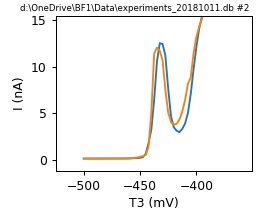

In [73]:
qc.config['core']['db_location'] = r"d:/OneDrive/BF1/Data/experiments_20180916.db"

run_id = 909
data = DataSetDict(run_id=run_id)
ret = dict(data.get_grid('ivvi_setup_SD_current'))
T3 = ret['ivvi_setup_T3_voltage']['values']*1e3
I = ret['ivvi_setup_SD_current']['values']*1e9

fig, ax1 = plt.subplots(1,1, figsize=(3,2.5))

ax1.plot(T3, I)
ax1.set_xlabel('T3 (mV)')
ax1.set_ylabel('I (nA)')

qc.config['core']['db_location'] = r"d:/OneDrive/BF1/Data/experiments_20181011.db"

run_id = 2
data = DataSetDict(run_id=run_id)
ret = dict(data.get_grid('ivvi_setup_SD_current'))
T3 = ret['ivvi_setup_T3_voltage']['values']*1e3
I = ret['ivvi_setup_SD_current']['values']*1e9

ax1.plot(T3, I)

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()


## DC diamond scans

In [ ]:
run_id = 134
data = DataSetDict(run_id=run_id)

ret = dict(data.get_grid('ivvi_setup_SD_conductance'))
# x1 = ret['ivvi_setup_R1_voltage']['values']*1e3
x1 = ret['ivvi_setup_SD_voltage']['values']*1e3
y1 = -ret['ivvi_setup_SD_conductance']['values']


fig, ax1 = plt.subplots(1,1)
im1 = ax1.plot(x1, y1)
# ax1.plot(x2, y2)
# cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("SD (mV)")
ax1.set_xlabel('R2 (mV)')
# cb1.set_label(r'g (2e$^2$/h)')

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()


In [ ]:
x = [x1,x2]
y = [y1, y2]
fig, ax1 = plt.subplots(1,1, figsize=(6,5))
for i in range(len(x)):
    xt = x[i]
    zt = y[i]

    xfit = np.linspace(min(xt), max(xt), 1001)

    maxtab, mintab = peakdet(zt, 0.01, xt)
    xp = array(maxtab)[1:,0]
    yp = array(maxtab)[1:,1]


    guess = []
    bound_min = []
    bound_max = []
    for i in range(len(xp)):
        guess += [xp[i], 0.05, 0.1] 
        bound_min += [min(xt), 0, 0] 
        bound_max += [max(xt), 2, 2] 
    try:
        popt, pcov = curve_fit(fitfunc, xt, zt, p0=guess, bounds=(bound_min, bound_max))
    except:
        popt, pcov = curve_fit(fitfunc, xt, zt, p0=guess2, bounds=(bound_min, bound_max))

    fit = fitfunc(xfit, *popt)
    print(np.average(popt[2::3])*1e3)
    print(np.average(popt[2::3])*1e3*0.72)
    guess2 = popt

# maxtab, mintab = peakdet(fit, 1, xfit)
# xp = array(maxtab)[1::,0]
# yp = array(maxtab)[1::,1]

# D.append(xp)
# X.append(np.diff(xp))



    ax1.plot(xt, zt)
#     ax1.plot(xp, yp, 'o')
    ax1.plot(xfit, fit)
    

    ax1.set_xlabel('R1 (mV)')
    ax1.set_ylabel(r'g (2e$^2$/h)')

ax1.legend(["HEMT off data", "HEMT off fit", "HEMT on data", "HEMT on fit"])

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()




In [ ]:
run_id = 34
data = DataSetDict(run_id=run_id)

ret = dict(data.get_grid('ivvi_setup_SD_conductance'))
x1 = ret['ivvi_setup_R2_voltage']['values']*1e3
# SD = ret['ivvi_setup_SD_voltage']['values']*1e3
y1 = -ret['ivvi_setup_SD_conductance']['values']

run_id = 48
data = DataSetDict(run_id=run_id)

ret = dict(data.get_grid('ivvi_setup_SD_conductance'))
x2 = ret['ivvi_setup_R2_voltage']['values']*1e3
# SD = ret['ivvi_setup_SD_voltage']['values']*1e3
y2 = -ret['ivvi_setup_SD_conductance']['values']

fig, ax1 = plt.subplots(1,1)
im1 = ax1.plot(x1, y1)
ax1.plot(x2, y2)
# cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("SD (mV)")
ax1.set_xlabel('R2 (mV)')
# cb1.set_label(r'g (2e$^2$/h)')

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()


In [ ]:
x = [x1,x2]
y = [y1, y2]
fig, ax1 = plt.subplots(1,1, figsize=(6,5))
for i in range(len(x)):
    xt = x[i]
    zt = y[i]

    xfit = np.linspace(min(xt), max(xt), 1001)

    maxtab, mintab = peakdet(zt, 0.003, xt)
    xp = array(maxtab)[:,0]
    yp = array(maxtab)[:,1]


    guess = []
    bound_min = []
    bound_max = []
    for i in range(len(xp)):
        guess += [xp[i], 0.1, 0.1] 
        bound_min += [min(xt), 0, 0] 
        bound_max += [max(xt), 2, 2] 
    try:
        popt, pcov = curve_fit(fitfunc, xt, zt, p0=guess, bounds=(bound_min, bound_max))
    except:
        popt, pcov = curve_fit(fitfunc, xt, zt, p0=guess2, bounds=(bound_min, bound_max))

    fit = fitfunc(xfit, *popt)
    print(np.average(popt[2::3])*1e3)
    print(np.average(popt[2::3])*1e3*0.72)
# guess2 = popt

# maxtab, mintab = peakdet(fit, 1, xfit)
# xp = array(maxtab)[1::,0]
# yp = array(maxtab)[1::,1]

# D.append(xp)
# X.append(np.diff(xp))



    ax1.plot(xt, zt)
    ax1.plot(xfit, fit)
    

    ax1.set_xlabel('R2 (mV)')
    ax1.set_ylabel(r'g (2e$^2$/h)')

ax1.legend(["HEMT off data", "HEMT off fit", "HEMT on data", "HEMT on fit"])

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()




In [ ]:
k = 86
T= 50e-3
print(71e3/(3.5*k))

In [ ]:
run_id = 244
data = DataSetDict(run_id=run_id)

ret = dict(data.get_grid('ivvi_setup_SD_conductance'))
x1 = ret['ivvi_setup_G_fine_voltage']['values']*1e3
# SD = ret['ivvi_setup_SD_voltage']['values']*1e3
y1 = -ret['ivvi_setup_SD_conductance']['values']

run_id = 244
data = DataSetDict(run_id=run_id)

ret = dict(data.get_grid('ivvi_setup_SD_conductance'))
x2 = ret['ivvi_setup_G_fine_voltage']['values']*1e3
# SD = ret['ivvi_setup_SD_voltage']['values']*1e3
y2 = -ret['ivvi_setup_SD_conductance']['values']

fig, ax1 = plt.subplots(1,1)
im1 = ax1.plot(x1, y1)
ax1.plot(x2, y2)
# cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("SD (mV)")
ax1.set_xlabel('G (mV)')
# cb1.set_label(r'g (2e$^2$/h)')

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()



In [ ]:
1.703/4

In [ ]:
x = [x1,x2]
y = [y1, y2]
fig, ax1 = plt.subplots(1,1, figsize=(6,5))
for i in range(len(x)):
    xt = x[i]
    zt = y[i]

    xfit = np.linspace(min(xt), max(xt), 1001)

    maxtab, mintab = peakdet(zt, 0.003, xt)
    xp = array(maxtab)[:,0]
    yp = array(maxtab)[:,1]


    guess = []
    bound_min = []
    bound_max = []
    for i in range(len(xp)):
        guess += [xp[i], 0.1, 0.1] 
        bound_min += [min(xt), 0, 0] 
        bound_max += [max(xt), 2, 2] 
    try:
        popt, pcov = curve_fit(fitfunc, xt, zt, p0=guess, bounds=(bound_min, bound_max))
    except:
        popt, pcov = curve_fit(fitfunc, xt, zt, p0=guess2, bounds=(bound_min, bound_max))

    fit = fitfunc(xfit, *popt)
    print(np.average(popt[2::3])*1e3)
    print(np.average(popt[2::3])*1e3*0.72)
# guess2 = popt

# maxtab, mintab = peakdet(fit, 1, xfit)
# xp = array(maxtab)[1::,0]
# yp = array(maxtab)[1::,1]

# D.append(xp)
# X.append(np.diff(xp))



    ax1.plot(xt, zt)
    ax1.plot(xfit, fit)
    

    ax1.set_xlabel('R2 (mV)')
    ax1.set_ylabel(r'g (2e$^2$/h)')

ax1.legend(["HEMT off data", "HEMT off fit", "HEMT on data", "HEMT on fit"])

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()




### bias vs field

In [ ]:
np.linspace(-0.4,-0.5,21)

In [ ]:
qc.config['core']['db_location'] = r"d:/OneDrive/BF1/Data/experiments_20180916.db"

run_id = 213
data = DataSetDict(run_id=run_id)

ret = dict(data.get_grid('ivvi_setup_SD_conductance'))
B = ret['AMI430_field']['values']*1e3
SD = ret['ivvi_setup_SD_voltage']['values']*1e3
g = ret['ivvi_setup_SD_conductance']['values']


q = data.get_snapshot()
Gfine = q['station']['instruments']['ivvi_setup']['parameters']['G_coarse_voltage']['value']
T1 = q['station']['instruments']['ivvi_setup']['parameters']['T1_voltage']['value']
T2 = q['station']['instruments']['ivvi_setup']['parameters']['T2_voltage']['value']
T3 = q['station']['instruments']['ivvi_setup']['parameters']['T3_voltage']['value']
T4 = q['station']['instruments']['ivvi_setup']['parameters']['T4_voltage']['value']
print(Gfine)
print(T1, T2, T3, T4)

fig, ax1 = plt.subplots(1,1, figsize=(4,2.5))

im1 = ax1.pcolor(B, SD, -1*g.T)
im1 = ax1.pcolor(B, SD, -1*g.T, vmax = 0.0075)
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("SD (mV)")
ax1.set_xlabel('B (mT)')
cb1.set_label(r'g (2e$^2$/h)')

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()




In [ ]:
qc.config['core']['db_location'] = r"d:/OneDrive/BF1/Data/experiments_20180916.db"
run_id = 217
data = DataSetDict(run_id=run_id)

ret = dict(data.get_grid('ivvi_setup_SD_conductance'))
G = ret['ivvi_setup_G_coarse_voltage']['values']*1e3
SD = ret['ivvi_setup_SD_voltage']['values']*1e3
g = ret['ivvi_setup_SD_conductance']['values']

g = -1*g

g_cut = g[0,:]

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (6,2.5))
im1 = ax1.pcolor(G, SD, g.T)
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("SD (mV)")
ax1.set_xlabel('G (mV)')
cb1.set_label(r'g (2e$^2$/h)')

ax2.plot(SD, g_cut)

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()



In [ ]:
run_id = 146
data = DataSetDict(run_id=run_id)

ret = dict(data.get_grid('ivvi_setup_SD_conductance'))
B = ret['ivvi_setup_G_coarse_voltage']['values']*1e3
SD = ret['ivvi_setup_SD_voltage']['values']*1e3
g = ret['ivvi_setup_SD_conductance']['values']

tunnel4 = [-400, -450]
tunnel3 = np.linspace(-400,-300,6)

fig, ax1 = plt.subplots(1,1)
im1 = ax1.pcolor(B, SD, -1*g.T, vmax=0.05)
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("SD (mV)")
ax1.set_xlabel('G (mV)')
cb1.set_label(r'g (2e$^2$/h)')

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()




In [ ]:
# qc.config['core']['db_location'] = r"d:/OneDrive/BF1/Data/experiments.db"

run_id = 240
data = DataSetDict(run_id=run_id)

ret = dict(data.get_grid('ivvi_setup_SD_conductance'))
R2 = ret['ivvi_setup_R2_voltage']['values']*1e3
SD = ret['ivvi_setup_SD_voltage']['values']*1e3
i = -ret['ivvi_setup_SD_conductance']['values']

q = data.get_snapshot()
Gfine = q['station']['instruments']['ivvi_setup']['parameters']['G_fine_voltage']['value']*1e6
T1 = q['station']['instruments']['ivvi_setup']['parameters']['T1_voltage']['value']
T2 = q['station']['instruments']['ivvi_setup']['parameters']['T2_voltage']['value']
T3 = q['station']['instruments']['ivvi_setup']['parameters']['T3_voltage']['value']
T4 = q['station']['instruments']['ivvi_setup']['parameters']['T4_voltage']['value']
print(Gfine)
print(T1, T2, T3, T4)

fig, (ax1) = plt.subplots(1,1, figsize = (6,5))
im1 = ax1.pcolor(R2, SD[1:], i[:,1:].T)
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("SD (mV)")
ax1.set_xlabel('R2 (mV)')
cb1.set_label(r'g (2e$^2$/h)')

# ax2.plot(SD, i[10,:])

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()


In [ ]:
352/505


In [ ]:
run_id = 233
data = DataSetDict(run_id=run_id)

ret = dict(data.get_grid('ivvi_setup_SD_conductance'))
R2 = ret['ivvi_setup_G_fine_voltage']['values']*1e3
SD = ret['ivvi_setup_SD_voltage']['values']*1e3
i = -ret['ivvi_setup_SD_conductance']['values']


fig, (ax1, ax2) = plt.subplots(1,2, figsize = (6,2.5))
im1 = ax1.pcolor(R2, SD[1:], i[:,1:].T, )
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("SD (mV)")
ax1.set_xlabel('G (mV)')
ax1.set_ylim([-0.5, 0.5])
cb1.set_label(r'g (2e$^2$/h)')

ax2.plot(i[:,17])

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()


In [319]:
346*0.45

155.70000000000002

<IPython.core.display.Javascript object>


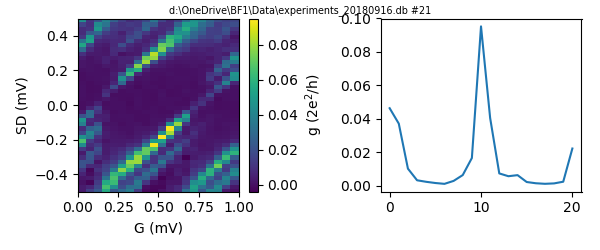

In [317]:
run_id = 21
data = DataSetDict(run_id=run_id)

ret = dict(data.get_grid('ivvi_setup_SD_conductance'))
R2 = ret['ivvi_setup_R2_voltage']['values']*1e3
SD = ret['ivvi_setup_SD_voltage']['values']*1e3
i = -ret['ivvi_setup_SD_conductance']['values']


fig, (ax1, ax2) = plt.subplots(1,2, figsize = (6,2.5))
im1 = ax1.pcolor(R2, SD[1:], i[:,1:].T, )
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("SD (mV)")
ax1.set_xlabel('G (mV)')
ax1.set_ylim([-0.5, 0.5])
cb1.set_label(r'g (2e$^2$/h)')

ax2.plot(i[:,17])

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()


## RF diamonds scans

In [ ]:
run_id = 2323

data = DataSetDict(run_id=run_id)


ret_mag = dict(data.get_grid('detector_signal_abs'))
ret_real = dict(data.get_grid('detector_signal_real'))
ret_imag = dict(data.get_grid('detector_signal_imag'))
ret_phi = dict(data.get_grid('detector_signal_phase'))

sd = ret_mag["ivvi_setup_SD_voltage"]["values"]
pg = ret_mag["ivvi_setup_R2_voltage"]["values"]

mag = np.ma.getdata(ret_mag['detector_signal_abs']['values'])[:,:,0,1]
real = np.ma.getdata(ret_real['detector_signal_real']['values'])[:,:,0,1]
imag = np.ma.getdata(ret_imag['detector_signal_imag']['values'])[:,:,0,1]
phi = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0,1]
phi_ref = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0,0]

fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2,2)

x1,y1 = -0.845,0.021
x2,y2 = -0.326,0.399

im1 = ax1.pcolor(pg*1e3, sd*1e3,  phi.T%360)


cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("Vb (mV)")
cb1.set_label('phase (deg)')
ax1.plot([x1,x2],[y1,y2], color = 'red')

im2 = ax2.pcolor(pg*1e3, sd*1e3,  mag.T)
cb2 = fig.colorbar(im2, ax=ax2)
cb2.set_label('abs (V)')

im3 = ax3.pcolor(pg*1e3, sd*1e3,  real.T)
cb3 = fig.colorbar(im3, ax=ax3)
ax3.set_xlabel('G (mV)')
ax3.set_ylabel("Vb (mV)")
cb3.set_label('real (V)')
ax3.plot([x1,x2],[y1,y2], color = 'red')

im4 = ax4.pcolor(pg*1e3, sd*1e3,  imag.T)
cb4 = fig.colorbar(im4, ax=ax4)
ax4.set_xlabel('G (mV)')
cb4.set_label('imag (V)')

print((y2-y1)/(x2-x1))

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

In [ ]:
(y2-y1)/(x2-x1)

In [323]:
(459-556)/(421+79)

-0.194

## DC charge stability diagram

<IPython.core.display.Javascript object>


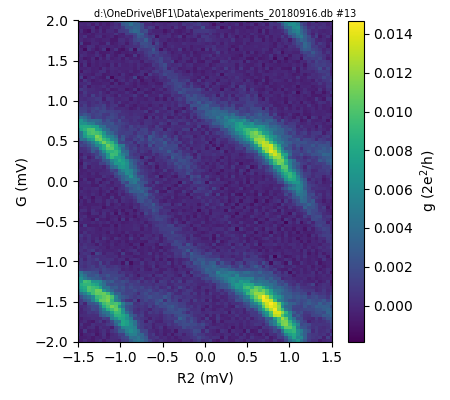

-0.24 -0.195 -0.3


In [368]:
qc.config['core']['db_location'] = r"d:/OneDrive/BF1/Data/experiments_20180916.db"

run_id = 13
data = DataSetDict(run_id=run_id)

ret = dict(data.get_grid('ivvi_setup_SD_conductance'))
R2 = ret['ivvi_setup_R2_voltage']['values']*1e3
G = ret["ivvi_setup_G_fine_voltage"]['values']*1e3
g = ret['ivvi_setup_SD_conductance']['values']

g = -1*g

dng_n = 0.647
dng_s = 0.173

fig, ax1 = plt.subplots(1,1, figsize=(4.5,4))
im1 = ax1.pcolor(R2/dng_n + 0.7, G/dng_s - 2.15, g.T)
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("G (mV)")
ax1.set_xlabel('R2 (mV)')
cb1.set_label(r'g (2e$^2$/h)')

ax1.set_xlim([-1.5, 1.5])
ax1.set_ylim([-2,2])

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()


q = data.get_snapshot()
T2 = q['station']['instruments']['ivvi_setup']['parameters']['T2_voltage']['value']
T3 = q['station']['instruments']['ivvi_setup']['parameters']['T3_voltage']['value']
T4 = q['station']['instruments']['ivvi_setup']['parameters']['T4_voltage']['value']

print(T2, T3, T4)

np.savez("g_coupled.npz", data=g)

In [363]:
G

array([  3.05180438e-04,   6.40878920e-03,   1.31227588e-02,
         1.98367285e-02,   2.65506981e-02,   3.32646677e-02,
         3.99786374e-02,   4.66926070e-02,   5.34065766e-02,
         6.01205463e-02,   6.68345159e-02,   7.35484855e-02,
         8.02624552e-02,   8.63660639e-02,   9.30800336e-02,
         9.97940032e-02,   1.06507973e-01,   1.13221942e-01,
         1.19935912e-01,   1.26649882e-01,   1.33363851e-01,
         1.40077821e-01,   1.46791791e-01,   1.53505760e-01,
         1.60219730e-01,   1.66933700e-01,   1.73037308e-01,
         1.79751278e-01,   1.86465248e-01,   1.93179217e-01,
         1.99893187e-01,   2.06607156e-01,   2.13321126e-01,
         2.20035096e-01,   2.26749065e-01,   2.33463035e-01,
         2.40177005e-01,   2.46890974e-01,   2.53604944e-01,
         2.59708553e-01,   2.66422522e-01,   2.73136492e-01,
         2.79850462e-01,   2.86564431e-01,   2.93278401e-01,
         2.99992370e-01,   3.06706340e-01,   3.13420310e-01,
         3.20134279e-01,

## Combine RF and DC

In [ ]:
run_id = 1409

data = DataSetDict(run_id=run_id)


ret_mag = dict(data.get_grid('detector_signal_abs'))
ret_real = dict(data.get_grid('detector_signal_real'))
ret_imag = dict(data.get_grid('detector_signal_imag'))
ret_phi = dict(data.get_grid('detector_signal_phase'))

pg = ret_mag["ivvi_setup_G_fine_voltage"]["values"]
r2 = ret_mag["ivvi_setup_R2_voltage"]["values"]

mag = np.ma.getdata(ret_mag['detector_signal_abs']['values'])[:,:,0,1]
real = np.ma.getdata(ret_real['detector_signal_real']['values'])[:,:,0,1]
imag = np.ma.getdata(ret_imag['detector_signal_imag']['values'])[:,:,0,1]
phi = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0,1]
phi_ref = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0,0]

fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2,2)

im1 = ax1.pcolor(r2*1e3, pg*1e3,  (phi-phi_ref).T%360)
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("G (mV)")
cb1.set_label('phase (deg)')

im2 = ax2.pcolor(r2*1e3, pg*1e3,  mag.T)
cb2 = fig.colorbar(im2, ax=ax2)
cb2.set_label('abs (V)')

im3 = ax3.pcolor(R2, G, g.T)
cb3 = fig.colorbar(im3, ax=ax3)
ax3.set_ylabel("SD (mV)")
ax3.set_xlabel('R2 (mV)')
cb3.set_label(r'g (2e$^2$/h)')

im4 = ax4.pcolor(R2, G, g.T)
cb4 = fig.colorbar(im4, ax=ax4)
ax4.set_ylabel("SD (mV)")
ax4.set_xlabel('R2 (mV)')
cb4.set_label(r'g (2e$^2$/h)')

# multi = MultiCursor(fig.canvas, (ax1, ax2, ax3, ax4), color='r', lw=1, horizOn=True, vertOn=True)

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

q = data.get_snapshot()
T2 = q['station']['instruments']['ivvi_setup']['parameters']['T2_voltage']['value']
T3 = q['station']['instruments']['ivvi_setup']['parameters']['T3_voltage']['value']
T4 = q['station']['instruments']['ivvi_setup']['parameters']['T4_voltage']['value']

print(T2, T3, T4)

## RF CSD


In [ ]:
import scipy.ndimage

x = r2*1e2
y = pg*1e3
zp = (phi-phi_ref)%360
zm = mag

xoffset = -2.05
xstart, ystart = xoffset+0.331939, -0.44149
xend, yend = xoffset+0.855644, 0.445




#-- Extract the line...
# Make a line with "num" points...
x0, y0 = np.argmin(abs(x-xstart)), np.argmin(abs(y-ystart)) # These are in _pixel_ coordinates!!
x1, y1 = np.argmin(abs(x-xend)), np.argmin(abs(y-yend))
num = 25
xc, yc = np.linspace(x0, x1, num), np.linspace(y0, y1, num)
yv = np.linspace(ystart, yend, num)

# Extract the values along the line
# zi = z[yc.astype(np.int), xc.astype(np.int)]
pi = scipy.ndimage.map_coordinates(zp, np.vstack((yc, xc)))
mi = scipy.ndimage.map_coordinates(zm, np.vstack((yc, xc)))

#-- Plot...
fig, axes = plt.subplots(1,2, figsize=(6,2.5))

axes[0].pcolor(x, y, zp)
axes[0].plot([x[x0], x[x1]], [y[y0], y[y1]], 'ro-')
axes[0].set_xlabel('R2 (mV)')
axes[0].set_ylabel('Vb (mV)')
cb1 = fig.colorbar(im1, ax=axes[0])

ax = axes[1].twinx()
axes[1].plot(yv, pi, 'orange')
ax.plot(yv, mi)
axes[1].set_xlabel('Vb (mV)')
axes[1].set_ylabel('phase (deg)')
ax.set_ylabel('mag (V)')
axes[1].axvline(x=0.14, linestyle = ':', color='k')
axes[1].axvline(x=-0.14, linestyle = ':', color='k')

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()



In [521]:
qc.config['core']['db_location'] = r"d:/OneDrive/BF1/Data/experiments.db"
qc.config['core']['db_location'] = r"d:/OneDrive/BF1/Data/experiments_20181011.db"

<IPython.core.display.Javascript object>


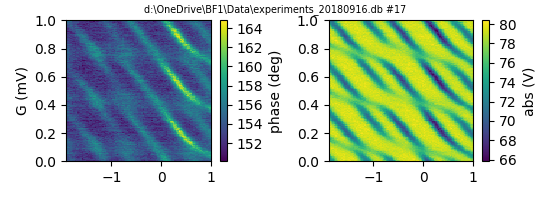

-0.195


In [455]:
run_id =17
data = DataSetDict(run_id=run_id)


ret_mag = dict(data.get_grid('detector_signal_abs'))
ret_real = dict(data.get_grid('detector_signal_real'))
ret_imag = dict(data.get_grid('detector_signal_imag'))
ret_phi = dict(data.get_grid('detector_signal_phase'))

pg = ret_mag["ivvi_setup_G_fine_voltage"]["values"]
r2 = ret_mag["ivvi_setup_R2_voltage"]["values"]

mag = np.ma.getdata(ret_mag['detector_signal_abs']['values'])[:,:,0,1]
real = np.ma.getdata(ret_real['detector_signal_real']['values'])[:,:,0,1]
imag = np.ma.getdata(ret_imag['detector_signal_imag']['values'])[:,:,0,1]
phi = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0,1]
phi_ref = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0,0]

fig, ((ax1, ax2)) = plt.subplots(1,2, figsize=(5.5,2))

im1 = ax1.pcolor(r2*1e3, pg*1e3,  (phi-phi_ref).T%360)
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("G (mV)")
cb1.set_label('phase (deg)')

im2 = ax2.pcolor(r2*1e3, pg*1e3,  mag.T)
cb2 = fig.colorbar(im2, ax=ax2)
cb2.set_label('abs (V)')

# im3 = ax3.pcolor(r2*1e3, pg*1e3,  real.T)
# cb3 = fig.colorbar(im3, ax=ax3)
# ax3.set_xlabel('R2 (mV)')
# ax3.set_ylabel("G (mV)")
# cb3.set_label('real (V)')

# im4 = ax4.pcolor(r2*1e3, pg*1e3,  imag.T)
# cb4 = fig.colorbar(im4, ax=ax4)
# ax4.set_xlabel('R2 (mV)')
# cb4.set_label('imag (V)')

# multi = MultiCursor(fig.canvas, (ax1, ax2, ax3, ax4), color='r', lw=1, horizOn=True, vertOn=True)

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

mag.shape

q = data.get_snapshot()
T2 = q['station']['instruments']['ivvi_setup']['parameters']['T2_voltage']['value']
T3 = q['station']['instruments']['ivvi_setup']['parameters']['T3_voltage']['value']
T4 = q['station']['instruments']['ivvi_setup']['parameters']['T4_voltage']['value']
q['station']['instruments']["AMI430"]['parameters']['field']['value']
q['station']['instruments']["AMI430"]['parameters']['field']['value']

print(T3)

C:\Users\Administrator\Anaconda3\envs\qcodes\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


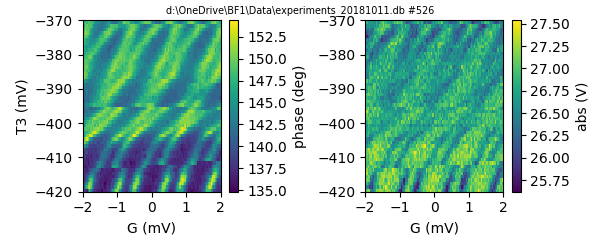

-0.5 -0.4 -0.5 -0.5


In [1812]:
run_id = 526


data = DataSetDict(run_id=run_id)


ret_mag = dict(data.get_grid('detector_signal_abs'))
ret_real = dict(data.get_grid('detector_signal_real'))
ret_imag = dict(data.get_grid('detector_signal_imag'))
ret_phi = dict(data.get_grid('detector_signal_phase'))

pg = ret_mag["ivvi_setup_T3_voltage"]["values"]
r2 = ret_mag["ivvi_setup_G_fine_voltage"]["values"]

mag = np.ma.getdata(ret_mag['detector_signal_abs']['values'])[:,:,0,1]
real = np.ma.getdata(ret_real['detector_signal_real']['values'])[:,:,0,1]
imag = np.ma.getdata(ret_imag['detector_signal_imag']['values'])[:,:,0,1]
phi = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0,1]
phi_ref = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0,0]

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2.5))

cphase =(phi-phi_ref).T%360

im1 = ax1.pcolor(r2*1e3, pg*1e3,  (phi-phi_ref).T%360)
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("T3 (mV)")
# ax1.set_ylim([-400, -300])
cb1.set_label('phase (deg)')
ax1.set_xlabel("G (mV)")

im2 = ax2.pcolor(r2*1e3, pg*1e3,  mag.T)
cb2 = fig.colorbar(im2, ax=ax2)
cb2.set_label('abs (V)')
ax2.set_xlabel("G (mV)")

# multi = MultiCursor(fig.canvas, (ax1, ax2, ax3, ax4), color='r', lw=1, horizOn=True, vertOn=True)

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()



q = data.get_snapshot()
T2 = q['station']['instruments']['ivvi_setup']['parameters']['T2_voltage']['value']
T3 = q['station']['instruments']['ivvi_setup']['parameters']['T3_voltage']['value']
T4 = q['station']['instruments']['ivvi_setup']['parameters']['T4_voltage']['value']
G = q['station']['instruments']['ivvi_setup']['parameters']['G_coarse_voltage']['value']


print(T2,T3,T4, G)

<IPython.core.display.Javascript object>


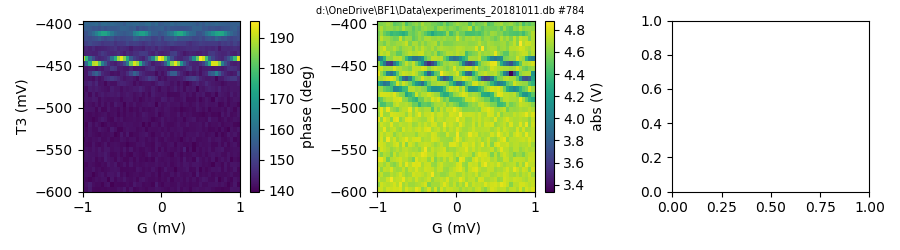

C:\Users\Administrator\Anaconda3\envs\qcodes\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in remainder
C:\Users\Administrator\Anaconda3\envs\qcodes\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in remainder


2 -0.6 -0.8 -0.5


In [550]:
run_id = 784


data = DataSetDict(run_id=run_id)


ret_mag = dict(data.get_grid('detector_signal_abs'))
ret_real = dict(data.get_grid('detector_signal_real'))
ret_imag = dict(data.get_grid('detector_signal_imag'))
ret_phi = dict(data.get_grid('detector_signal_phase'))

pg = ret_mag["ivvi_setup_T3_voltage"]["values"]
r2 = ret_mag["ivvi_setup_R1_voltage"]["values"]

mag = np.ma.getdata(ret_mag['detector_signal_abs']['values'])[:,:,0,1]
real = np.ma.getdata(ret_real['detector_signal_real']['values'])[:,:,0,1]
imag = np.ma.getdata(ret_imag['detector_signal_imag']['values'])[:,:,0,1]
phi = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0,1]
phi_ref = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0,0]

fig, (ax1, ax2,ax3) = plt.subplots(1,3, figsize=(9,2.5))

cphase =(phi-phi_ref).T%360

im1 = ax1.pcolor(r2*1e3, pg*1e3,  (phi-phi_ref).T%360)
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("T3 (mV)")
# ax1.set_xlim([-1, 1])
cb1.set_label('phase (deg)')
ax1.set_xlabel("G (mV)")

im2 = ax2.pcolor(r2*1e3, pg*1e3,  mag.T)
cb2 = fig.colorbar(im2, ax=ax2)
cb2.set_label('abs (V)')
ax2.set_xlabel("G (mV)")


# ax3.plot(r2, cphase[70,:])
# multi = MultiCursor(fig.canvas, (ax1, ax2, ax3, ax4), color='r', lw=1, horizOn=True, vertOn=True)

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()



q = data.get_snapshot()
T2 = q['station']['instruments']['ivvi_setup']['parameters']['T2_voltage']['value']
T3 = q['station']['instruments']['ivvi_setup']['parameters']['T3_voltage']['value']
T4 = q['station']['instruments']['ivvi_setup']['parameters']['T4_voltage']['value']
G = q['station']['instruments']['ivvi_setup']['parameters']['G_coarse_voltage']['value']


print(T2,T3,T4, G)

In [ ]:
run_id = 397
data = DataSetDict(run_id=run_id)


ret_mag = dict(data.get_grid('detector_signal_abs'))
ret_real = dict(data.get_grid('detector_signal_real'))
ret_imag = dict(data.get_grid('detector_signal_imag'))
ret_phi = dict(data.get_grid('detector_signal_phase'))

pg = ret_mag["ivvi_setup_G_fine_voltage"]["values"]
r2 = ret_mag["ivvi_setup_R2_voltage"]["values"]

mag = np.ma.getdata(ret_mag['detector_signal_abs']['values'])[:,:,0,1]
real = np.ma.getdata(ret_real['detector_signal_real']['values'])[:,:,0,1]
imag = np.ma.getdata(ret_imag['detector_signal_imag']['values'])[:,:,0,1]
phi = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0,1]
phi_ref = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0,0]

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2.5))

im1 = ax1.pcolor(r2*1e3, pg*1e3,  (phi-phi_ref).T%360)
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("G (mV)")
cb1.set_label('phase (deg)')

im2 = ax2.pcolor(r2*1e3, pg*1e3,  mag.T)
cb2 = fig.colorbar(im2, ax=ax2)
cb2.set_label('abs (V)')



# multi = MultiCursor(fig.canvas, (ax1, ax2, ax3, ax4), color='r', lw=1, horizOn=True, vertOn=True)

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

mag.shape

q = data.get_snapshot()
T2 = q['station']['instruments']['ivvi_setup']['parameters']['T2_voltage']['value']
T3 = q['station']['instruments']['ivvi_setup']['parameters']['T3_voltage']['value']
T4 = q['station']['instruments']['ivvi_setup']['parameters']['T4_voltage']['value']
q['station']['instruments']["AMI430"]['parameters']['field']['value']


print(T2,T3,T4)

In [ ]:
np.linspace(-0.425,-0.38,10)

In [ ]:

run_id = 1177

data = DataSetDict(run_id=run_id)
q = data.get_snapshot()

T1 = q['station']['instruments']['ivvi_setup']['parameters']['T1_voltage']['value']
T2 = q['station']['instruments']['ivvi_setup']['parameters']['T2_voltage']['value']
T3 = q['station']['instruments']['ivvi_setup']['parameters']['T3_voltage']['value']
T4 = q['station']['instruments']['ivvi_setup']['parameters']['T4_voltage']['value']


print(T1, T2, T3, T4)

### Linetrace with G

In [ ]:
run_id = 399

data = DataSetDict(run_id=run_id)


ret_mag = dict(data.get_grid('detector_signal_abs'))
ret_real = dict(data.get_grid('detector_signal_real'))
ret_imag = dict(data.get_grid('detector_signal_imag'))
ret_phi = dict(data.get_grid('detector_signal_phase'))

pg = ret_mag["ivvi_setup_G_fine_voltage"]["values"]

mag = np.ma.getdata(ret_mag['detector_signal_abs']['values'])[:,0,1]
real = np.ma.getdata(ret_real['detector_signal_real']['values'])[:,0,1]
imag = np.ma.getdata(ret_imag['detector_signal_imag']['values'])[:,0,1]
phi = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,0,1]
phi_ref = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,0,0]

fig, (ax1) = plt.subplots(1,1, figsize=(3,2.5))

im1 = ax1.plot(pg*1e3,(phi-phi_ref).T%360)
ax1.set_ylabel('phase (deg)')
ax1.set_xlabel('G (mV)')



# multi = MultiCursor(fig.canvas, (ax1, ax2, ax3, ax4), color='r', lw=1, horizOn=True, vertOn=True)

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

# r2.size

# plt.show()

### RF CSD - R2 vs field

In [ ]:
cphase[:,-1]

In [ ]:
run_id = 281
data = DataSetDict(run_id=run_id)


ret_mag = dict(data.get_grid('detector_signal_abs'))
ret_real = dict(data.get_grid('detector_signal_real'))
ret_imag = dict(data.get_grid('detector_signal_imag'))
ret_phi = dict(data.get_grid('detector_signal_phase'))

B = ret_mag["AMI430_field"]["values"]
r2 = ret_mag["ivvi_setup_R2_voltage"]["values"]

mag = np.ma.getdata(ret_mag['detector_signal_abs']['values'])[:,:,0,1]
real = np.ma.getdata(ret_real['detector_signal_real']['values'])[:,:,0,1]
imag = np.ma.getdata(ret_imag['detector_signal_imag']['values'])[:,:,0,1]
phi = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0,1]
phi_ref = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0,0]

fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2,2)

cphase = (phi-phi_ref).T%360
cphase= (cphase.T - cphase[:,-2]).T

im1 = ax1.pcolor(r2*1e3, B*1e3,  cphase)
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("B (mT)")
cb1.set_label('phase (deg)')

im2 = ax2.pcolor(r2*1e3, B*1e3,  (mag-mag.T[:,-2]).T)
cb2 = fig.colorbar(im2, ax=ax2)
cb2.set_label('abs (V)')

im3 = ax3.pcolor(r2*1e3, B*1e3,  real.T)
cb3 = fig.colorbar(im3, ax=ax3)
ax3.set_xlabel('R2 (mV)')
ax3.set_ylabel("B (mT)")
cb3.set_label('real (V)')


im4 = ax4.pcolor(r2*1e3, B*1e3,  imag.T)
cb4 = fig.colorbar(im4, ax=ax4)
ax4.set_xlabel('R2 (mV)')
cb4.set_label('imag (V)')

# multi = MultiCursor(fig.canvas, (ax1, ax2, ax3, ax4), color='r', lw=1, horizOn=True, vertOn=True)

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()



In [ ]:
run_id = 295
data = DataSetDict(run_id=run_id)


ret_mag = dict(data.get_grid('detector_signal_abs'))
ret_real = dict(data.get_grid('detector_signal_real'))
ret_imag = dict(data.get_grid('detector_signal_imag'))
ret_phi = dict(data.get_grid('detector_signal_phase'))

B = ret_mag["AMI430_field"]["values"]
r2 = ret_mag["ivvi_setup_R2_voltage"]["values"]

mag = np.ma.getdata(ret_mag['detector_signal_abs']['values'])[:,:,0,1]
real = np.ma.getdata(ret_real['detector_signal_real']['values'])[:,:,0,1]
imag = np.ma.getdata(ret_imag['detector_signal_imag']['values'])[:,:,0,1]
phi = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0,1]
phi_ref = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0,0]

fig, ((ax1, ax2)) = plt.subplots(1,2, figsize=(6,2.5))

cphase = (phi-phi_ref).T%360
cphase= (cphase.T - cphase[:,-2]).T

im1 = ax1.pcolor(r2*1e3, B*1e3,  cphase)
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("B (mT)")
cb1.set_label('phase (deg)')

im2 = ax2.pcolor(r2*1e3, B*1e3,  (mag-mag.T[:,-2]).T)
cb2 = fig.colorbar(im2, ax=ax2)
cb2.set_label('abs (V)')


# multi = MultiCursor(fig.canvas, (ax1, ax2, ax3, ax4), color='r', lw=1, horizOn=True, vertOn=True)

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()



In [ ]:
from scipy.signal import find_peaks_cwt

In [ ]:
run_id = 1449
          

data = DataSetDict(run_id=run_id)

ret_phi = dict(data.get_grid('detector_signal_phase'))

B = ret_mag["AMI430_field"]["values"]
r2 = ret_mag["ivvi_setup_R2_voltage"]["values"]

phi = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0,1]
phi_ref = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0,0]

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(6,3))

cphase = (phi-phi_ref).T%360
cphase= (cphase.T - cphase[:,-1]).T

im1 = ax1.pcolor(r2*1e3, B*1e3,  cphase)
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("B (mT)")
cb1.set_label('phase (deg)')

ax2.plot(cphase[5,:])


# multi = MultiCursor(fig.canvas, (ax1, ax2, ax3, ax4), color='r', lw=1, horizOn=True, vertOn=True)

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()



In [ ]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [ ]:
# for 

idx_cut = 1

data = cphase[idx_cut,:]

data = smooth(data, 4)

peakind = find_peaks_cwt(data, [0.1], min_length=0.5)
peakind, r2[peakind], data[peakind]

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(6,3))

im1 = ax1.pcolor(r2*1e3, B*1e3,  cphase)
ax1.axhline(y=B[idx_cut]*1e3, color = 'red')
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("B (mT)")
cb1.set_label('phase (deg)')

ax2.plot(r2*1e3, data)
ax2.plot(r2[peakind]*1e3, data[peakind], 'o')

In [ ]:
IDX = []

fig, ax = plt.subplots(1,1)
ax.pcolor(r2, B,  cphase)

for i in range(len(B)):
    

    idx_cut = i

    data = cphase[idx_cut,:]

    data = smooth(data, 4)

    peakind = find_peaks_cwt(data, [0.1], min_length=0.5)
    peakind, r2[peakind], data[peakind]
    IDX.append(r2[peakind])
    

    
    ax.plot(r2[peakind], B[i].repeat(len(r2[peakind])), 'bo')

ax.set_ylim([0, 0.5])
# print(IDX)


### RF CSD - G vs field

C:\Users\Administrator\Anaconda3\envs\qcodes\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


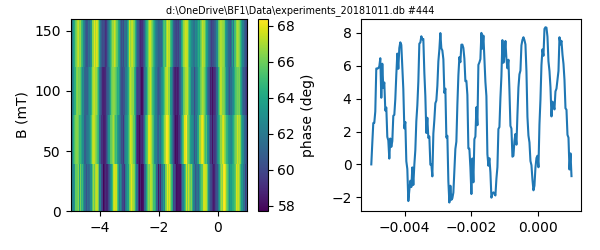

C:\Users\Administrator\Anaconda3\envs\qcodes\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in remainder


(5, 201)


In [1561]:
run_id = 444

data = DataSetDict(run_id=run_id)


ret_mag = dict(data.get_grid('detector_signal_abs'))
ret_real = dict(data.get_grid('detector_signal_real'))
ret_imag = dict(data.get_grid('detector_signal_imag'))
ret_phi = dict(data.get_grid('detector_signal_phase'))

B = ret_mag["AMI430_field"]["values"]
r2 = ret_mag["ivvi_setup_G_fine_voltage"]["values"]

mag = np.ma.getdata(ret_mag['detector_signal_abs']['values'])[:,:,0,1]
real = np.ma.getdata(ret_real['detector_signal_real']['values'])[:,:,0,1]
imag = np.ma.getdata(ret_imag['detector_signal_imag']['values'])[:,:,0,1]
phi = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0,1]
phi_ref = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0,0]

fig, ((ax1, ax2)) = plt.subplots(1,2, figsize=(6,2.5))

cphase = ((phi-phi_ref)).T
cphase = (cphase.T - cphase[:,0]).T

# nphase = np.zeros(cphase.shape)

# for i in range(len(B)):
#     nphase[i,:] = cphase[i,:]/np.amax(cphase[i,:])

im1 = ax1.pcolor(r2*1e3, B*1e3,  (cphase-300)%360)
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("B (mT)")
cb1.set_label('phase (deg)')

im2 = ax2.plot(r2, cphase[0,:])
# cb2 = fig.colorbar(im2, ax=ax2)
# cb2.set_label('abs (V)')

# im3 = ax3.plot(B, np.amax(cphase, axis=1))
# # cb3 = fig.colorbar(im3, ax=ax3)
# ax3.set_xlabel('R2 (mV)')
# ax3.set_ylabel("B (mT)")
# # cb3.set_label('real (V)')

# im4 = ax4.plot(r2*1e3, cphase[35,:]/np.amax(cphase[0,:]))
# # cb4 = fig.colorbar(im4, ax=ax4)
# ax4.set_xlabel('R2 (mV)')
# # cb4.set_label('imag (V)')



# multi = MultiCursor(fig.canvas, (ax1, ax2, ax3, ax4), color='r', lw=1, horizOn=True, vertOn=True)

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

print(cphase.shape)

In [ ]:
run_id = 1447

data = DataSetDict(run_id=run_id)


ret_mag = dict(data.get_grid('detector_signal_abs'))
ret_real = dict(data.get_grid('detector_signal_real'))
ret_imag = dict(data.get_grid('detector_signal_imag'))
ret_phi = dict(data.get_grid('detector_signal_phase'))

B = ret_mag["AMI430_field"]["values"]
r2 = ret_mag["ivvi_setup_G_fine_voltage"]["values"]

mag = np.ma.getdata(ret_mag['detector_signal_abs']['values'])[:,:,0,1]
real = np.ma.getdata(ret_real['detector_signal_real']['values'])[:,:,0,1]
imag = np.ma.getdata(ret_imag['detector_signal_imag']['values'])[:,:,0,1]
phi = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0,1]
phi_ref = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0,0]

fig, (ax1) = plt.subplots(1,1)

cphase = (phi-phi_ref).T%360
cphase= (cphase.T - cphase[:,-1]).T

im1 = ax1.pcolor(r2*1e3, B*1e3,  cphase)
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("B (mT)")
ax1.set_xlabel("G (mV)")
cb1.set_label('phase (deg)')

# multi = MultiCursor(fig.canvas, (ax1, ax2, ax3, ax4), color='r', lw=1, horizOn=True, vertOn=True)

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()



In [ ]:
run_id = 1440

data = DataSetDict(run_id=run_id)


ret_mag = dict(data.get_grid('detector_signal_abs'))
ret_real = dict(data.get_grid('detector_signal_real'))
ret_imag = dict(data.get_grid('detector_signal_imag'))
ret_phi = dict(data.get_grid('detector_signal_phase'))

pg = ret_mag["ivvi_setup_G_fine_voltage"]["values"]
r2 = ret_mag["ivvi_setup_R2_voltage"]["values"]

mag = np.ma.getdata(ret_mag['detector_signal_abs']['values'])[:,:,0,1]
real = np.ma.getdata(ret_real['detector_signal_real']['values'])[:,:,0,1]
imag = np.ma.getdata(ret_imag['detector_signal_imag']['values'])[:,:,0,1]
phi = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0,1]
phi_ref = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0,0]

fig, (ax1) = plt.subplots(1,1)

im1 = ax1.pcolor(r2*1e3, pg*1e3,  (phi-phi_ref).T%360)
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("G (mV)")
ax1.set_xlabel("R2 (mV)")
cb1.set_label('phase (deg)')


# multi = MultiCursor(fig.canvas, (ax1, ax2, ax3, ax4), color='r', lw=1, horizOn=True, vertOn=True)

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

mag.shape

q = data.get_snapshot()
T2 = q['station']['instruments']['ivvi_setup']['parameters']['T2_voltage']['value']
T3 = q['station']['instruments']['ivvi_setup']['parameters']['T3_voltage']['value']
T4 = q['station']['instruments']['ivvi_setup']['parameters']['T4_voltage']['value']

print(T2, T3, T4)

In [ ]:
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2,2)
ax1.pcolor(phi)

In [ ]:
qc.config['core']['db_location'] = r"d:/OneDrive/BF1/Data/experiments.db"

run_id = 2213


data = DataSetDict(run_id=run_id)


ret_mag = dict(data.get_grid('detector_signal_abs'))
ret_real = dict(data.get_grid('detector_signal_real'))
ret_imag = dict(data.get_grid('detector_signal_imag'))
ret_phi = dict(data.get_grid('detector_signal_phase'))

pg = ret_mag["ivvi_setup_R1_voltage"]["values"]
r2 = ret_mag["sequence_voltage_vals"]["values"]

mag = np.ma.getdata(ret_mag['detector_signal_abs']['values'])[:,:,1]
real = np.ma.getdata(ret_real['detector_signal_real']['values'])[:,:,1]
imag = np.ma.getdata(ret_imag['detector_signal_imag']['values'])[:,:,1]
phi = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,1]
phi_ref = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0]



q = data.get_snapshot()

T2 = q['station']['instruments']['ivvi_setup']['parameters']['T2_voltage']['value']
T3 = q['station']['instruments']['ivvi_setup']['parameters']['T3_voltage']['value']
T4 = q['station']['instruments']['ivvi_setup']['parameters']['T4_voltage']['value']
field = q['station']['instruments']["AMI430"]['parameters']['field']['value']
print(T2, T3, T4, field)


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2.5))
im1 = ax1.pcolor(r2*1e2,pg*1e3,   (phi-phi_ref)%360)
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("R1 (mV)")
ax1.set_xlabel('R2 (mV)')
cb1.set_label('phase (deg)')

im2 = ax2.pcolor(r2*1e2,pg*1e3,     mag)
cb2 = fig.colorbar(im2, ax=ax2)
cb2.set_label('abs (V)')
ax2.set_xlabel('R2 (mV)')



fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()


plt.show()

In [ ]:
qc.config['core']['db_location'] = r"d:/OneDrive/BF1/Data/experiments.db"

run_id = 2192


data = DataSetDict(run_id=run_id)

ret_mag = dict(data.get_grid('detector_signal_abs'))
ret_real = dict(data.get_grid('detector_signal_real'))
ret_imag = dict(data.get_grid('detector_signal_imag'))
ret_phi = dict(data.get_grid('detector_signal_phase'))

pg = ret_mag["ivvi_setup_G_fine_voltage"]["values"]
r2 = ret_mag["sequence_voltage_vals"]["values"]

mag = np.ma.getdata(ret_mag['detector_signal_abs']['values'])[:,:,1]
real = np.ma.getdata(ret_real['detector_signal_real']['values'])[:,:,1]
imag = np.ma.getdata(ret_imag['detector_signal_imag']['values'])[:,:,1]
phi = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,1]
phi_ref = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0]



q = data.get_snapshot()

T2 = q['station']['instruments']['ivvi_setup']['parameters']['T2_voltage']['value']
T3 = q['station']['instruments']['ivvi_setup']['parameters']['T3_voltage']['value']
T4 = q['station']['instruments']['ivvi_setup']['parameters']['T4_voltage']['value']
field = q['station']['instruments']["AMI430"]['parameters']['field']['value']
print(T2, T3, T4, field)

cphase = (phi-phi_ref)%360

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2.5))
im1 = ax1.pcolor(r2*1e2,pg*1e3,   (phi-phi_ref)%360)
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("G (mV)")
ax1.set_xlabel('R2 (mV)')
cb1.set_label('phase (deg)')

im2 = ax2.pcolor(r2*1e2,pg*1e3,     mag/250)
cb2 = fig.colorbar(im2, ax=ax2)
cb2.set_label('abs (V)')
ax2.set_xlabel('R2 (mV)')



fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()


plt.show()

phi.shape

## CSD hard sweep

In [10]:
# qc.config['core']['db_location'] = r"d:/OneDrive/BF1/Data/experiments.db"
qc.config['core']['db_location'] = r"d:/OneDrive/BF1/Data/experiments_20180916.db"

-0.31 -0.18499999999999978 -0.33 0.0002831611202125037


<IPython.core.display.Javascript object>


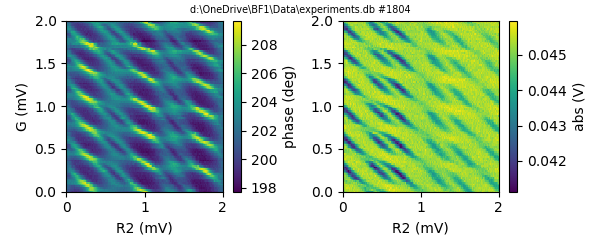

(101, 200)

In [560]:
qc.config['core']['db_location'] = r"d:/OneDrive/BF1/Data/experiments.db"

run_id = 1804

data = DataSetDict(run_id=run_id)

ret_mag = dict(data.get_grid('detector_signal_abs'))
ret_real = dict(data.get_grid('detector_signal_real'))
ret_imag = dict(data.get_grid('detector_signal_imag'))
ret_phi = dict(data.get_grid('detector_signal_phase'))

pg = ret_mag["ivvi_setup_G_fine_voltage"]["values"]
r2 = ret_mag["sequence_voltage_vals"]["values"]

mag = np.ma.getdata(ret_mag['detector_signal_abs']['values'])[:,:,1]
real = np.ma.getdata(ret_real['detector_signal_real']['values'])[:,:,1]
imag = np.ma.getdata(ret_imag['detector_signal_imag']['values'])[:,:,1]
phi = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,1]
phi_ref = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0]



q = data.get_snapshot()

T2 = q['station']['instruments']['ivvi_setup']['parameters']['T2_voltage']['value']
T3 = q['station']['instruments']['ivvi_setup']['parameters']['T3_voltage']['value']
T4 = q['station']['instruments']['ivvi_setup']['parameters']['T4_voltage']['value']
field = q['station']['instruments']["AMI430"]['parameters']['field']['value']
print(T2, T3, T4, field)

cphase = (phi-phi_ref)%360

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2.5))
im1 = ax1.pcolor(r2*1e2,pg*1e3,   (phi-phi_ref)%360)
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("G (mV)")
ax1.set_xlabel('R2 (mV)')
cb1.set_label('phase (deg)')

im2 = ax2.pcolor(r2*1e2,pg*1e3,     mag/250)
cb2 = fig.colorbar(im2, ax=ax2)
cb2.set_label('abs (V)')
ax2.set_xlabel('R2 (mV)')



fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()


plt.show()

phi.shape

In [ ]:
qc.config['core']['db_location'] = r"d:/OneDrive/BF1/Data/experiments_20180916.db"

run_id = 97

data = DataSetDict(run_id=run_id)

ret_mag = dict(data.get_grid('detector_signal_abs'))
ret_real = dict(data.get_grid('detector_signal_real'))
ret_imag = dict(data.get_grid('detector_signal_imag'))
ret_phi = dict(data.get_grid('detector_signal_phase'))

r2c = ret_mag["ivvi_setup_R2_coarse_voltage"]["values"]
r2 = ret_mag["sequence_voltage_vals"]["values"]

mag = np.ma.getdata(ret_mag['detector_signal_abs']['values'])[:,:,1]
real = np.ma.getdata(ret_real['detector_signal_real']['values'])[:,:,1]
imag = np.ma.getdata(ret_imag['detector_signal_imag']['values'])[:,:,1]
phi = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,1]
phi_ref = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0]



q = data.get_snapshot()

T2 = q['station']['instruments']['ivvi_setup']['parameters']['T2_voltage']['value']
T3 = q['station']['instruments']['ivvi_setup']['parameters']['T3_voltage']['value']
T4 = q['station']['instruments']['ivvi_setup']['parameters']['T4_voltage']['value']
field = q['station']['instruments']["AMI430"]['parameters']['field']['value']
print(T2, T3, T4, field)

cphase = (phi-phi_ref)%360

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2.5))
im1 = ax1.pcolor(r2*1e2,r2c*1e3,   (phi-phi_ref)%360)
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("R2c (mV)")
ax1.set_xlabel('R2 (mV)')
cb1.set_label('phase (deg)')

im2 = ax2.pcolor(r2*1e2,r2c*1e3,     mag/250)
cb2 = fig.colorbar(im2, ax=ax2)
cb2.set_label('abs (V)')
ax2.set_xlabel('R2 (mV)')



fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()


plt.show()

phi.shape

In [7]:
def lorentzian_peak(x, x0, a, gamma, b):
    return b+a*0.5*gamma/((x-x0)**2+(0.5*gamma)**2)

def fitfunc(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        ctr = params[i]
        amp = params[i+1]
        wid = params[i+2]
        y = y + amp * 0.5*wid/((x-ctr)**2+(0.5*wid)**2)
    return y

In [ ]:
x = r2*1e2

i = 21
y = cphase[i,:] - min(cphase[i,:])

maxtab, mintab = peakdet(y, 3, x)
xp = array(maxtab)[:,0]
yp = array(maxtab)[:,1]
xp = np.append(xp, x[-1])
yp = np.append(yp, y[-1])

guess = []
for i in range(len(xp)):
    guess += [xp[i], 1, 0.1]   
popt, pcov = curve_fit(fitfunc, x, y, p0=guess)
fit = fitfunc(x, *popt)
# fit = fitfunc(x, *guess)

maxtab, mintab = peakdet(fit, 3)
xp = array(maxtab)[:,0]
yp = array(maxtab)[:,1]

idx = []
for xq in xp:
    idx.append(int(xq))
diffs = np.diff(x[idx][1:-1])


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2.5))
ax1.plot(x, y)
ax1.plot(x, fit)
ax1.scatter(x[idx][1:-1], y[idx][1:-1], color='blue')


fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

popt

In [ ]:
x = r2*1e2

i = 0

y = cphase[0,:] - min(cphase[0,:])
xfit = np.linspace(min(x), max(x), 1001)

bounds = []


I = []
D = []
    
for i in range(len(cphase[:,0])):
    y = cphase[i,:] - min(cphase[i,:])
    
    maxtab, mintab = peakdet(y, 0.5, x)
    xp = array(maxtab)[:,0]
    yp = array(maxtab)[:,1]
    xp = np.append(xp, x[-1])
    yp = np.append(yp, y[-1])

    guess = []
    bound_min = []
    bound_max = []
    for i in range(len(xp)):
        guess += [xp[i], 1, 0.1] 
        bound_min += [min(x), 0, 0] 
        bound_max += [max(x), 2, 2] 
    try:
        popt, pcov = curve_fit(fitfunc, x, y, p0=guess, bounds=(bound_min, bound_max))
    except:
        popt, pcov = curve_fit(fitfunc, x, y, p0=guess2, bounds=(bound_min, bound_max))
        
#     fit = fitfunc(x, *popt)
    fit = fitfunc(xfit, *popt)
    guess2 = popt

    maxtab, mintab = peakdet(fit, 3)
    xp = array(maxtab)[:,0]
    yp = array(maxtab)[:,1]

    idx = []
    for xq in xp:
        idx.append(int(xq))
    
    diffs = np.diff(xfit[idx][1:-1])
    
    I.append(idx)
    D.append(diffs)


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2.5))
ax1.plot(x, y)
# ax1.plot(x, fit)
# ax1.scatter(x[idx][1:-1], y[idx][1:-1], color='blue')

for i in range(len(cphase[:,0])):
    ax2.plot(i*np.ones(len(D[i])), D[i], 'b.')

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()



In [ ]:
D = np.concatenate(D)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2.5))
ax1.hist(D, bins=51)

In [ ]:


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
im1 = ax1.pcolor(r2*1e2,pg*1e3,   (phi-phi_ref)%360)



cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("G (mV)")
ax1.set_xlabel('R2 (mV)')
cb1.set_label('phase (deg)')
for i in range(len(cphase[:,0])):
    ax1.plot(xfit[I[i][1:-1]], np.ones(len(I[i][1:-1]))*pg[i]*1e3, 'b.')

im2 = ax2.pcolor(r2*1e2,pg*1e3,     mag)
cb2 = fig.colorbar(im2, ax=ax2)
cb2.set_label('abs (V)')
ax2.set_xlabel('R2 (mV)')



fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()


plt.show()

phi.shape

In [8]:
import sys
from numpy import NaN, Inf, arange, isscalar, asarray, array

def peakdet(v, delta, x = None):
    """
    Converted from MATLAB script at http://billauer.co.il/peakdet.html
    
    Returns two arrays
    
    function [maxtab, mintab]=peakdet(v, delta, x)
    %PEAKDET Detect peaks in a vector
    %        [MAXTAB, MINTAB] = PEAKDET(V, DELTA) finds the local
    %        maxima and minima ("peaks") in the vector V.
    %        MAXTAB and MINTAB consists of two columns. Column 1
    %        contains indices in V, and column 2 the found values.
    %      
    %        With [MAXTAB, MINTAB] = PEAKDET(V, DELTA, X) the indices
    %        in MAXTAB and MINTAB are replaced with the corresponding
    %        X-values.
    %
    %        A point is considered a maximum peak if it has the maximal
    %        value, and was preceded (to the left) by a value lower by
    %        DELTA.
    
    % Eli Billauer, 3.4.05 (Explicitly not copyrighted).
    % This function is released to the public domain; Any use is allowed.
    """
    maxtab = []
    mintab = []
       
    if x is None:
        x = arange(len(v))
    
    v = asarray(v)
    
    if len(v) != len(x):
        sys.exit('Input vectors v and x must have same length')
    
    if not isscalar(delta):
        sys.exit('Input argument delta must be a scalar')
    
    if delta <= 0:
        sys.exit('Input argument delta must be positive')
    
    mn, mx = Inf, -Inf
    mnpos, mxpos = NaN, NaN
    
    lookformax = True
    
    for i in arange(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]
        
        if lookformax:
            if this < mx-delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn+delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True

    return array(maxtab), array(mintab)

In [ ]:
qc.config['core']['db_location'] = r"d:/OneDrive/BF1/Data/experiments.db"

run_id = 2327

data = DataSetDict(run_id=run_id)

ret_mag = dict(data.get_grid('detector_signal_abs'))
ret_real = dict(data.get_grid('detector_signal_real'))
ret_imag = dict(data.get_grid('detector_signal_imag'))
ret_phi = dict(data.get_grid('detector_signal_phase'))

t4 = ret_mag["ivvi_setup_T4_voltage"]["values"]*1e3
r2 = ret_mag["sequence_voltage_vals"]["values"]*1e2

mag = np.ma.getdata(ret_mag['detector_signal_abs']['values'])[:,:,1]
real = np.ma.getdata(ret_real['detector_signal_real']['values'])[:,:,1]
imag = np.ma.getdata(ret_imag['detector_signal_imag']['values'])[:,:,1]
phi = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,1]
phi_ref = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0]



q = data.get_snapshot()

T2 = q['station']['instruments']['ivvi_setup']['parameters']['T2_voltage']['value']
T3 = q['station']['instruments']['ivvi_setup']['parameters']['T3_voltage']['value']
T4 = q['station']['instruments']['ivvi_setup']['parameters']['T4_voltage']['value']
field = q['station']['instruments']["AMI430"]['parameters']['field']['value']
print(T2, T3, T4, field)

cphase = (phi-phi_ref)%360

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2.5))
im1 = ax1.pcolor(r2,t4,   (phi-phi_ref)%360)
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("T4 (mV)")
ax1.set_xlabel('R2 (mV)')
cb1.set_label('phase (deg)')

im2 = ax2.pcolor(r2,t4,     mag/250)
cb2 = fig.colorbar(im2, ax=ax2)
cb2.set_label('abs (V)')
ax2.set_xlabel('R2 (mV)')



fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()


plt.show()

phi.shape

In [ ]:
x = r2

i = 0
y = cphase[i,:] - min(cphase[i,:])

maxtab, mintab = peakdet(y, 2, x)
xp = array(maxtab)[:,0]
yp = array(maxtab)[:,1]
xp = np.append(xp, x[-1])
yp = np.append(yp, y[-1])

guess = []
for i in range(len(xp)):
    guess += [xp[i], yp[i]/50, 0.1]   
popt, pcov = curve_fit(fitfunc, x, y, p0=guess)
fit = fitfunc(x, *popt)
# fit = fitfunc(x, *guess)

# maxtab, mintab = peakdet(fit, 3)
# xp = array(maxtab)[:,0]
# yp = array(maxtab)[:,1]

idx = []
for xq in xp:
    idx.append(int(xq))
diffs = np.diff(x[idx][1:-1])


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2.5))
ax1.plot(x, y)
ax1.plot(xp, yp, 'o')
ax1.plot(x, fit)
# ax1.scatter(x[idx][1:-1], y[idx][1:-1], color='blue')


fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

popt

In [ ]:
qc.config['core']['db_location'] = r"d:/OneDrive/BF1/Data/experiments.db"

run_id = 2184


data = DataSetDict(run_id=run_id)

ret_mag = dict(data.get_grid('detector_signal_abs'))
ret_real = dict(data.get_grid('detector_signal_real'))
ret_imag = dict(data.get_grid('detector_signal_imag'))
ret_phi = dict(data.get_grid('detector_signal_phase'))

pg = ret_mag["ivvi_setup_G_fine_voltage"]["values"]
r2 = ret_mag["sequence_voltage_vals"]["values"]

mag = np.ma.getdata(ret_mag['detector_signal_abs']['values'])[:,:,1]
real = np.ma.getdata(ret_real['detector_signal_real']['values'])[:,:,1]
imag = np.ma.getdata(ret_imag['detector_signal_imag']['values'])[:,:,1]
phi = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,1]
phi_ref = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0]

xoff = 0
yoff = 0
x1,y1 = xoff-0.87, yoff+0.35
x2,y2 = xoff-1   , yoff+0.60
x3,y3 = xoff-0.87, yoff+0.67
x4,y4 = xoff-0.76, yoff+0.6

q = data.get_snapshot()

T2 = q['station']['instruments']['ivvi_setup']['parameters']['T2_voltage']['value']
T3 = q['station']['instruments']['ivvi_setup']['parameters']['T3_voltage']['value']
T4 = q['station']['instruments']['ivvi_setup']['parameters']['T4_voltage']['value']
field = q['station']['instruments']["AMI430"]['parameters']['field']['value']
print(T2, T3, T4, field)


fig, ax1 = plt.subplots(1,1, figsize=(6,5))
im1 = ax1.pcolor(r2*1e2,pg*1e3,   (phi-phi_ref)%360)
ax1.plot([x1,x2],[y1,y2], 'w')
ax1.plot([x2,x3],[y2,y3], 'w')
ax1.plot([x3,x4],[y3,y4], 'w')

ax1.plot([x1+x4-x2,x4],[y1,y4], 'w')
ax1.plot([x1+x4-x2,x1+x4-x3],[y1, y1-y3+y2], 'w')
ax1.plot([x1,x1+x4-x3],[y1,y1-y3+y2], 'w')
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("G (mV)")
ax1.set_xlabel('R2 (mV)')
cb1.set_label('phase (deg)')


fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()


plt.show()

In [ ]:
# qc.config['core']['db_location'] = r"d:/OneDrive/BF1/Data/experiments_20180820.db"

run_id = 2310

data = DataSetDict(run_id=run_id)


ret_mag = dict(data.get_grid('detector_signal_abs'))
ret_real = dict(data.get_grid('detector_signal_real'))
ret_imag = dict(data.get_grid('detector_signal_imag'))
ret_phi = dict(data.get_grid('detector_signal_phase'))

pg = ret_mag["ivvi_setup_SD_voltage"]["values"]
r2 = ret_mag["sequence_voltage_vals"]["values"]

mag = np.ma.getdata(ret_mag['detector_signal_abs']['values'])[:,:,1]
real = np.ma.getdata(ret_real['detector_signal_real']['values'])[:,:,1]
imag = np.ma.getdata(ret_imag['detector_signal_imag']['values'])[:,:,1]
phi = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,1]
phi_ref = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0]

q = data.get_snapshot()
T1 = q['station']['instruments']['ivvi_setup']['parameters']['T1_voltage']['value']
T2 = q['station']['instruments']['ivvi_setup']['parameters']['T2_voltage']['value']
T3 = q['station']['instruments']['ivvi_setup']['parameters']['T3_voltage']['value']
T4 = q['station']['instruments']['ivvi_setup']['parameters']['T4_voltage']['value']
navg = q['station']['instruments']['ivvi_setup']['parameters']['T4_voltage']['value']
field = q['station']['instruments']["AMI430"]['parameters']['field']['value']
print(T1, T2, T3, T4, field)


r2 = r2*1e2
bias = pg*1e3
cphase = (phi-phi_ref)%360


#extend to more diamonds
xa,ya = 2*x3-x2,y2
xb,yb = xa, y4
xc,yc = xa-x3+x5, y5
xd,yd = 2*xa-x3,y2
xe,ye = 2*xc-x5, y5

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2.5))
im1 = ax1.pcolor(r2, bias,  cphase )

cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("Bias (mV)")
ax1.set_xlabel('R2 (mV)')
cb1.set_label('phase (deg)')

im2 = ax2.pcolor(r2, bias,     mag/250)
cb2 = fig.colorbar(im2, ax=ax2)
cb2.set_label('abs (V)')
ax2.set_xlabel('R2 (mV)')


fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

In [ ]:
qc.config['core']['db_location'] = r"d:/OneDrive/BF1/Data/experiments_20180820.db"

run_id = 495

data = DataSetDict(run_id=run_id)


ret_mag = dict(data.get_grid('detector_signal_abs'))
ret_real = dict(data.get_grid('detector_signal_real'))
ret_imag = dict(data.get_grid('detector_signal_imag'))
ret_phi = dict(data.get_grid('detector_signal_phase'))

pg = ret_mag["ivvi_setup_SD_voltage"]["values"]
r2 = ret_mag["sequence_voltage_vals"]["values"]

mag = np.ma.getdata(ret_mag['detector_signal_abs']['values'])[:,:,1]
real = np.ma.getdata(ret_real['detector_signal_real']['values'])[:,:,1]
imag = np.ma.getdata(ret_imag['detector_signal_imag']['values'])[:,:,1]
phi = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,1]
phi_ref = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0]

q = data.get_snapshot()
T1 = q['station']['instruments']['ivvi_setup']['parameters']['T1_voltage']['value']
T2 = q['station']['instruments']['ivvi_setup']['parameters']['T2_voltage']['value']
T3 = q['station']['instruments']['ivvi_setup']['parameters']['T3_voltage']['value']
T4 = q['station']['instruments']['ivvi_setup']['parameters']['T4_voltage']['value']
navg = q['station']['instruments']['ivvi_setup']['parameters']['T4_voltage']['value']
field = q['station']['instruments']["AMI430"]['parameters']['field']['value']
print(T1, T2, T3, T4, field)


r2 = r2*1e2
bias = pg*1e3
cphase = (phi-phi_ref)%360



# --settings data 491
xoff = 0.11
yoff = 0
x1,y1 = xoff+0.25, yoff-0.17
x2,y2 = xoff+0.73, yoff+0.62
x3,y3 = xoff+0.73, yoff+0.17
x4,y4 = xoff+0.25, yoff-0.62
print('alpha', (x2-x1)/y2)
# --settings data 495
xoff = 0
yoff = 0
x1,y1 = xoff+0.45, yoff-0
x2,y2 = xoff+0.755, yoff+0.45
x3,y3 = xoff+0.755, yoff+0
x4,y4 = xoff+0.45, yoff-0.45
print('alpha', (x2-x1)/y2)
# # --settings data 708
# xoff = 0
# yoff = 0
# x1,y1 = xoff+0.46, yoff-0.18
# x2,y2 = xoff+0.96, yoff+0.62
# x3,y3 = xoff+0.96, yoff+0.18
# x4,y4 = xoff+0.46, yoff-0.62
# print('alpha', (x2-x1)/y2)
# # --settings data 716
# xoff = -.2
# yoff = 0
# x1,y1 = xoff+0.61, yoff-0
# x2,y2 = xoff+0.89, yoff+0.44
# x3,y3 = xoff+0.89, yoff+0
# x4,y4 = xoff+0.61, yoff-0.44
# print('alpha', (x2-x1)/y2)


delta = -y1
ec = y4-y2
print(delta, ec)

#extend to more diamonds
xa,ya = 2*x3-x2,y2
xb,yb = xa, y4
xc,yc = xa-x3+x5, y5
xd,yd = 2*xa-x3,y2
xe,ye = 2*xc-x5, y5

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2.5))
im1 = ax1.pcolor(r2, bias,  cphase )
# ax1.set_ylim([-0.65, 0.65])
ax1.set_xlim([0, 1.1])
ax1.plot([x1,x2],[y1, y2], 'w:')
ax1.plot([x2,x3],[y2, y3], 'w:')
ax1.plot([x1,x4],[y1, y4], 'w:')
ax1.plot([x3,x4],[y3, y4], 'w:')
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("Bias (mV)")
ax1.set_xlabel('R2 (mV)')
cb1.set_label('phase (deg)')

im2 = ax2.pcolor(r2, bias,     mag/250)
cb2 = fig.colorbar(im2, ax=ax2)
cb2.set_label('abs (V)')
ax2.set_xlabel('R2 (mV)')
# ax2.set_ylim([-0.65, 0.65])
ax2.set_xlim([0, 1.1])
ax2.plot([x1,x2],[y1, y2], 'w:')
ax2.plot([x2,x3],[y2, y3], 'w:')
ax2.plot([x1,x4],[y1, y4], 'w:')
ax2.plot([x3,x4],[y3, y4], 'w:')

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

In [ ]:
navg = q['station']['instruments']['alazar']['parameters']
navg = 100e-3/400e-6
navg

In [ ]:
def lorentzian_peak(x, x0, a, gamma, b):
    return b+a*0.5*gamma/((x-x0)**2+(0.5*gamma)**2)

In [ ]:
qc.config['core']['db_location'] = r"d:/OneDrive/BF1/Data/experiments_20180820.db"

run_id = 491

data = DataSetDict(run_id=run_id)


ret_mag = dict(data.get_grid('detector_signal_abs'))
ret_real = dict(data.get_grid('detector_signal_real'))
ret_imag = dict(data.get_grid('detector_signal_imag'))
ret_phi = dict(data.get_grid('detector_signal_phase'))

pg = ret_mag["ivvi_setup_SD_voltage"]["values"]
r2 = ret_mag["sequence_voltage_vals"]["values"]

mag = np.ma.getdata(ret_mag['detector_signal_abs']['values'])[:,:,1]
real = np.ma.getdata(ret_real['detector_signal_real']['values'])[:,:,1]
imag = np.ma.getdata(ret_imag['detector_signal_imag']['values'])[:,:,1]
phi = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,1]
phi_ref = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0]


q = data.get_snapshot()
T1 = q['station']['instruments']['ivvi_setup']['parameters']['T1_voltage']['value']
T2 = q['station']['instruments']['ivvi_setup']['parameters']['T2_voltage']['value']
T3 = q['station']['instruments']['ivvi_setup']['parameters']['T3_voltage']['value']
T4 = q['station']['instruments']['ivvi_setup']['parameters']['T4_voltage']['value']
field = q['station']['instruments']["AMI430"]['parameters']['field']['value']
print(T1, T2, T3, T4, field)


r2 = r2*1e2
bias = pg*1e3
cphase = (phi-phi_ref)%360

biasc = 0.2
r2c=0.18
idx = np.argmin((abs(r2-r2c)))
bias_idx_p = np.argmin((abs(bias-biasc)))
bias_idx_n = np.argmin((abs(bias+biasc)))

biasc = bias[bias_idx_n:bias_idx_p]
phic = cphase[bias_idx_n:bias_idx_p,idx]




fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2,2, figsize=(6,5))
im1 = ax1.pcolor(r2, bias,  cphase )
ax1.set_ylim([-0.5, 0.5])
ax1.axhline(y=.18, color= "w")
ax1.axhline(y=-.18, color= "w")
ax1.axvline(x=r2[idx], color='w')

cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("Bias (mV)")
ax1.set_xlabel('R2 (mV)')
cb1.set_label('phase (deg)')

im2 = ax2.pcolor(r2, bias,     mag)
cb2 = fig.colorbar(im2, ax=ax2)
cb2.set_label('abs (V)')
ax2.set_xlabel('R2 (mV)')



p = [0, 100, 0.1, 150]
popt, pcov = curve_fit(lorentzian_peak, biasc, phic, p0 = p)


ax3.plot(bias, cphase[:,idx])
ax3.plot(biasc, lorentzian_peak(biasc, *popt))



fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

plt.show()

print('bias ' + str(popt[0]))
print('gamma ' + str(popt[2]))

In [ ]:
# qc.config['core']['db_location'] = r"d:/OneDrive/BF1/Data/experiments_20180820.db"

run_id = 2310

data = DataSetDict(run_id=run_id)


ret_mag = dict(data.get_grid('detector_signal_abs'))
ret_real = dict(data.get_grid('detector_signal_real'))
ret_imag = dict(data.get_grid('detector_signal_imag'))
ret_phi = dict(data.get_grid('detector_signal_phase'))

pg = ret_mag["ro_attenuator_attenuation"]["values"]
r2 = ret_mag["sequence_voltage_vals"]["values"]

mag = np.ma.getdata(ret_mag['detector_signal_abs']['values'])[:,:,1]
real = np.ma.getdata(ret_real['detector_signal_real']['values'])[:,:,1]
imag = np.ma.getdata(ret_imag['detector_signal_imag']['values'])[:,:,1]
phi = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,1]
phi_ref = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0]


q = data.get_snapshot()
T1 = q['station']['instruments']['ivvi_setup']['parameters']['T1_voltage']['value']
T2 = q['station']['instruments']['ivvi_setup']['parameters']['T2_voltage']['value']
T3 = q['station']['instruments']['ivvi_setup']['parameters']['T3_voltage']['value']
T4 = q['station']['instruments']['ivvi_setup']['parameters']['T4_voltage']['value']
field = q['station']['instruments']["AMI430"]['parameters']['field']['value']
print(T1, T2, T3, T4, field)


r2 = r2*1e2
ro = pg
cphase = (phi-phi_ref)%360

biasc = 0.2
r2c=0.18
idx = np.argmin((abs(r2-r2c)))
bias_idx_p = np.argmin((abs(bias-biasc)))
bias_idx_n = np.argmin((abs(bias+biasc)))

biasc = bias[bias_idx_n:bias_idx_p]
phic = cphase[bias_idx_n:bias_idx_p,idx]




fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2,2, figsize=(6,5))
im1 = ax1.pcolor(r2, bias,  cphase )
ax1.set_ylim([-0.5, 0.5])
ax1.axhline(y=.18, color= "w")
ax1.axhline(y=-.18, color= "w")
ax1.axvline(x=r2[idx], color='w')

cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("Bias (mV)")
ax1.set_xlabel('R2 (mV)')
cb1.set_label('phase (deg)')

im2 = ax2.pcolor(r2, bias,     mag)
cb2 = fig.colorbar(im2, ax=ax2)
cb2.set_label('abs (V)')
ax2.set_xlabel('R2 (mV)')



p = [0, 100, 0.1, 150]
popt, pcov = curve_fit(lorentzian_peak, biasc, phic, p0 = p)


ax3.plot(bias, cphase[:,idx])
ax3.plot(biasc, lorentzian_peak(biasc, *popt))



fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

plt.show()

print('bias ' + str(popt[0]))
print('gamma ' + str(popt[2]))

In [456]:
import scipy.ndimage

x = r2*1e2
y = pg*1e3
zp = (phi-phi_ref)%360
zm = mag

xoffset = -2.05
xstart, ystart = xoffset+0.331939, -0.44149
xend, yend = xoffset+0.855644, 0.445




#-- Extract the line...
# Make a line with "num" points...
x0, y0 = np.argmin(abs(x-xstart)), np.argmin(abs(y-ystart)) # These are in _pixel_ coordinates!!
x1, y1 = np.argmin(abs(x-xend)), np.argmin(abs(y-yend))
num = 25
xc, yc = np.linspace(x0, x1, num), np.linspace(y0, y1, num)
yv = np.linspace(ystart, yend, num)

# Extract the values along the line
# zi = z[yc.astype(np.int), xc.astype(np.int)]
pi = scipy.ndimage.map_coordinates(zp, np.vstack((yc, xc)))
mi = scipy.ndimage.map_coordinates(zm, np.vstack((yc, xc)))

#-- Plot...
fig, axes = plt.subplots(1,2, figsize=(6,2.5))

axes[0].pcolor(x, y, zp)
axes[0].plot([x[x0], x[x1]], [y[y0], y[y1]], 'ro-')
axes[0].set_xlabel('R2 (mV)')
axes[0].set_ylabel('Vb (mV)')
cb1 = fig.colorbar(im1, ax=axes[0])

ax = axes[1].twinx()
axes[1].plot(yv, pi, 'orange')
ax.plot(yv, mi)
axes[1].set_xlabel('Vb (mV)')
axes[1].set_ylabel('phase (deg)')
ax.set_ylabel('mag (V)')
axes[1].axvline(x=0.14, linestyle = ':', color='k')
axes[1].axvline(x=-0.14, linestyle = ':', color='k')

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()



<IPython.core.display.Javascript object>

TypeError: Dimensions of C (101, 151) are incompatible with X (101) and/or Y (151); see help(pcolor)

In [ ]:
import scipy.ndimage

x = r2*1e2
y = pg*1e3
zp = (phi-phi_ref)%360
zm = mag

xoffset = -1.6
yoffset = 0
xstart, ystart = xoffset-0, -0.5+yoffset
xend, yend = xoffset+0, 0.5+yoffset



#-- Extract the line...
# Make a line with "num" points...
x0, y0 = np.argmin(abs(x-xstart)), np.argmin(abs(y-ystart)) # These are in _pixel_ coordinates!!
x1, y1 = np.argmin(abs(x-xend)), np.argmin(abs(y-yend))
num = 100
xc, yc = np.linspace(x0, x1, num), np.linspace(y0, y1, num)
yv = np.linspace(ystart, yend, num)

# Extract the values along the line
# zi = z[yc.astype(np.int), xc.astype(np.int)]
pi = scipy.ndimage.map_coordinates(zp, np.vstack((yc, xc)))
mi = scipy.ndimage.map_coordinates(zm, np.vstack((yc, xc)))

#-- Plot...
fig, axes = plt.subplots(1,2, figsize=(6,2.5))

axes[0].pcolor(x, y, zp, vmax=185)
axes[0].plot([x[x0], x[x1]], [y[y0], y[y1]], 'ro-')
axes[0].set_xlabel('R2 (mV)')
axes[0].set_ylabel('Vb (mV)')
cb1 = fig.colorbar(im1, ax=axes[0])

ax = axes[1].twinx()
axes[1].plot(yv, pi, 'orange')
ax.plot(yv, mi)
axes[1].set_xlabel('Vb (mV)')
axes[1].set_ylabel('phase (deg)')
ax.set_ylabel('mag (V)')
axes[1].axvline(x=0.14, linestyle = ':', color='k')
axes[1].axvline(x=-0.14, linestyle = ':', color='k')

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

In [ ]:
qc.config['core']['db_location'] = r"d:/OneDrive/BF1/Data/experiments_20180820.db"

run_id = 320



data = DataSetDict(run_id=run_id)


ret_mag = dict(data.get_grid('detector_signal_abs'))
ret_real = dict(data.get_grid('detector_signal_real'))
ret_imag = dict(data.get_grid('detector_signal_imag'))
ret_phi = dict(data.get_grid('detector_signal_phase'))

pg = ret_mag["ivvi_setup_SD_voltage"]["values"]
r2 = ret_mag["sequence_voltage_vals"]["values"]

mag = np.ma.getdata(ret_mag['detector_signal_abs']['values'])[:,:,1]
real = np.ma.getdata(ret_real['detector_signal_real']['values'])[:,:,1]
imag = np.ma.getdata(ret_imag['detector_signal_imag']['values'])[:,:,1]
phi = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,1]
phi_ref = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0]


q = data.get_snapshot()
T2 = q['station']['instruments']['ivvi_setup']['parameters']['T2_voltage']['value']
T3 = q['station']['instruments']['ivvi_setup']['parameters']['T3_voltage']['value']
T4 = q['station']['instruments']['ivvi_setup']['parameters']['T4_voltage']['value']
field = q['station']['instruments']["AMI430"]['parameters']['field']['value']
print(T2, T3, T4, field)


gap = 0.21
ec = 0.25
alpha = 0.6

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2.5))
im1 = ax1.pcolor(r2*1e2,pg*1e3,   (phi-phi_ref)%360)
# ax1.axhline(y=.8)
# ax1.axvline(x=(2*gap-ec)/alpha)
# ax1.axvline(x=2*gap/alpha)
# ax1.axvline(x=2*(ec-gap)/alpha)

cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("Bias (mV)")
ax1.set_xlabel('R2 (mV)')
cb1.set_label('phase (deg)')

im2 = ax2.pcolor(r2*1e2,pg*1e3,     mag)
cb2 = fig.colorbar(im2, ax=ax2)
cb2.set_label('abs (V)')
ax2.set_xlabel('R2 (mV)')



fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

plt.show()

In [ ]:
qc.config['core']['db_location'] = r"d:/OneDrive/BF1/Data/experiments_20180820.db"

run_id = 242



data = DataSetDict(run_id=run_id)


ret_mag = dict(data.get_grid('detector_signal_abs'))
ret_real = dict(data.get_grid('detector_signal_real'))
ret_imag = dict(data.get_grid('detector_signal_imag'))
ret_phi = dict(data.get_grid('detector_signal_phase'))

t4 = ret_mag["ivvi_setup_T4_voltage"]["values"]
r2 = ret_mag["sequence_voltage_vals"]["values"]

mag = np.ma.getdata(ret_mag['detector_signal_abs']['values'])[:,:,1]
real = np.ma.getdata(ret_real['detector_signal_real']['values'])[:,:,1]
imag = np.ma.getdata(ret_imag['detector_signal_imag']['values'])[:,:,1]
phi = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,1]
phi_ref = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0]


q = data.get_snapshot()
T2 = q['station']['instruments']['ivvi_setup']['parameters']['T2_voltage']['value']
T3 = q['station']['instruments']['ivvi_setup']['parameters']['T3_voltage']['value']
T4 = q['station']['instruments']['ivvi_setup']['parameters']['T4_voltage']['value']
field = q['station']['instruments']["AMI430"]['parameters']['field']['value']
print(T2, T3, T4, field)


gap = 0.21
ec = 0.25
alpha = 0.6

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2.5))
im1 = ax1.pcolor(r2*1e2,t4*1e3,   (phi-phi_ref)%360)
# ax1.axhline(y=.8)
# ax1.axvline(x=(2*gap-ec)/alpha)
# ax1.axvline(x=2*gap/alpha)
# ax1.axvline(x=2*(ec-gap)/alpha)

cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("T4 (mV)")
ax1.set_xlabel('R2 (mV)')
cb1.set_label('phase (deg)')

im2 = ax2.pcolor(r2*1e2,t4*1e3,     mag)
cb2 = fig.colorbar(im2, ax=ax2)
cb2.set_label('abs (V)')
ax2.set_xlabel('R2 (mV)')



fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

plt.show()

In [ ]:
#plot-test 
#180816 
#Lin

run_id = 1983

data = DataSetDict(run_id=run_id)


ret_mag = dict(data.get_grid('detector_signal_abs'))
ret_real = dict(data.get_grid('detector_signal_real'))
ret_imag = dict(data.get_grid('detector_signal_imag'))
ret_phi = dict(data.get_grid('detector_signal_phase'))

pg = ret_mag["ivvi_setup_G_fine_voltage"]["values"]
r2 = ret_mag["sequence_voltage_vals"]["values"]

mag = np.ma.getdata(ret_mag['detector_signal_abs']['values'])[:,:,1]
real = np.ma.getdata(ret_real['detector_signal_real']['values'])[:,:,1]
imag = np.ma.getdata(ret_imag['detector_signal_imag']['values'])[:,:,1]
phi = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,1]
phi_ref = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0]


q = data.get_snapshot()
T2 = q['station']['instruments']['ivvi_setup']['parameters']['T2_voltage']['value']
T3 = q['station']['instruments']['ivvi_setup']['parameters']['T3_voltage']['value']
T4 = q['station']['instruments']['ivvi_setup']['parameters']['T4_voltage']['value']

print(T2, T3, T4)



fig, ((ax1, ax2, ax3)) = plt.subplots(1,3, figsize=(9,2.5))

im1 = ax1.pcolor(r2*1e2,pg*1e3,   (phi-phi_ref)%360)
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("G (mV)")
ax1.set_xlabel('R2 (mV)')
cb1.set_label('phase (deg)')

im2 = ax2.pcolor(r2*1e2,pg*1e3,     mag)
cb2 = fig.colorbar(im2, ax=ax2)
cb2.set_label('abs (V)')
ax2.set_xlabel('R2 (mV)')

cphase = (phi-phi_ref)%360

im3 = ax3.pcolor(r2*1e2,pg*1e3,     cphase*mag)
cb3 = fig.colorbar(im3, ax=ax3)
ax3.set_xlabel('R2 (mV)')
ax3.set_ylabel("G (mV)")
cb3.set_label('arb')

# im4 = ax4.pcolor(r2*1e2,pg*1e3,   imag)
# cb4 = fig.colorbar(im4, ax=ax4)
# ax4.set_xlabel('R2 (mV)')
# cb4.set_label('imag (V)')

# multi = MultiCursor(fig.canvas, (ax1, ax2), color='r', lw=1, horizOn=True, vertOn=True)

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

plt.show()

In [ ]:
np.linspace(0.6,1,5)

In [ ]:
run_id = 1786

data = DataSetDict(run_id=run_id)
# q = data.get_snapshot()
# T2 = q['station']['instruments']['ivvi_setup']['parameters']['T2_voltage']['value']
# T3 = q['station']['instruments']['ivvi_setup']['parameters']['T3_voltage']['value']
# T4 = q['station']['instruments']['ivvi_setup']['parameters']['T4_voltage']['value']
f,(aa) = plt.subplots(1,1, figsize=(9,5)) 
im1 = aa.pcolor(r2*1e2,pg*1e3, (phi-phi_ref)%360) 
cb1 = f.colorbar(im1, ax=aa) 
ax1.set_ylabel("G (mV)") 
ax1.set_xlabel('R2 (mV)') 
cb1.set_label('phase (deg)')
# plt.show()

### R2 vs field

In [ ]:
run_id = 154

data = DataSetDict(run_id=run_id)


ret_mag = dict(data.get_grid('detector_signal_abs'))
ret_real = dict(data.get_grid('detector_signal_real'))
ret_imag = dict(data.get_grid('detector_signal_imag'))
ret_phi = dict(data.get_grid('detector_signal_phase'))

r2 = ret_mag["sequence_voltage_vals"]["values"]

mag = np.ma.getdata(ret_mag['detector_signal_abs']['values'])[:,1]
real = np.ma.getdata(ret_real['detector_signal_real']['values'])[:,1]
imag = np.ma.getdata(ret_imag['detector_signal_imag']['values'])[:,1]
phi = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,1]
phi_ref = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,0]


q = data.get_snapshot()
T2 = q['station']['instruments']['ivvi_setup']['parameters']['T2_voltage']['value']
T3 = q['station']['instruments']['ivvi_setup']['parameters']['T3_voltage']['value']
T4 = q['station']['instruments']['ivvi_setup']['parameters']['T4_voltage']['value']

print(T2, T3, T4)

# cphase = (phi-phi_ref)%360
# cphase = (cphase.T-cphase[:,0]).T

fig, (ax1, ax2, ) = plt.subplots(1,2, figsize=(6,2.5))

ax1.plot(r2, phi-phi_ref)

ax2.plot(r2, mag)




fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

plt.show()

In [ ]:
run_id = 100

data = DataSetDict(run_id=run_id)


ret_mag = dict(data.get_grid('detector_signal_abs'))
ret_real = dict(data.get_grid('detector_signal_real'))
ret_imag = dict(data.get_grid('detector_signal_imag'))
ret_phi = dict(data.get_grid('detector_signal_phase'))

B = ret_mag["AMI430_field"]["values"]
r2 = ret_mag["sequence_voltage_vals"]["values"]

mag = np.ma.getdata(ret_mag['detector_signal_abs']['values'])[:,:,1]
real = np.ma.getdata(ret_real['detector_signal_real']['values'])[:,:,1]
imag = np.ma.getdata(ret_imag['detector_signal_imag']['values'])[:,:,1]
phi = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,1]
phi_ref = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0]


q = data.get_snapshot()
T2 = q['station']['instruments']['ivvi_setup']['parameters']['T2_voltage']['value']
T3 = q['station']['instruments']['ivvi_setup']['parameters']['T3_voltage']['value']
T4 = q['station']['instruments']['ivvi_setup']['parameters']['T4_voltage']['value']

print(T2, T3, T4)

cphase = (phi-phi_ref)%360
cphase = (cphase.T-cphase[:,0]).T

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2.5))
im1 = ax1.pcolor(r2*1e2,B*1e3,   cphase)
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("field (mT)")
ax1.set_xlabel('R2 (mV)')
cb1.set_label('phase (deg)')

im2 = ax2.pcolor(r2*1e2,B*1e3,   (mag.T-mag[:,0]).T)
cb2 = fig.colorbar(im2, ax=ax2)
cb2.set_label('abs (V)')
ax2.set_xlabel('R2 (mV)')




fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

plt.show()

In [ ]:
run_id = 241

data = DataSetDict(run_id=run_id)


ret_mag = dict(data.get_grid('detector_signal_abs'))
ret_real = dict(data.get_grid('detector_signal_real'))
ret_imag = dict(data.get_grid('detector_signal_imag'))
ret_phi = dict(data.get_grid('detector_signal_phase'))

B = ret_mag["AMI430_field"]["values"]
sd = ret_mag["ivvi_setup_SD_voltage"]["values"]

mag = np.ma.getdata(ret_mag['detector_signal_abs']['values'])[:,:,0,1]
real = np.ma.getdata(ret_real['detector_signal_real']['values'])[:,:,0,1]
imag = np.ma.getdata(ret_imag['detector_signal_imag']['values'])[:,:,0,1]
phi = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0,1]
phi_ref = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0,0]


q = data.get_snapshot()
T2 = q['station']['instruments']['ivvi_setup']['parameters']['T2_voltage']['value']
T3 = q['station']['instruments']['ivvi_setup']['parameters']['T3_voltage']['value']
T4 = q['station']['instruments']['ivvi_setup']['parameters']['T4_voltage']['value']

print(T2, T3, T4)

g = 20
mub = 58
zeeman = 0.5*g*mub*B

cphase = (phi-phi_ref)%360

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(9,2.5))
im1 = ax1.pcolor(B*1e3, sd*1e3,   cphase-cphase[0,:])
ax1.plot(B*1e3, zeeman*1e-3)
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_xlabel("field (mT)")
ax1.set_ylabel('SD (mV)')
cb1.set_label('phase (deg)')

im2 = ax2.pcolor(B*1e3, sd*1e3,   mag-mag[0,:])
cb2 = fig.colorbar(im2, ax=ax2)
cb2.set_label('abs (V)')
ax2.set_xlabel("field (mT)")
# ax2.set_ylim([-0.5, 0])


fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

plt.show()

In [ ]:
# for 

idx_cut = 1

data = cphase[idx_cut,:]


peakind = find_peaks_cwt(data, [0.1], min_length=1)
peakind, r2[peakind], data[peakind]

s = data[peakind]>1.05*min(data)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(6,3))

im1 = ax1.pcolor(r2*1e3, B*1e3,  cphase)
ax1.axhline(y=B[idx_cut]*1e3, color = 'red')
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("B (mT)")
cb1.set_label('phase (deg)')

rp = r2[peakind]*1e3
dp = data[peakind]



ax2.plot(r2*1e3, data)
ax2.plot(rp[s], dp[s], 'o')

In [ ]:
IDX = []

fig, ax = plt.subplots(1,1)
ax.pcolor(r2, B,  cphase)

for i in range(len(B)):
    

    idx_cut = i

    data = cphase[idx_cut,:]


    peakind = find_peaks_cwt(data, [0.1], min_length=0)
    peakind, r2[peakind], data[peakind]
    
    s = data[peakind]>1.05*min(data)
    rp = r2[peakind]
    
    
    IDX.append(rp[s])
    

    
    ax.plot(rp[s], B[i].repeat(len(rp[s])), 'bo')

# ax.set_ylim([0, .4])
# print(IDX)




In [ ]:
len(IDX)

In [ ]:
fig, ax = plt.subplots(1,1)

D = np.zeros((11,5))

for i in range(11):
    d = np.diff(IDX[i])
    d = d[d>1e-3]
    D[i,:] = d[1:6]
#     ax.plot(d,'.-')

ax.plot(B, D[:,4:6],'.-')



In [ ]:
run_id = 1928

data = DataSetDict(run_id=run_id)


ret_mag = dict(data.get_grid('detector_signal_abs'))
ret_real = dict(data.get_grid('detector_signal_real'))
ret_imag = dict(data.get_grid('detector_signal_imag'))
ret_phi = dict(data.get_grid('detector_signal_phase'))

# B = ret_mag["AMI430_field"]["values"]
r2 = ret_mag["sequence_voltage_vals"]["values"]

mag = np.ma.getdata(ret_mag['detector_signal_abs']['values'])[:,1]
real = np.ma.getdata(ret_real['detector_signal_real']['values'])[:,1]
imag = np.ma.getdata(ret_imag['detector_signal_imag']['values'])[:,1]
phi = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,1]
phi_ref = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,0]


q = data.get_snapshot()
T2 = q['station']['instruments']['ivvi_setup']['parameters']['T2_voltage']['value']
T3 = q['station']['instruments']['ivvi_setup']['parameters']['T3_voltage']['value']
T4 = q['station']['instruments']['ivvi_setup']['parameters']['T4_voltage']['value']

print(T2, T3, T4)

cphase = (phi-phi_ref)%360


fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(9,2.5))
# im1 = ax1.pcolor(r2*1e2,B*1e3,   (cphase.T-cphase[:,0]).T)
# cb1 = fig.colorbar(im1, ax=ax1)
# ax1.set_ylabel("field (mT)")
# ax1.set_xlabel('R2 (mV)')
# cb1.set_label('phase (deg)')

# im2 = ax2.pcolor(r2*1e2,B*1e3,   (mag.T-mag[:,0]).T)
# cb2 = fig.colorbar(im2, ax=ax2)
# cb2.set_label('abs (V)')
# ax2.set_xlabel('R2 (mV)')

ax3.plot(r2, cphase)


fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

plt.show()

In [ ]:
np.linspace(0,0.2,6)

In [ ]:
run_id = 1786

data = DataSetDict(run_id=run_id)


ret_mag = dict(data.get_grid('detector_signal_abs'))
ret_real = dict(data.get_grid('detector_signal_real'))
ret_imag = dict(data.get_grid('detector_signal_imag'))
ret_phi = dict(data.get_grid('detector_signal_phase'))

pg = ret_mag["ivvi_setup_G_fine_voltage"]["values"]
r2 = ret_mag["sequence_voltage_vals"]["values"]

mag = np.ma.getdata(ret_mag['detector_signal_abs']['values'])[:,:,1]
real = np.ma.getdata(ret_real['detector_signal_real']['values'])[:,:,1]
imag = np.ma.getdata(ret_imag['detector_signal_imag']['values'])[:,:,1]
phi = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,1]
phi_ref = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0]


q = data.get_snapshot()
T2 = q['station']['instruments']['ivvi_setup']['parameters']['T2_voltage']['value']
T3 = q['station']['instruments']['ivvi_setup']['parameters']['T3_voltage']['value']
T4 = q['station']['instruments']['ivvi_setup']['parameters']['T4_voltage']['value']

print(T2, T3, T4)



fig, ((ax1, ax2, ax3)) = plt.subplots(1,3, figsize=(9,2.5))

im1 = ax1.pcolor(r2*1e2,pg*1e3,   (phi-phi_ref)%360)
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("G (mV)")
ax1.set_xlabel('R2 (mV)')
cb1.set_label('phase (deg)')

im2 = ax2.pcolor(r2*1e2,pg*1e3,     mag)
cb2 = fig.colorbar(im2, ax=ax2)
cb2.set_label('abs (V)')
ax2.set_xlabel('R2 (mV)')

cphase = (phi-phi_ref)%360

im3 = ax3.pcolor(r2*1e2,pg*1e3,     cphase*mag)
cb3 = fig.colorbar(im3, ax=ax3)
ax3.set_xlabel('R2 (mV)')
ax3.set_ylabel("G (mV)")
cb3.set_label('arb')

# im4 = ax4.pcolor(r2*1e2,pg*1e3,   imag)
# cb4 = fig.colorbar(im4, ax=ax4)
# ax4.set_xlabel('R2 (mV)')
# cb4.set_label('imag (V)')

# multi = MultiCursor(fig.canvas, (ax1, ax2), color='r', lw=1, horizOn=True, vertOn=True)

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

plt.show()

### Linecuts CSD hard sweep

In [ ]:
run_id = 1974
data = DataSetDict(run_id=run_id)


ret_mag = dict(data.get_grid('detector_signal_abs'))
ret_real = dict(data.get_grid('detector_signal_real'))
ret_imag = dict(data.get_grid('detector_signal_imag'))
ret_phi = dict(data.get_grid('detector_signal_phase'))

pg = ret_mag["ivvi_setup_G_fine_voltage"]["values"]
r2 = ret_mag["sequence_voltage_vals"]["values"]

r2 = r2*1e2
pg = pg*1e3

mag = np.ma.getdata(ret_mag['detector_signal_abs']['values'])[:,:,1]
real = np.ma.getdata(ret_real['detector_signal_real']['values'])[:,:,1]
imag = np.ma.getdata(ret_imag['detector_signal_imag']['values'])[:,:,1]
phi = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,1]
phi_ref = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0]


q = data.get_snapshot()
T2 = q['station']['instruments']['ivvi_setup']['parameters']['T2_voltage']['value']
T3 = q['station']['instruments']['ivvi_setup']['parameters']['T3_voltage']['value']
T4 = q['station']['instruments']['ivvi_setup']['parameters']['T4_voltage']['value']

print(T2, T3, T4)

r2_cut=1.135
pg_cut=0.5
#print(r2)
idx_r2 = np.argmin(abs(r2-r2_cut))
idx_pg = np.argmin(abs(pg-pg_cut))
# print(r2[idx_r2])

cphase = (phi-phi_ref)%360

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(6,6))
im1 = ax1.pcolor(r2,pg,   cphase)
ax1.axvline(x=r2[idx_r2], color = 'r')
ax1.axhline(y=pg[idx_pg], color = 'r')
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("G (mV)")
ax1.set_xlabel('R2 (mV)')
cb1.set_label('phase (deg)')

im2 = ax2.pcolor(r2,pg,     mag)
cb2 = fig.colorbar(im2, ax=ax2)
cb2.set_label('abs (V)')
ax2.set_xlabel('R2 (mV)')
ax2.axvline(x=r2[idx_r2], color = 'r')
ax2.axhline(y=pg[idx_pg], color = 'r')

ax3.plot(pg, cphase[:,idx_r2])
ax4.plot(r2, cphase[idx_pg,:])

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

plt.show()

In [ ]:
qc.config['core']['db_location'] = r"d:/OneDrive/BF1/Data/experiments_20180820.db"

run_id = 146

data = DataSetDict(run_id=run_id)


ret_mag = dict(data.get_grid('detector_signal_abs'))
ret_real = dict(data.get_grid('detector_signal_real'))
ret_imag = dict(data.get_grid('detector_signal_imag'))
ret_phi = dict(data.get_grid('detector_signal_phase'))

pg = ret_mag["ivvi_setup_SD_voltage"]["values"]
r2 = ret_mag["sequence_voltage_vals"]["values"]

mag = np.ma.getdata(ret_mag['detector_signal_abs']['values'])[:,:,1]
real = np.ma.getdata(ret_real['detector_signal_real']['values'])[:,:,1]
imag = np.ma.getdata(ret_imag['detector_signal_imag']['values'])[:,:,1]
phi = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,1]
phi_ref = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0]

q = data.get_snapshot()
R2c = q['station']['instruments']['ivvi_setup']['parameters']['R2_coarse_voltage']['value']
T1 = q['station']['instruments']['ivvi_setup']['parameters']['T1_voltage']['value']
T2 = q['station']['instruments']['ivvi_setup']['parameters']['T2_voltage']['value']
T3 = q['station']['instruments']['ivvi_setup']['parameters']['T3_voltage']['value']
T4 = q['station']['instruments']['ivvi_setup']['parameters']['T4_voltage']['value']
field = q['station']['instruments']["AMI430"]['parameters']['field']['value']
print(R2c, T1, T2, T3, T4, field)


r2 = r2*1e2
bias = pg*1e3
cphase = (phi-phi_ref)%360

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2.5))
im1 = ax1.pcolor(r2, bias,  cphase )
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("Bias (mV)")
ax1.set_xlabel('R2 (mV)')
cb1.set_label('phase (deg)')
im2 = ax2.pcolor(r2, bias,     mag)
cb2 = fig.colorbar(im2, ax=ax2)
cb2.set_label('abs (V)')
ax2.set_xlabel('R2 (mV)')

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

## FReq dep

In [15]:
def res_fit(f, f0, q, smin, a):
    df = (f-f0)/f0
    s = a*((smin/a)+2j*q*df)/(1+2j*q*df)
    return abs(s)

In [16]:
def lorentzian_peak(x, x0, a, gamma, b):
    return b+a*0.5*gamma/((x-x0)**2+(0.5*gamma)**2)

In [ ]:
x = np.linspace(0,1000,1000)
x0 = 500

y = lorentzian_peak(x, x0, -1, 100, 1)

fig, ax = plt.subplots(1,1)

ax.plot(x,y)

In [ ]:
qc.config['core']['db_location'] = r"d:/OneDrive/BF1/Data/experiments_20180820.db"

run_id = 715

data = DataSetDict(run_id=run_id)


ret_mag = dict(data.get_grid('detector_signal_abs'))
ret_real = dict(data.get_grid('detector_signal_real'))
ret_imag = dict(data.get_grid('detector_signal_imag'))
ret_phi = dict(data.get_grid('detector_signal_phase'))

freq = ret_mag["hetsrc_frequency"]["values"]

mag = np.ma.getdata(ret_mag['detector_signal_abs']['values'])[:,:,1]
real = np.ma.getdata(ret_real['detector_signal_real']['values'])[:,:,1]
imag = np.ma.getdata(ret_imag['detector_signal_imag']['values'])[:,:,1]
phi = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,1]
phi_ref = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0]


q = data.get_snapshot()
T2 = q['station']['instruments']['ivvi_setup']['parameters']['T2_voltage']['value']
T3 = q['station']['instruments']['ivvi_setup']['parameters']['T3_voltage']['value']
T4 = q['station']['instruments']['ivvi_setup']['parameters']['T4_voltage']['value']
field = q['station']['instruments']["AMI430"]['parameters']['field']['value']
print(T2, T3, T4, field)


cphase = (phi-phi_ref)%360


y = []
for i, value in enumerate(mag):
    y.append(value[0])
    
mag = np.array(y)/10000



# p = [4.425e8, 200, 0.01, 0.03]
# popt, pcov = curve_fit(res_fit, freq, mag, p0 = p)

p = [4.425e8, -100, 1e6, 0.0008]
popt, pcov = curve_fit(lorentzian_peak, freq, abs(mag)**2, p0 = p)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2.5))
im1 = ax1.plot(freq,   cphase)

ax1.set_ylabel("angle (deg)")
ax1.set_xlabel('freq (Hz)')

im2 = ax2.plot(freq,     abs(mag)**2)
ax2.plot(freq, lorentzian_peak(freq, *popt))
ax2.set_ylabel("mag (V)")
ax2.set_xlabel('freq (Hz)')

print("resonance frequency " + str(popt[0]) + " Hz") 
print(*popt)
print(popt[0]/popt[2])
fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

plt.show()


L = 420e-9
C = 1e12/(L*popt[0]**2*2*np.pi)

print(C, "pF")

popt[1]

In [ ]:
# qc.config['core']['db_location'] = r"d:/OneDrive/BF1/Data/experiments_20180820.db"

run_id = 47

data = DataSetDict(run_id=run_id)


ret_mag = dict(data.get_grid('detector_signal_abs'))
ret_real = dict(data.get_grid('detector_signal_real'))
ret_imag = dict(data.get_grid('detector_signal_imag'))
ret_phi = dict(data.get_grid('detector_signal_phase'))

freq = ret_mag["hetsrc_frequency"]["values"]

mag = np.ma.getdata(ret_mag['detector_signal_abs']['values'])[:,:,1]
real = np.ma.getdata(ret_real['detector_signal_real']['values'])[:,:,1]
imag = np.ma.getdata(ret_imag['detector_signal_imag']['values'])[:,:,1]
phi = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,1]
phi_ref = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0]


q = data.get_snapshot()
T2 = q['station']['instruments']['ivvi_setup']['parameters']['T2_voltage']['value']
T3 = q['station']['instruments']['ivvi_setup']['parameters']['T3_voltage']['value']
T4 = q['station']['instruments']['ivvi_setup']['parameters']['T4_voltage']['value']
field = q['station']['instruments']["AMI430"]['parameters']['field']['value']
print(T2, T3, T4, field)


cphase = (phi-phi_ref)%360


y = []
for i, value in enumerate(mag):
    y.append(value[0])
    
mag = np.array(y)/100



# p = [4.425e8, 200, 0.01, 0.03]
# popt, pcov = curve_fit(res_fit, freq, mag, p0 = p)

p = [4.425e8, -100, 2e6, 0.0008]
popt, pcov = curve_fit(lorentzian_peak, freq, abs(mag)**2, p0 = p)

fig, ax2 = plt.subplots(1,1, figsize=(3,2.5))
# im1 = ax1.plot(freq,   cphase)

# ax1.set_ylabel("angle (deg)")
# ax1.set_xlabel('freq (Hz)')

im2 = ax2.plot(freq,     abs(mag)**2)
ax2.plot(freq, lorentzian_peak(freq, *popt))
ax2.set_ylabel(r"|mag|$^2$ (V$^2$)")
ax2.set_xlabel('freq (Hz)')

print("resonance frequency " + str(popt[0]) + " Hz") 
print(*popt)
print("Q", popt[0]/popt[2])
fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

plt.show()


L = 420e-9
C = 1e12/(L*popt[0]**2*2*np.pi)

print(C, "pF")

popt[1]

In [ ]:
run_id = 2316

data = DataSetDict(run_id=run_id)


ret_mag = dict(data.get_grid('detector_signal_abs'))
ret_real = dict(data.get_grid('detector_signal_real'))
ret_imag = dict(data.get_grid('detector_signal_imag'))
ret_phi = dict(data.get_grid('detector_signal_phase'))

freq = ret_mag["hetsrc_frequency"]["values"]
r2 = ret_mag["ivvi_setup_R2_voltage"]["values"]

mag = np.ma.getdata(ret_mag['detector_signal_abs']['values'])[:,:,0,1]
real = np.ma.getdata(ret_real['detector_signal_real']['values'])[:,:,0,1]
imag = np.ma.getdata(ret_imag['detector_signal_imag']['values'])[:,:,0,1]
phi = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0,1]
phi_ref = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0,0]

Q= [] 
for i in range(len(r2)):
    y = abs(mag[:,i]/100)**2

    p = [4.425e8, -100, 1e6, 0.0008]
    popt, pcov = curve_fit(lorentzian_peak, freq, y, p0 = p)
    Q.append(popt[0]/popt[2])

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(9,2.5))

ax1.pcolor(r2*1e3, freq, mag)
ax1.set_ylabel('freq (Hz)')
ax1.set_xlabel('R2 (mV)')

ax2.plot(freq, y)
ax2.plot(freq, lorentzian_peak(freq, *popt))
ax2.set_ylabel(r'|mag|$^2$ (V$^2$)')
ax2.set_xlabel('R2 (mV)')

ax3.plot(r2*1e3, Q)
ax3.set_ylabel("Q")
ax3.set_xlabel('R2 (mV)')

print(popt[0]/popt[2])
fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

In [ ]:
run_id = 2315

data = DataSetDict(run_id=run_id)


ret_mag = dict(data.get_grid('detector_signal_abs'))
ret_real = dict(data.get_grid('detector_signal_real'))
ret_imag = dict(data.get_grid('detector_signal_imag'))
ret_phi = dict(data.get_grid('detector_signal_phase'))

r2 = ret_mag["sequence_voltage_vals"]["values"]
freq = ret_mag["hetsrc_frequency"]["values"]

mag = np.ma.getdata(ret_mag['detector_signal_abs']['values'])[:,:,1]
real = np.ma.getdata(ret_real['detector_signal_real']['values'])[:,:,1]
imag = np.ma.getdata(ret_imag['detector_signal_imag']['values'])[:,:,1]
phi = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,1]
phi_ref = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0]


q = data.get_snapshot()
T2 = q['station']['instruments']['ivvi_setup']['parameters']['T2_voltage']['value']
T3 = q['station']['instruments']['ivvi_setup']['parameters']['T3_voltage']['value']
T4 = q['station']['instruments']['ivvi_setup']['parameters']['T4_voltage']['value']
field = q['station']['instruments']["AMI430"]['parameters']['field']['value']
print(T2, T3, T4, field)

y = []
for i, value in enumerate(mag):
    y.append(value[0])

p = [4.375e8, 200, 0.02, 0.065]
popt, pcov = curve_fit(res_fit, freq, np.array(y)/250., p0 = p)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2.5))
# im1 = ax1.plot(freq,   (phi-phi_ref)%360)
# ax1.set_ylabel("angle (deg)")
# ax1.set_xlabel('freq (Hz)')

im2 = ax2.pcolor(r2, freq,     mag/250)
# ax2.plot(freq, res_fit(freq, *popt))
ax2.set_ylabel("mag (V)")
ax2.set_xlabel('freq (Hz)')

print("resonance frequency " + str(popt[0]) + " Hz") 
print(*popt)
fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

plt.show()

In [ ]:
run_id = 151

data = DataSetDict(run_id=run_id)
data.structure

In [ ]:
qc.config['core']['db_location'] = r"d:/OneDrive/BF1/Data/experiments_20180820.db"

run_id = 236

data = DataSetDict(run_id=run_id)


ret_mag = dict(data.get_grid('detector_signal_abs'))
ret_real = dict(data.get_grid('detector_signal_real'))
ret_imag = dict(data.get_grid('detector_signal_imag'))
ret_phi = dict(data.get_grid('detector_signal_phase'))

freq = ret_mag["hetsrc_frequency"]["values"]
B = ret_mag['AMI430_field']['values']*1e3

mag = np.ma.getdata(ret_mag['detector_signal_abs']['values'])[:,:,0,1]
real = np.ma.getdata(ret_real['detector_signal_real']['values'])[:,:,0,1]
imag = np.ma.getdata(ret_imag['detector_signal_imag']['values'])[:,:,0,1]
phi = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0,1]
phi_ref = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0,0]


q = data.get_snapshot()
T2 = q['station']['instruments']['ivvi_setup']['parameters']['T2_voltage']['value']
T3 = q['station']['instruments']['ivvi_setup']['parameters']['T3_voltage']['value']
T4 = q['station']['instruments']['ivvi_setup']['parameters']['T4_voltage']['value']
field = q['station']['instruments']["AMI430"]['parameters']['field']['value']
print(T2, T3, T4, field)



p = [4.425e8, 200, 2, 3]
popt, pcov = curve_fit(res_fit, freq, mag[:,0], p0 = p)

res = []
freq1 = []
Qres1 = []
fguess= 4.43e8
for i in range(B.size):
    popt, pcov = curve_fit(res_fit, freq, mag[:,i], p0 = popt)
    res.append([*popt])
    freq1.append(popt[0])
    Qres1.append(popt[1])





fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(6,2.5))
im1 = ax1.pcolor(freq, B, mag.T)
ax1.plot(freq1, B, 'w')
ax1.set_ylabel("field_wire (mT)")
ax1.set_xlabel('freq (Hz)')

ax2.plot(B, freq1,'.-')
ax2.set_xlabel('field (mT)')

im3 = ax3.plot(freq,     mag[:,0])
ax3.plot(freq, res_fit(freq, *popt))
ax3.set_ylabel("mag (V)")
ax3.set_xlabel('freq (Hz)')

print("resonance frequency " + str(popt[0]) + " Hz") 
print(*popt)
fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

plt.show()


print(B[-1])
# freq1

In [ ]:
field_w = B
freq_w = freq1

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(3,2.5))
ax.plot(field_x, freq_x, '.-', label='x')
ax.plot(field_wire, freq_wire, '.-', label='wire')
ax.set_xlabel('field (mT)')
ax.set_ylabel('frequency (Hz)')
plt.legend()
fig.tight_layout()

In [ ]:
x = ret["lockin1_X"]["values"][2]
gate = ret["ivvi_setup_G_fine_voltage"]["values"]
gatep = ret["ivvi_setup_P1_voltage"]["values"]

In [ ]:
field_w.size

In [ ]:
np.linspace(0,1990,200)

In [ ]:
fig, ax1 = plt.subplots(1,1)
im1 = ax1.pcolor(gate, gatep, x)
ax1.set_ylabel("P1 (V)")
ax1.set_xlabel('G (V)')

In [ ]:
freq_field = [443088049.55184066, 443086642.46530867, 443086535.06368428, 443083374.59827513, 443069531.20457095, 443058337.56252068, 443051960.13286197, 443034010.11057502, 443002517.26146245, 442970933.75776428, 442954547.8325206, 442926896.83887029, 442879482.07190621, 442767832.37453896, 442627190.66232264, 442465126.21087539, 442304856.96136451, 442137931.23072439, 441979287.46534932, 441801049.55984181, 441609713.13863981, 441422294.24253124, 441236818.44619226, 441047826.40898013, 440864774.06835711, 440689118.12556648, 440516662.30510849, 440352051.14576048, 440186064.28437376, 440015207.98115337, 439844510.87228239, 439668026.11513656, 439485604.32711995, 439309993.07065988, 439136138.15440303, 438961893.50923455, 438798266.0610823, 438635289.78729504, 438475612.29046422, 438323000.80187219, 438168796.02779764, 438016822.28577793, 437865961.42338526, 437712654.7693699, 437557676.97850269, 437401668.31198132, 437241856.55774564, 437081471.94521403, 436909589.65163898, 436758864.42935258, 436588983.82960588]
fields = np.linspace(0,1,51)


In [ ]:
fig, ax = plt.subplots(1,1)
ax.plot(fields, freq_field)


In [ ]:
field_stp = 0.885

In [ ]:
fields

In [ ]:
fields[fields<field_stp]

In [ ]:
fields<field_stp

In [ ]:
idx = np.argmin(fields<field_stp)

# TQD

## R1 vs R2 Lockin 

In [ ]:
run_id = 2863

data = DataSetDict(run_id=run_id)

ret = dict(data.get_grid('ivvi_setup_SD_conductance'))
r1 = ret['ivvi_setup_R1_voltage']['values']*1e3
r2 = ret['ivvi_setup_R2_voltage']['values']*1e3
g = -1*ret['ivvi_setup_SD_conductance']['values']


q = data.get_snapshot()
Gfine = q['station']['instruments']['ivvi_setup']['parameters']['G_fine_voltage']['value']*1e6
T1 = q['station']['instruments']['ivvi_setup']['parameters']['T1_voltage']['value']
T2 = q['station']['instruments']['ivvi_setup']['parameters']['T2_voltage']['value']
T3 = q['station']['instruments']['ivvi_setup']['parameters']['T3_voltage']['value']
T4 = q['station']['instruments']['ivvi_setup']['parameters']['T4_voltage']['value']
print(Gfine)
print(T1, T2, T3, T4)


fig, ax1 = plt.subplots(1,1, figsize=(3.5,2.5))

im1 = ax1.pcolor(r2, r1, g.T)
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("R1 (mV)")
ax1.set_xlabel('R2 (mV)')
cb1.set_label(r'g (2e$^2$/h)')
# ax1.set_xlim([0,1.5])
# ax1.set_ylim([0,2])

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()


## bias vs G lockin

In [ ]:
run_id = 2773

data = DataSetDict(run_id=run_id)

ret = dict(data.get_grid('ivvi_setup_SD_conductance'))
pg = ret['ivvi_setup_G_fine_voltage']['values']*1e3
bias = ret['ivvi_setup_R1_voltage']['values']*1e3
g = -1*ret['ivvi_setup_SD_conductance']['values']


q = data.get_snapshot()
Gfine = q['station']['instruments']['ivvi_setup']['parameters']['G_fine_voltage']['value']*1e6
T1 = q['station']['instruments']['ivvi_setup']['parameters']['T1_voltage']['value']
T2 = q['station']['instruments']['ivvi_setup']['parameters']['T2_voltage']['value']
T3 = q['station']['instruments']['ivvi_setup']['parameters']['T3_voltage']['value']
T4 = q['station']['instruments']['ivvi_setup']['parameters']['T4_voltage']['value']
print(Gfine)
print(T1, T2, T3, T4)


fig, ax1 = plt.subplots(1,1, figsize=(4,3))
im1 = ax1.pcolor(pg, bias[1:], g[:,1:].T)
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("R1 (mV)")
ax1.set_xlabel('G (mV)')
cb1.set_label(r'g (2e$^2$/h)')

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()


In [ ]:
run_id = 2724

data = DataSetDict(run_id=run_id)

ret = dict(data.get_grid('ivvi_setup_SD_conductance'))
pg = ret['ivvi_setup_G_fine_voltage']['values']*1e3
field = ret['AMI430_field']['values']*1e3
g = -1*ret['ivvi_setup_SD_conductance']['values']


q = data.get_snapshot()
G = q['station']['instruments']['ivvi_setup']['parameters']['G_coarse_voltage']['value']
T1 = q['station']['instruments']['ivvi_setup']['parameters']['T1_voltage']['value']
T2 = q['station']['instruments']['ivvi_setup']['parameters']['T2_voltage']['value']
T3 = q['station']['instruments']['ivvi_setup']['parameters']['T3_voltage']['value']
T4 = q['station']['instruments']['ivvi_setup']['parameters']['T4_voltage']['value']
print(G)
print(T1, T2, T3, T4)


fig, ax1 = plt.subplots(1,1, figsize=(4,3))
im1 = ax1.pcolor(pg, field, g.T)
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("field_wire (mT)")
ax1.set_xlabel('G (mV)')
cb1.set_label(r'g (2e$^2$/h)')

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()


In [ ]:
x = pg

D = []

for i in range(len(g[0,:])):
    y = g[:,i]

    xfit = np.linspace(min(x), max(x), 1001)

    # I = []


    maxtab, mintab = peakdet(y, 0.1, x)
    xp = array(maxtab)[:,0]
    yp = array(maxtab)[:,1]
#     xp = np.append(xp, x[-1])
#     yp = np.append(yp, y[-1])

    xp = xp[yp>0.1]
    yp = yp[yp>0.1]
    xp = xp[yp<2]
    yp = yp[yp<2]
    xp = xp[1:]
    yp = yp[1:]

    guess = []
    bound_min = []
    bound_max = []
    for i in range(len(xp)):
        guess += [xp[i], .1, 0.01] 
        bound_min += [min(x), 0, 0] 
        bound_max += [max(x), 2, 2] 
    try:
        popt, pcov = curve_fit(fitfunc, x, y, p0=guess, bounds=(bound_min, bound_max))
    except:
        popt, pcov = curve_fit(fitfunc, x, y, p0=guess2, bounds=(bound_min, bound_max))

    fit = fitfunc(xfit, *popt)
    guess2 = popt

    maxtab, mintab = peakdet(fit, 0.02, xfit)
    xp = array(maxtab)[:,0]
    yp = array(maxtab)[:,1]

    
    D.append(np.diff(xp))





In [ ]:
fig, (ax1, ax2)  = plt.subplots(1,2)

ax1.plot(x, y)
ax1.plot(xp, yp, 'o')
# plot(xd, yd, 'o')
ax1.plot(xfit, fit)

for i in range(len(D)):
    ax2.plot(field[i]*np.ones(len(D[i])), D[i], 'g.')

In [ ]:
x = pg[2:-2]

D = []

i = 7
y = smooth(g[:,i],5)[2:-2]

xfit = np.linspace(min(x), max(x), 1001)

# I = []


maxtab, mintab = peakdet(y, 0.01, x)
xp = array(maxtab)[:,0]
yp = array(maxtab)[:,1]
# xp = np.append(xp, x[-1])
# yp = np.append(yp, y[-1])

# xp = xp[yp>0.1]
# yp = yp[yp>0.1]
# xp = xp[yp<2]
# yp = yp[yp<2]
# xp = xp[1:]
# yp = yp[1:]

guess = []
bound_min = []
bound_max = []
for i in range(len(xp)):
    guess += [xp[i], .001, 0.1] 
    bound_min += [min(x), 0, 0] 
    bound_max += [max(x), 2, 2] 
try:
    popt, pcov = curve_fit(fitfunc, x, y, p0=guess, bounds=(bound_min, bound_max))
except:
    popt, pcov = curve_fit(fitfunc, x, y, p0=guess2, bounds=(bound_min, bound_max))

fit = fitfunc(xfit, *popt)
guess2 = popt

maxtab, mintab = peakdet(fit, 0.001, xfit)
xp = array(maxtab)[:,0]
yp = array(maxtab)[:,1]


fig, (ax1, ax2)  = plt.subplots(1,2)

ax1.plot(x, y)
ax1.plot(xp, yp, 'o')
# plot(xd, yd, 'o')
ax1.plot(xfit, fit)




In [ ]:
np.diff(xp)[1:len(xp):2]

In [ ]:
np.diff(xp)[0:len(xp):2]

In [ ]:
fig, ax1 = plt.subplots(1,1, figsize=(6,5))
for run_id in [2636, 2639, 2640, 2641, 2642, 2643, 2644, 2645, 2646]:

# run_id = 2598

    data = DataSetDict(run_id=run_id)

    ret = dict(data.get_grid('ivvi_setup_SD_conductance'))
    pg = ret['ivvi_setup_G_fine_voltage']['values']*1e3
    g = -1*ret['ivvi_setup_SD_conductance']['values']



    im1 = ax1.plot(pg, g)
    ax1.set_xlabel('G (mV)')
    ax1.set_ylabel(r'g (2e$^2$/h)')

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()


In [ ]:
run_id = 2729

data = DataSetDict(run_id=run_id)

ret = dict(data.get_grid('ivvi_setup_SD_conductance'))
r1 = ret['ivvi_setup_R1_voltage']['values']*1e3
freq = ret['lockin1_frequency']['values']
g = -1*ret['ivvi_setup_SD_conductance']['values']


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2.5))
im1 = ax1.pcolor(freq, r1, g.T)
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("R1 (mV)")
ax1.set_xlabel('freq (Hz)')
cb1.set_label(r'g (2e$^2$/h)')

ax2.plot(freq, np.std(g, axis=1))
ax2.set_xlabel('freq (Hz)')

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()


## R1 vs R2 soft sweep

In [ ]:
run_id = 2855

data = DataSetDict(run_id=run_id)


ret_mag = dict(data.get_grid('detector_signal_abs'))
ret_real = dict(data.get_grid('detector_signal_real'))
ret_imag = dict(data.get_grid('detector_signal_imag'))
ret_phi = dict(data.get_grid('detector_signal_phase'))

r1 = ret_mag["ivvi_setup_R1_voltage"]["values"]
r2 = ret_mag["ivvi_setup_R2_voltage"]["values"]

mag = np.ma.getdata(ret_mag['detector_signal_abs']['values'])[:,:,0,1]
real = np.ma.getdata(ret_real['detector_signal_real']['values'])[:,:,0,1]
imag = np.ma.getdata(ret_imag['detector_signal_imag']['values'])[:,:,0,1]
phi = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0,1]
phi_ref = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0,0]

fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2,2, figsize=(6,4))

im1 = ax1.pcolor(r2*1e3, r1*1e3,  (phi-phi_ref).T%360)
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("R1 (mV)")
cb1.set_label('phase (deg)')

im2 = ax2.pcolor(r2*1e3, r1*1e3,  mag.T)
cb2 = fig.colorbar(im2, ax=ax2)
cb2.set_label('abs (V)')

im3 = ax3.pcolor(r2*1e3, r1*1e3,  real.T)
cb3 = fig.colorbar(im3, ax=ax3)
ax3.set_xlabel('R2 (mV)')
ax3.set_ylabel("R1 (mV)")
cb3.set_label('real (V)')

im4 = ax4.pcolor(r2*1e3, r1*1e3,  imag.T)
cb4 = fig.colorbar(im4, ax=ax4)
ax4.set_xlabel('R2 (mV)')
cb4.set_label('imag (V)')

# multi = MultiCursor(fig.canvas, (ax1, ax2, ax3, ax4), color='r', lw=1, horizOn=True, vertOn=True)

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()



## R1 vs R2 hard sweep

In [ ]:
399e-6/125e-9

In [ ]:
qc.config['core']['db_location'] = r"d:/OneDrive/BF1/Data/experiments.db"

run_id = 2817

data = DataSetDict(run_id=run_id)

ret_mag = dict(data.get_grid('detector_signal_abs'))
ret_real = dict(data.get_grid('detector_signal_real'))
ret_imag = dict(data.get_grid('detector_signal_imag'))
ret_phi = dict(data.get_grid('detector_signal_phase'))

r1 = ret_mag["ivvi_setup_R1_voltage"]["values"]*1e3
r2 = ret_mag["sequence_voltage_vals"]["values"]*1e2

mag = np.ma.getdata(ret_mag['detector_signal_abs']['values'])[:,:,1]
real = np.ma.getdata(ret_real['detector_signal_real']['values'])[:,:,1]
imag = np.ma.getdata(ret_imag['detector_signal_imag']['values'])[:,:,1]
phi = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,1]
phi_ref = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0]

q = data.get_snapshot()
Gfine = q['station']['instruments']['ivvi_setup']['parameters']['G_fine_voltage']['value']*1e6
T1 = q['station']['instruments']['ivvi_setup']['parameters']['T1_voltage']['value']
T2 = q['station']['instruments']['ivvi_setup']['parameters']['T2_voltage']['value']
T3 = q['station']['instruments']['ivvi_setup']['parameters']['T3_voltage']['value']
T4 = q['station']['instruments']['ivvi_setup']['parameters']['T4_voltage']['value']
print(Gfine)
print(T1, T2, T3, T4)

cphase = (phi-phi_ref)%360

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2.5))
im1 = ax1.pcolor(r2, r1,   (phi-phi_ref)%360)
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("R1 (mV)")
ax1.set_xlabel('R2 (mV)')
cb1.set_label('phase (deg)')

im2 = ax2.pcolor(r2, r1, mag)
cb2 = fig.colorbar(im2, ax=ax2)
cb2.set_label('abs (V)')
ax2.set_xlabel('R2 (mV)')



fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()


plt.show()

phi.shape

## G vs R2 hard sweep

In [ ]:
qc.config['core']['db_location'] = r"d:/OneDrive/BF1/Data/experiments.db"

run_id = 2499

data = DataSetDict(run_id=run_id)

ret_mag = dict(data.get_grid('detector_signal_abs'))
ret_real = dict(data.get_grid('detector_signal_real'))
ret_imag = dict(data.get_grid('detector_signal_imag'))
ret_phi = dict(data.get_grid('detector_signal_phase'))

r1 = ret_mag["ivvi_setup_G_fine_voltage"]["values"]*1e3
r2 = ret_mag["sequence_voltage_vals"]["values"]*1e2

mag = np.ma.getdata(ret_mag['detector_signal_abs']['values'])[:,:,1]
real = np.ma.getdata(ret_real['detector_signal_real']['values'])[:,:,1]
imag = np.ma.getdata(ret_imag['detector_signal_imag']['values'])[:,:,1]
phi = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,1]
phi_ref = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0]

q = data.get_snapshot()
Gfine = q['station']['instruments']['ivvi_setup']['parameters']['G_fine_voltage']['value']*1e6
T1 = q['station']['instruments']['ivvi_setup']['parameters']['T1_voltage']['value']
T2 = q['station']['instruments']['ivvi_setup']['parameters']['T2_voltage']['value']
T3 = q['station']['instruments']['ivvi_setup']['parameters']['T3_voltage']['value']
T4 = q['station']['instruments']['ivvi_setup']['parameters']['T4_voltage']['value']
print(Gfine)
print(T1, T2, T3, T4)

cphase = (phi-phi_ref)%360

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2.5))
im1 = ax1.pcolor(r2, r1,   (phi-phi_ref)%360)
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("G (mV)")
ax1.set_xlabel('R2 (mV)')
cb1.set_label('phase (deg)')

im2 = ax2.pcolor(r2, r1, mag)
cb2 = fig.colorbar(im2, ax=ax2)
cb2.set_label('abs (V)')
ax2.set_xlabel('R2 (mV)')



fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()


plt.show()

phi.shape

In [ ]:
qc.config['core']['db_location'] = r"d:/OneDrive/BF1/Data/experiments.db"

run_id = 2802

data = DataSetDict(run_id=run_id)

ret_mag = dict(data.get_grid('detector_signal_abs'))
ret_real = dict(data.get_grid('detector_signal_real'))
ret_imag = dict(data.get_grid('detector_signal_imag'))
ret_phi = dict(data.get_grid('detector_signal_phase'))

r1 = ret_mag["ivvi_setup_R1_voltage"]["values"]*1e3
r2 = ret_mag["sequence_voltage_vals"]["values"]*1e2

mag = np.ma.getdata(ret_mag['detector_signal_abs']['values'])[:,:,0]
real = np.ma.getdata(ret_real['detector_signal_real']['values'])[:,:,0]
imag = np.ma.getdata(ret_imag['detector_signal_imag']['values'])[:,:,0]
phi = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,1]
phi_ref = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0]

q = data.get_snapshot()
Gfine = q['station']['instruments']['ivvi_setup']['parameters']['G_fine_voltage']['value']*1e6
T1 = q['station']['instruments']['ivvi_setup']['parameters']['T1_voltage']['value']
T2 = q['station']['instruments']['ivvi_setup']['parameters']['T2_voltage']['value']
T3 = q['station']['instruments']['ivvi_setup']['parameters']['T3_voltage']['value']
T4 = q['station']['instruments']['ivvi_setup']['parameters']['T4_voltage']['value']
print(Gfine)
print(T1, T2, T3, T4)

cphase = (phi-phi_ref)%360

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2.5))
im1 = ax1.pcolor(r2, r1,   real)
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("R1 (mV)")
ax1.set_xlabel('R2 (mV)')
cb1.set_label('phase (deg)')

im2 = ax2.plot(real[0,:])



fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()


plt.show()

phi.shape

# Estimate phase shift


In [ ]:
Q     = 180
alpha = 0.75
Cp    = 0.193e-12

k = 1.38e-23
e = 1.602e-19
h = 6.6e-34

T = np.linspace(20e-3, 40e-3, 51)
t = np.linspace(0.5e9, 3e9, 51)


Cqt = (e*alpha)**2/(4*k*T)
Cqc = (e*alpha)**2/(2*h*t)

phit = -2*Q*Cqt/Cp
phic = -2*Q*Cqc/Cp

Test = 30e-3
CTest = (e*alpha)**2/(4*k*Test)
phiTest = -2*Q*CTest/Cp
print("For T = " + str(Test*1e3) + " mK, the phase shift = " + str(phiTest) + " deg.")

fig, (ax1, ax3) = plt.subplots(1,2, figsize=(5, 2.5))


lns1= ax1.plot(t*1e-9, phic, label = r'$\Gamma$')
ax2 = ax1.twiny()
lns2=ax2.plot(T*1e3, phit, 'g', label = r'$T$')
ax1.axvline(x=0.6, color='k')
ax1.set_xlabel('t (GHz)')
ax2.set_xlabel('T (mK)')
ax1.set_ylabel('phase shift (deg)')

lns3=ax3.plot(t*1e-9, h*t*1e6/e, label = 'hf')
ax3.axhline(y=k*30*1e-3*1e6/e, color='k')
ax3.axvline(x=0.6, color='k')
ax4 = ax3.twiny()
lns4=ax4.plot(T*1e3, k*T*1e6/e, 'g', label='kT')
ax3.set_xlabel('t (GHz)')
ax4.set_xlabel('T (mK)')
ax3.set_ylabel(r'E ($\mathregular{\mu}$eV)')

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

lns = lns3+lns4
labs = [l.get_label() for l in lns]
ax3.legend(lns, labs, loc=0)

fig.tight_layout()

In [ ]:
def lorentzian_peak(x, x0, a, gamma, b):
    return b+a*0.5*gamma/((x-x0)**2+(0.5*gamma)**2)


p = [4.425e8, -100, 1e6, 0.0008]
popt, pcov = curve_fit(lorentzian_peak, freq, abs(mag)**2, p0 = p)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2.5))
im1 = ax1.plot(freq,   cphase)

ax1.set_ylabel("angle (deg)")
ax1.set_xlabel('freq (Hz)')

im2 = ax2.plot(freq,     abs(mag)**2)
ax2.plot(freq, lorentzian_peak(freq, *popt))
ax2.set_ylabel("mag (V)")
ax2.set_xlabel('freq (Hz)')

print("resonance frequency " + str(popt[0]) + " Hz") 
print(*popt)
print(popt[0]/popt[2])
fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

plt.show()


In [ ]:
qc.config['core']['db_location'] = r"d:/OneDrive/BF1/Data/experiments_20180820.db"

run_id = 708

data = DataSetDict(run_id=run_id)


ret_mag = dict(data.get_grid('detector_signal_abs'))
ret_real = dict(data.get_grid('detector_signal_real'))
ret_imag = dict(data.get_grid('detector_signal_imag'))
ret_phi = dict(data.get_grid('detector_signal_phase'))

pg = ret_mag["ivvi_setup_SD_voltage"]["values"]
r2 = ret_mag["sequence_voltage_vals"]["values"]

mag = np.ma.getdata(ret_mag['detector_signal_abs']['values'])[:,:,1]
real = np.ma.getdata(ret_real['detector_signal_real']['values'])[:,:,1]
imag = np.ma.getdata(ret_imag['detector_signal_imag']['values'])[:,:,1]
phi = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,1]
phi_ref = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0]

q = data.get_snapshot()
T1 = q['station']['instruments']['ivvi_setup']['parameters']['T1_voltage']['value']
T2 = q['station']['instruments']['ivvi_setup']['parameters']['T2_voltage']['value']
T3 = q['station']['instruments']['ivvi_setup']['parameters']['T3_voltage']['value']
T4 = q['station']['instruments']['ivvi_setup']['parameters']['T4_voltage']['value']
field = q['station']['instruments']["AMI430"]['parameters']['field']['value']
print(T1, T2, T3, T4)


r2 = r2*1e2
bias = pg*1e3
cphase = (phi-phi_ref)%360

vb = 0 
idx = np.argmin(abs(bias-vb))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2.5))

im1 = ax1.pcolor(r2, bias, cphase)
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("Bias (mV)")
ax1.set_xlabel('R2 (mV)')
cb1.set_label('phase (deg)')

im2 = ax2.plot(r2, cphase[idx,:]-min(cphase[idx,:]), label = r"V_b = 0")
ax2.set_xlabel('R2 (mV)')
ax2.set_ylim([-5, 80])
ax2.legend(loc=2)

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

# calc qd spec
    
    

    

In [ ]:
hbar  = 1.05e-34
e = 1.602e-19
m0  = 9.11e-31

m = 0.04*m0
g = 50
mub = 9.274009994e-24

n_fields = 201
N = 10
lcut = 50

fields = np.linspace(0,.3,n_fields)

w0 = 0.5e-3*e/hbar
Ec = 0.1e-3*e

E = np.zeros((2*N*(2*lcut+1), n_fields))
mus = np.zeros((2*N*(2*lcut+1), n_fields))


for k in range(len(fields)):
#     print(k)
    wc = e*fields[k]/m
    q = 1
    W = []
    for i in range(N):
        for j in np.arange(-lcut,lcut+1): 
            for s in [-0.5, 0.5]:
                W.append((2*i+abs(j)+1)*hbar*np.sqrt(w0**2+0.25*wc**2)-0.5*j*hbar*wc + s*g*mub*fields[k])
                q +=1
    E[:, k] = np.sort(W)
    mus[:,k] = np.sort(W) + np.arange(1, 2*N*(2*lcut+1)+1, 1)*Ec

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(6,4))

ax.plot(fields, E.T*1e3/e)
ax.set_ylim([0,5])

plt.show()

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(2,4))

ax.plot(fields, mus.T/e)
ax.set_ylim([0.0, 0.01])

fig.tight_layout()

In [ ]:
hbar  = 1.05e-34
e = 1.602e-19
m0  = 9.11e-31

m = 0.04*m0
g = 15
mub = 9.274009994e-24

n_fields = 201
N = 100
lcut = 50

fields = np.linspace(0,.3,n_fields)

w0 = 0.01e-3*e/hbar
Ec = 0.1e-3*e

E = np.zeros((2*N, n_fields))
mus = np.zeros((2*N, n_fields))


for k in range(len(fields)):
#     print(k)
    wc = e*fields[k]/m
    q = 1
    W = []
    for i in range(N):
        for s in [-0.5, 0.5]:
            W.append(i*hbar*np.sqrt(w0**2) + s*g*mub*fields[k])
            q +=1
    E[:, k] = np.sort(W)
    mus[:,k] = np.sort(W) + np.arange(1, 2*N+1, 1)*Ec

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(6,4))

ax.plot(fields, E.T*1e3/e)
ax.set_ylim([-1,5])

plt.show()

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(2,4))

ax.plot(fields, mus.T*1e3/e)
ax.set_ylim([2, 3])

fig.tight_layout()

# Extract phase shifts

In [ ]:
qc.config['core']['db_location'] = r"d:/OneDrive/BF1/Data/experiments_20180820.db"

In [ ]:
for i in range(530,541,1):
    print(i)

In [ ]:
C0 = []
for run_id in range(530,541,1):

    data = DataSetDict(run_id=run_id)

    ret_mag = dict(data.get_grid('detector_signal_abs'))
    ret_real = dict(data.get_grid('detector_signal_real'))
    ret_imag = dict(data.get_grid('detector_signal_imag'))
    ret_phi = dict(data.get_grid('detector_signal_phase'))

    pg = ret_mag["ivvi_setup_SD_voltage"]["values"]*1e3
    r2 = ret_mag["sequence_voltage_vals"]["values"]*1e2

    mag = np.ma.getdata(ret_mag['detector_signal_abs']['values'])[:,:,1]
    real = np.ma.getdata(ret_real['detector_signal_real']['values'])[:,:,1]
    imag = np.ma.getdata(ret_imag['detector_signal_imag']['values'])[:,:,1]
    phi = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,1]
    phi_ref = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0]

    cphase = (phi-phi_ref)%360

    vb = 0 
    idx = np.argmin(abs(bias-vb))

    c0 = cphase[idx,:]-min(cphase[idx,:])
    C0.append(c0)

In [ ]:
len(C0)

In [ ]:
D = []
for i in range(len(C0)):    
    x = r2
    y = C0[i]

    xfit = np.linspace(min(x), max(x), 1001)

    # I = []


    maxtab, mintab = peakdet(y, 5, x)
    xp = array(maxtab)[:,0]
    yp = array(maxtab)[:,1]
    xp = np.append(xp, x[-1])
    yp = np.append(yp, y[-1])

    guess = []
    bound_min = []
    bound_max = []
    for i in range(len(xp)):
        guess += [xp[i], 1, 0.1] 
        bound_min += [min(x), 0, 0] 
        bound_max += [max(x), 2, 2] 
    try:
        popt, pcov = curve_fit(fitfunc, x, y, p0=guess, bounds=(bound_min, bound_max))
    except:
        popt, pcov = curve_fit(fitfunc, x, y, p0=guess2, bounds=(bound_min, bound_max))

    fit = fitfunc(xfit, *popt)
    guess2 = popt

    maxtab, mintab = peakdet(fit, 1, xfit)
    xp = array(maxtab)[1::,0]
    yp = array(maxtab)[1::,1]

    maxtab, mintab = peakdet(-fit, 1, xfit)
    xd = array(maxtab)[1::,0]
    yd = -array(maxtab)[1::,1]

    if len(yp)<len(yd):
        dy = yp - yd[0:len(yp)]
    else:
        dy = yp[0:len(yd)] - yd

    D.append(dy)



In [ ]:
i = 10

x = r2
y = C0[i]

xfit = np.linspace(min(x), max(x), 1001)

maxtab, mintab = peakdet(y, 5, x)
xp = array(maxtab)[:,0]
yp = array(maxtab)[:,1]
xp = np.append(xp, x[-1])
yp = np.append(yp, y[-1])

guess = []
bound_min = []
bound_max = []
for i in range(len(xp)):
    guess += [xp[i], 1, 0.1] 
    bound_min += [min(x), 0, 0] 
    bound_max += [max(x), 2, 2] 
try:
    popt, pcov = curve_fit(fitfunc, x, y, p0=guess, bounds=(bound_min, bound_max))
except:
    popt, pcov = curve_fit(fitfunc, x, y, p0=guess2, bounds=(bound_min, bound_max))

fit = fitfunc(xfit, *popt)
guess2 = popt

# maxtab, mintab = peakdet(fit, 1, xfit)
# xp = array(maxtab)[1::,0]
# yp = array(maxtab)[1::,1]

# maxtab, mintab = peakdet(-fit, 1, xfit)
# xd = array(maxtab)[1::,0]
# yd = -array(maxtab)[1::,1]

if len(yp)<len(yd):
    dy = yp - yd[0:len(yp)]
else:
    dy = yp[0:len(yd)] - yd
    
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2.5))

ax2.plot(r2, y)
ax2.plot(xfit, fit)
ax2.plot(xp, yp, 'o')
ax2.plot(xd, yd, 'o')

ax2.set_xlabel('R2 (mV)')



fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

In [ ]:
if len(yp)<len(yd):
    dy = yp - yd[0:len(yp)]
else:
    dy = yp[0:len(yd)] - yd

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2.5))

ax1.plot(dy,'.')

In [ ]:
qc.config['core']['db_location'] = r"d:/OneDrive/BF1/Data/experiments.db"

run_id = 2332

data = DataSetDict(run_id=run_id)

ret_mag = dict(data.get_grid('detector_signal_abs'))
ret_real = dict(data.get_grid('detector_signal_real'))
ret_imag = dict(data.get_grid('detector_signal_imag'))
ret_phi = dict(data.get_grid('detector_signal_phase'))

t4 = ret_mag["ivvi_setup_T4_voltage"]["values"]*1e3
r2 = ret_mag["sequence_voltage_vals"]["values"]*1e2

mag = np.ma.getdata(ret_mag['detector_signal_abs']['values'])[:,:,1]
real = np.ma.getdata(ret_real['detector_signal_real']['values'])[:,:,1]
imag = np.ma.getdata(ret_imag['detector_signal_imag']['values'])[:,:,1]
phi = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,1]
phi_ref = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0]



q = data.get_snapshot()

T2 = q['station']['instruments']['ivvi_setup']['parameters']['T2_voltage']['value']
T3 = q['station']['instruments']['ivvi_setup']['parameters']['T3_voltage']['value']
T4 = q['station']['instruments']['ivvi_setup']['parameters']['T4_voltage']['value']
field = q['station']['instruments']["AMI430"]['parameters']['field']['value']
print(T2, T3, T4, field)

cphase = (phi-phi_ref)%360

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2.5))
im1 = ax1.pcolor(r2,t4,   (phi-phi_ref)%360)
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("T4 (mV)")
ax1.set_xlabel('R2 (mV)')
cb1.set_label('phase (deg)')

im2 = ax2.pcolor(r2,t4,     mag/250)
cb2 = fig.colorbar(im2, ax=ax2)
cb2.set_label('abs (V)')
ax2.set_xlabel('R2 (mV)')



fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()


plt.show()

phi.shape

In [ ]:
D = []
Xp = []
for i in range(len(t4)):

    x = r2
    y = cphase[i,:] - min(cphase[i,:])

    xfit = np.linspace(min(x), max(x), 1001)

    maxtab, mintab = peakdet(y, 2, x)
    xp = array(maxtab)[:,0]
    yp = array(maxtab)[:,1]
    xp = np.append(xp, x[-1])
    yp = np.append(yp, y[-1])

    guess = []
    bound_min = []
    bound_max = []
    for i in range(len(xp)):
        guess += [xp[i], yp[i]/50, 0.1] 
        bound_min += [min(x), 0, 0] 
        bound_max += [max(x), 3, 3] 
    try:
        popt, pcov = curve_fit(fitfunc, x, y, p0=guess, bounds=(bound_min, bound_max))
    except:
        popt, pcov = curve_fit(fitfunc, x, y, p0=guess2, bounds=(bound_min, bound_max))

    fit = fitfunc(xfit, *popt)
    guess2 = popt

    maxtab, mintab = peakdet(fit, 1, xfit)
    xp = array(maxtab)[1:-1,0]
    yp = array(maxtab)[1:-1,1]

    maxtab, mintab = peakdet(-fit, 1, xfit)
    xd = array(maxtab)[1:-1,0]
    yd = -array(maxtab)[1:-1,1]


    if len(yp)==len(yd):
        dy = yp - yd
    elif len(yp)<len(yd):
        dy = yp - yd[0:len(yp)]
    else:
        dy = yp[0:len(yd)] - yd
    
    D.append(dy)
    Xp.append(xp)
    
    
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2.5))


ax2.plot(r2, y)
ax2.plot(xfit, fit)
ax2.plot(xp, yp, 'o')
ax2.plot(xd, yd, 'o')

ax2.set_xlabel('R2 (mV)')



fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2.5))

for i, T4 in enumerate(t4):
    ax1.plot(T4*np.ones(len(D[i])), D[i], 'g.')
ax1.set_xlabel("T4 (mV)")
ax1.set_ylabel("phase shift (deg)")
ax1.set_ylim([-5, 70])

for i, T4 in enumerate(t4):
    ax2.plot(T4, np.average(D[i]), 'g.')
ax2.set_xlabel('R2 (mV)')
ax2.set_ylabel("phase shift (deg)")
ax2.set_ylim([-5, 70])
ax3 = ax2.twinx()
ax3.plot(tunnel4, I)
ax3.set_ylabel('current (nA)')

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()



# fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2.5))
# im1 = ax1.pcolor(r2,t4,   (phi-phi_ref)%360)
# for i in range(len(D)): ax1.plot(Xp[i], t4[i]*np.ones(len(Xp[i])), 'r.')
    

# cb1 = fig.colorbar(im1, ax=ax1)
# ax1.set_ylabel("T4 (mV)")
# ax1.set_xlabel('R2 (mV)')
# cb1.set_label('phase (deg)')

# im2 = ax2.pcolor(r2,t4,     mag/250)
# cb2 = fig.colorbar(im2, ax=ax2)
# cb2.set_label('abs (V)')
# ax2.set_xlabel('R2 (mV)')



# fig.suptitle(ds_title(str(run_id)), size='x-small')
# fig.tight_layout()

In [ ]:
run_id = 2334

data = DataSetDict(run_id=run_id)

ret = dict(data.get_grid('ivvi_setup_SD_current'))
tunnel4 = ret['ivvi_setup_T4_voltage']['values']*1e3
I = ret['ivvi_setup_SD_current']['values']*1e9


fig, ax1 = plt.subplots(1,1)

ax1.plot(tunnel4, I)

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()


In [ ]:

i = 40

x = r2
y = cphase[i,:] - min(cphase[i,:])

xfit = np.linspace(min(x), max(x), 1001)

maxtab, mintab = peakdet(y, 2, x)
xp = array(maxtab)[:,0]
yp = array(maxtab)[:,1]
xp = np.append(xp, x[-1])
yp = np.append(yp, y[-1])

guess = []
bound_min = []
bound_max = []
for i in range(len(xp)):
    guess += [xp[i], yp[i]/50, 0.1] 
    bound_min += [min(x), 0, 0] 
    bound_max += [max(x), 3, 3] 
try:
    popt, pcov = curve_fit(fitfunc, x, y, p0=guess, bounds=(bound_min, bound_max))
except:
    popt, pcov = curve_fit(fitfunc, x, y, p0=guess2, bounds=(bound_min, bound_max))

fit = fitfunc(xfit, *popt)
guess2 = popt

maxtab, mintab = peakdet(fit, 1, xfit)
xp = array(maxtab)[1:-1,0]
yp = array(maxtab)[1:-1,1]

maxtab, mintab = peakdet(-fit, 1, xfit)
xd = array(maxtab)[1:-1,0]
yd = -array(maxtab)[1:-1,1]


if len(yp)==len(yd):
    dy = yp - yd
elif len(yp)<len(yd):
    dy = yp - yd[0:len(yp)]
else:
    dy = yp[0:len(yd)] - yd

    
    
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2.5))


ax2.plot(r2, y)
ax2.plot(xfit, fit)
ax2.plot(xp, yp, 'o')
ax2.plot(xd, yd, 'o')

ax2.set_xlabel('R2 (mV)')



fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

# Extract e-o spacing double dot

In [ ]:
qc.config['core']['db_location'] = r"d:/OneDrive/BF1/Data/experiments_20180916.db"

In [ ]:
qc.config['core']['db_location'] = r"d:/OneDrive/BF1/Data/experiments_20180916.db"

run_id = 125

data = DataSetDict(run_id=run_id)

ret_mag = dict(data.get_grid('detector_signal_abs'))
ret_real = dict(data.get_grid('detector_signal_real'))
ret_imag = dict(data.get_grid('detector_signal_imag'))
ret_phi = dict(data.get_grid('detector_signal_phase'))

pg = ret_mag["ivvi_setup_G_fine_voltage"]["values"]
r2 = ret_mag["sequence_voltage_vals"]["values"]

mag = np.ma.getdata(ret_mag['detector_signal_abs']['values'])[:,:,1]
real = np.ma.getdata(ret_real['detector_signal_real']['values'])[:,:,1]
imag = np.ma.getdata(ret_imag['detector_signal_imag']['values'])[:,:,1]
phi = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,1]
phi_ref = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0]



q = data.get_snapshot()

T2 = q['station']['instruments']['ivvi_setup']['parameters']['T2_voltage']['value']
T3 = q['station']['instruments']['ivvi_setup']['parameters']['T3_voltage']['value']
T4 = q['station']['instruments']['ivvi_setup']['parameters']['T4_voltage']['value']
field = q['station']['instruments']["AMI430"]['parameters']['field']['value']
print(T2, T3, T4, field)

cphase = (phi-phi_ref)%360

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2.5))
im1 = ax1.pcolor(r2*1e2,pg*1e3,   (phi-phi_ref)%360)
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("G (mV)")
ax1.set_xlabel('R2 (mV)')
cb1.set_label('phase (deg)')

im2 = ax2.pcolor(r2*1e2,pg*1e3,     mag/250)
cb2 = fig.colorbar(im2, ax=ax2)
cb2.set_label('abs (V)')
ax2.set_xlabel('R2 (mV)')



fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()


plt.show()

phi.shape

In [ ]:
ymax = len(pg)

x = r2
y = pg[0:ymax]
z = cphase
z = z[0:ymax,:]

D = []
X = []
xt = []
zt= []
for i in range(len(y)):
    xt = x[1:]
    zt = z[i,:][1:]-min(z[i,:][1:])

    xfit = np.linspace(min(xt), max(xt), 1001)

    maxtab, mintab = peakdet(zt, 2, xt)
    xp = array(maxtab)[:,0]
    yp = array(maxtab)[:,1]
#     xp = np.append(xp, x[-1])
#     yp = np.append(yp, y[-1])

    guess = []
    bound_min = []
    bound_max = []
    for i in range(len(xp)):
        guess += [xp[i], 1, 0.1] 
        bound_min += [min(x), 0, 0] 
        bound_max += [max(x), 2, 2] 
    try:
        popt, pcov = curve_fit(fitfunc, xt, zt, p0=guess, bounds=(bound_min, bound_max))
    except:
        popt, pcov = curve_fit(fitfunc, xt, zt, p0=guess2, bounds=(bound_min, bound_max))

    fit = fitfunc(xfit, *popt)
    guess2 = popt

    maxtab, mintab = peakdet(fit, 1, xfit)
    xp = array(maxtab)[1::,0]
    yp = array(maxtab)[1::,1]

    D.append(xp)
    X.append(np.diff(xp))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2.5))

ax2.plot(xt, zt)
ax2.plot(xfit, fit)
ax2.plot(xp, yp, 'o')
ax2.set_xlabel('R2 (mV)')



fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

In [ ]:
cphase = (phi-phi_ref)%360

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2.5))
im1 = ax1.pcolor(x, y, z)
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("G (mV)")
ax1.set_xlabel('R2 (mV)')
cb1.set_label('phase (deg)')

for i in range(len(y)):
    ax1.plot(D[i], np.ones(len(D[i]))*y[i], 'r.')



fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()



In [ ]:
xh = 0.5*(bins[:-1]+bins[1:])
yh = n

def gauss(x,mu,sigma,A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)

def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

expected=(0.36,.025,max(yh),0.45,.025,max(yh))
params,cov=curve_fit(bimodal,xh,yh,expected)
xhfit = np.linspace(min(xh), max(xh), 101)


In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2.5))

ax1.hist(H, bins=40, range=(0.3, 0.5))
ax1.plot(xhfit, bimodal(xhfit,*params))

In [ ]:
params[3]-params[0]

In [ ]:
def lorentzian_peak(x, x0, a, gamma, b):
    return b+a*0.5*gamma/((x-x0)**2+(0.5*gamma)**2)

def fitfunc(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        ctr = params[i]
        amp = params[i+1]
        wid = params[i+2]
        y = y + amp * 0.5*wid/((x-ctr)**2+(0.5*wid)**2)
    return y

In [ ]:
ymax = len(pg)
i = 0

x = r2*1e2
y = pg[0:ymax]
z = cphase
z = z[0:ymax,:]

# D = []
# X = []

xt = x[1:]
zt = z[i,:][1:]-min(z[i,:][1:])

xfit = np.linspace(min(xt), max(xt), 1001)

maxtab, mintab = peakdet(zt, 1, xt)
xp = array(maxtab)[:,0]
yp = array(maxtab)[:,1]
# xp = np.append(xp, x[-1])
# yp = np.append(yp, y[-1])

guess = []
bound_min = []
bound_max = []
for i in range(len(xp)):
    guess += [xp[i], 0.1, 0.1] 
    bound_min += [min(x), 0, 0] 
    bound_max += [max(x), 2, 2] 
try:
    popt, pcov = curve_fit(fitfunc, xt, zt, p0=guess, bounds=(bound_min, bound_max))
except:
    popt, pcov = curve_fit(fitfunc, xt, zt, p0=guess2, bounds=(bound_min, bound_max))

fit = fitfunc(xfit, *popt)
guess2 = popt

maxtab, mintab = peakdet(fit, 3, xfit)
xp = array(maxtab)[::,0]
yp = array(maxtab)[::,1]

D.append(xp)
X.append(np.diff(xp))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2.5))

ax2.plot(xt, zt)
ax2.plot(xfit, fit)
ax2.plot(xp, yp, 'o')
ax2.set_xlabel('R2 (mV)')



fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

In [ ]:
np.average(X[0])

In [ ]:
p = D[0]
e = X[0][0::2]
o = X[0][1::2]
print(p)
print(np.diff(p))

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2.5))
ax1.plot(e, '.')
ax1.plot(o, '.')

ax2.plot(np.diff(p),'.')

gap = np.average((o - e[0:len(o)]))/2/0.72
gap = np.average((o - e[0:len(o)]))/2/0.72

print(gap*1e3)

# Time traces

In [ ]:
qc.config['core']['db_location'] = r"d:/OneDrive/BF1/Data/experiments.db"

run_id = 2839

data = DataSetDict(run_id=run_id)

ret_mag = dict(data.get_grid('detector_signal_abs'))
ret_real = dict(data.get_grid('detector_signal_real'))
ret_imag = dict(data.get_grid('detector_signal_imag'))
ret_phi = dict(data.get_grid('detector_signal_phase'))

r2 = ret_mag["sequence_voltage_vals"]["values"]*1e2

mag = np.ma.getdata(ret_mag['detector_signal_abs']['values'])[:,1]
real = np.ma.getdata(ret_real['detector_signal_real']['values'])[:,1]
imag = np.ma.getdata(ret_imag['detector_signal_imag']['values'])[:,1]
phi = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,1]
phi_ref = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,0]



cphase = (phi-phi_ref)%360

signal = cphase - np.average(cphase)


fourier = abs(np.fft.fft(signal))
n = cphase.size
tstep = 10e-6
t = np.linspace(0, (len(r2)-1)*tstep, len(r2))
freq = np.fft.fftfreq(n, d=tstep)


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2.5))






ax1.plot(t*1e3, cphase)
ax2.plot(freq, fourier)

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()


plt.show()

phi.shape

In [ ]:
qc.config['core']['db_location'] = r"d:/OneDrive/BF1/Data/experiments.db"

run_id = 2849

data = DataSetDict(run_id=run_id)

ret_mag = dict(data.get_grid('detector_signal_abs'))
ret_real = dict(data.get_grid('detector_signal_real'))
ret_imag = dict(data.get_grid('detector_signal_imag'))
ret_phi = dict(data.get_grid('detector_signal_phase'))

M  = np.arange(100)
r2 = ret_mag["sequence_voltage_vals"]["values"]*1e2

mag = np.ma.getdata(ret_mag['detector_signal_abs']['values'])[:,:,1]
real = np.ma.getdata(ret_real['detector_signal_real']['values'])[:,:,1]
imag = np.ma.getdata(ret_imag['detector_signal_imag']['values'])[:,:,1]
phi = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,1]
phi_ref = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0]



In [ ]:
cphase = (phi-phi_ref)%360

fourier = 0
for i in M:
    y = cphase[0,:]

    signal = y - np.average(y)


    fourier = fourier + abs(np.fft.fft(signal))/len(M)
    
n = y.size
tstep = 10e-6
t = np.linspace(0, (len(r2)-1)*tstep, len(r2))
freq = np.fft.fftfreq(n, d=tstep)


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2.5))






ax1.plot(t, y)
ax2.plot(freq*1e-3, fourier)

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()



# a



In [ ]:
# qc.config['core']['db_location'] = r"d:/OneDrive/BF1/Data/experiments.db"

run_id = 258

data = DataSetDict(run_id=run_id)

ret_mag = dict(data.get_grid('detector_signal_abs'))
ret_real = dict(data.get_grid('detector_signal_real'))
ret_imag = dict(data.get_grid('detector_signal_imag'))
ret_phi = dict(data.get_grid('detector_signal_phase'))

pg = ret_mag["ivvi_setup_G_fine_voltage"]["values"]
r2 = ret_mag["sequence_voltage_vals"]["values"]

mag = np.ma.getdata(ret_mag['detector_signal_abs']['values'])[:,:,1]
real = np.ma.getdata(ret_real['detector_signal_real']['values'])[:,:,1]
imag = np.ma.getdata(ret_imag['detector_signal_imag']['values'])[:,:,1]
phi = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,1]
phi_ref = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0]



cphase = (phi-phi_ref)%360

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2.5))
im1 = ax1.pcolor(r2, pg,   (phi-phi_ref)%360)
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("G (mV)")
ax1.set_xlabel('R2 (mV)')
cb1.set_label('phase (deg)')

# ax1.set_xlim([-2, 2])
# ax1.set_ylim([0, 8])

im2 = ax2.pcolor(r2, pg,     mag/250)
cb2 = fig.colorbar(im2, ax=ax2)
cb2.set_label('abs (V)')
ax2.set_xlabel('R2 (mV)')



fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()


plt.show()

phi.shape

In [ ]:
2/7

# b

C:\Users\Administrator\Anaconda3\envs\qcodes\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


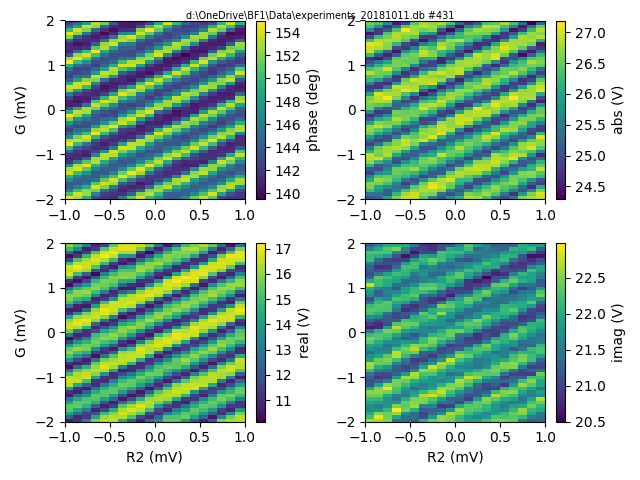

In [1487]:
run_id = 431



data = DataSetDict(run_id=run_id)


ret_mag = dict(data.get_grid('detector_signal_abs'))
ret_real = dict(data.get_grid('detector_signal_real'))
ret_imag = dict(data.get_grid('detector_signal_imag'))
ret_phi = dict(data.get_grid('detector_signal_phase'))

pg = ret_mag["ivvi_setup_G_fine_voltage"]["values"]
r2 = ret_mag["ivvi_setup_R2_voltage"]["values"]

mag = np.ma.getdata(ret_mag['detector_signal_abs']['values'])[:,:,0,1]
real = np.ma.getdata(ret_real['detector_signal_real']['values'])[:,:,0,1]
imag = np.ma.getdata(ret_imag['detector_signal_imag']['values'])[:,:,0,1]
phi = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0,1]
phi_ref = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0,0]

fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2,2)

cphase = (phi-phi_ref).T%360

im1 = ax1.pcolor(r2*1e3, pg*1e3,  (phi-phi_ref).T%360)
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("G (mV)")
cb1.set_label('phase (deg)')

im2 = ax2.pcolor(r2*1e3, pg*1e3,  mag.T)
cb2 = fig.colorbar(im2, ax=ax2)
cb2.set_label('abs (V)')

im3 = ax3.pcolor(r2*1e3, pg*1e3,  real.T)
cb3 = fig.colorbar(im3, ax=ax3)
ax3.set_xlabel('R2 (mV)')
ax3.set_ylabel("G (mV)")
cb3.set_label('real (V)')

im4 = ax4.pcolor(r2*1e3, pg*1e3,  imag.T)
cb4 = fig.colorbar(im4, ax=ax4)
ax4.set_xlabel('R2 (mV)')
cb4.set_label('imag (V)')


fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()



C:\Users\Administrator\Anaconda3\envs\qcodes\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


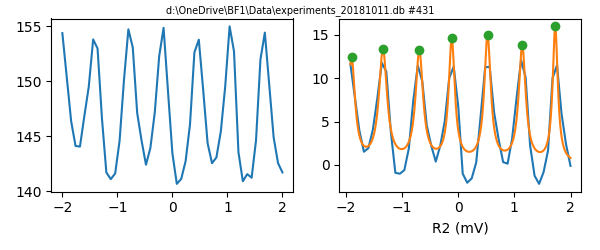

In [1480]:
ymax = len(pg)
i = 1

x = r2*1e3
y = pg[0:ymax]*1e3
z = cphase
z = z[0:ymax,:]

D = []
X = []

xt = y[1:]
zt = z[:,1][1:]-min(z[i,:][1:])

xfit = np.linspace(min(xt), max(xt), 1001)

maxtab, mintab = peakdet(zt, 2, xt)
xp = array(maxtab)[:,0]
yp = array(maxtab)[:,1]
# xp = np.append(xp, x[-1])
# yp = np.append(yp, y[-1])

guess = []
bound_min = []
bound_max = []
for i in range(len(xp)):
    guess += [xp[i], .1, .1] 
    bound_min += [min(xt), 0, 0] 
    bound_max += [max(xt), 10, 2] 
try:
    popt, pcov = curve_fit(fitfunc, xt, zt, p0=guess, bounds=(bound_min, bound_max))
except:
    popt, pcov = curve_fit(fitfunc, xt, zt, p0=guess2, bounds=(bound_min, bound_max))

fit = fitfunc(xfit, *popt)
guess2 = popt

maxtab, mintab = peakdet(fit, 3, xfit)
xp = array(maxtab)[::,0]
yp = array(maxtab)[::,1]

D.append(xp)
X.append(np.diff(xp))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2.5))

ax2.plot(xt, zt)
ax2.plot(xfit, fit)
ax2.plot(xp, yp, 'o')
ax2.set_xlabel('R2 (mV)')

ax1.plot(pg*1e3,cphase[:,0])

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

In [ ]:
1330/4/0.9

In [1481]:
p = np.diff(D[0])
e = p[0::2]
o = p[1::2]
print(p)
print((o+e)/4/0.72)
print((o-e)/4/0.72)

[ 0.56052247  0.64675669  0.57620142  0.63891722  0.61931853  0.58796063]
[ 0.41919415  0.42191619  0.41919415]
[ 0.02994244  0.02177632 -0.01088816]


C:\Users\Administrator\Anaconda3\envs\qcodes\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


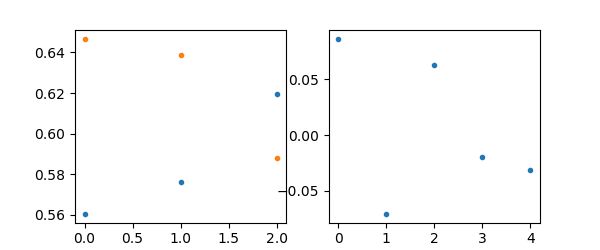

0.840203001506 27.2203996168


In [1482]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2.5))
ax1.plot(e, '.')
ax1.plot(o, '.')

ax2.plot(np.diff(p),'.')

gap = np.average((o - e[0:len(o)]))/2/0.72
ec = np.average((o + e[0:len(o)]))/2/0.72

print(ec, gap*1e3)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


C:\Users\Administrator\Anaconda3\envs\qcodes\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


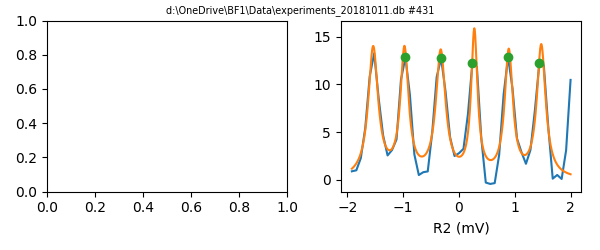

In [1488]:
ymax = len(pg)

x = r2*1e3
y = pg[0:ymax]*1e3
z = cphase
z = z[0:ymax,:]

D = []
X = []
xt = []
zt= []
for i in range(len(x)):
    print(i)
    xt = y[1:]
    zt = z[:,i][1:]-min(z[i,:][1:])

    xfit = np.linspace(min(xt), max(xt), 1001)

    maxtab, mintab = peakdet(zt, 3, xt)
    xp = array(maxtab)[:,0]
    yp = array(maxtab)[:,1]
#     xp = np.append(xp, x[-1])
#     yp = np.append(yp, y[-1])

    guess = []
    bound_min = []
    bound_max = []
    for i in range(len(xp)):
        guess += [xp[i], 0.1, 0.1] 
        bound_min += [min(y), 0, 0] 
        bound_max += [max(y), 10, 2] 
    try:
        popt, pcov = curve_fit(fitfunc, xt, zt, p0=guess, bounds=(bound_min, bound_max))
    except:
        popt, pcov = curve_fit(fitfunc, xt, zt, p0=guess2, bounds=(bound_min, bound_max))

    fit = fitfunc(xfit, *popt)
    guess2 = popt

#     maxtab, mintab = peakdet(fit, 1, xfit)
    xp = array(maxtab)[1::,0]
    yp = array(maxtab)[1::,1]

    D.append(xp)
    X.append(np.diff(xp))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2.5))

ax2.plot(xt, zt)
ax2.plot(xfit, fit)
ax2.plot(xp, yp, 'o')
ax2.set_xlabel('R2 (mV)')



fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

In [1489]:
ec = []
gap = []

for i in range(len(X)):
    e = X[i][0::2]
    o = X[i][1::2]


    ec.append((o+e)/4/0.72)
    gap.append(abs(o-e)/4/0.72)
    
gap = np.concatenate(gap)
ec = np.concatenate(ec)

ValueError: operands could not be broadcast together with shapes (2,) (3,) 

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2.5))

ax1.plot(gap, '.-')
ax2.plot(ec, '.-')


fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

C:\Users\Administrator\Anaconda3\envs\qcodes\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


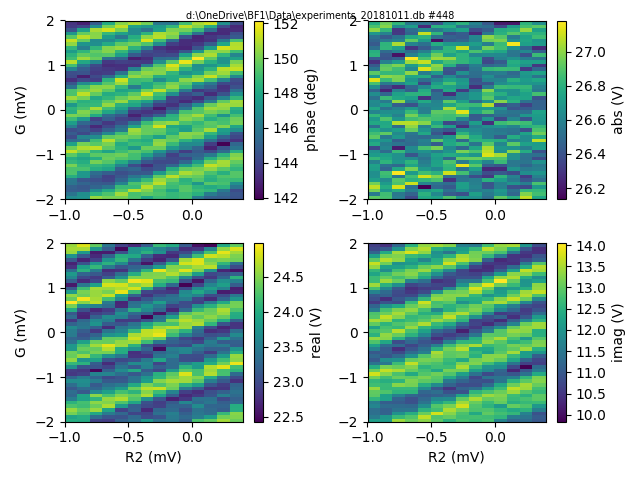

C:\Users\Administrator\Anaconda3\envs\qcodes\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in remainder
C:\Users\Administrator\Anaconda3\envs\qcodes\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in remainder


In [1604]:
run_id = 448



data = DataSetDict(run_id=run_id)


ret_mag = dict(data.get_grid('detector_signal_abs'))
ret_real = dict(data.get_grid('detector_signal_real'))
ret_imag = dict(data.get_grid('detector_signal_imag'))
ret_phi = dict(data.get_grid('detector_signal_phase'))

pg = ret_mag["ivvi_setup_G_fine_voltage"]["values"]
r2 = ret_mag["ivvi_setup_R2_voltage"]["values"]

mag = np.ma.getdata(ret_mag['detector_signal_abs']['values'])[:,:,0,1]
real = np.ma.getdata(ret_real['detector_signal_real']['values'])[:,:,0,1]
imag = np.ma.getdata(ret_imag['detector_signal_imag']['values'])[:,:,0,1]
phi = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0,1]
phi_ref = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0,0]

fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2,2)

cphase = (phi-phi_ref).T%360

im1 = ax1.pcolor(r2*1e3, pg*1e3,  (phi-phi_ref).T%360)
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("G (mV)")
cb1.set_label('phase (deg)')

im2 = ax2.pcolor(r2*1e3, pg*1e3,  mag.T)
cb2 = fig.colorbar(im2, ax=ax2)
cb2.set_label('abs (V)')

im3 = ax3.pcolor(r2*1e3, pg*1e3,  real.T)
cb3 = fig.colorbar(im3, ax=ax3)
ax3.set_xlabel('R2 (mV)')
ax3.set_ylabel("G (mV)")
cb3.set_label('real (V)')

im4 = ax4.pcolor(r2*1e3, pg*1e3,  imag.T)
cb4 = fig.colorbar(im4, ax=ax4)
ax4.set_xlabel('R2 (mV)')
cb4.set_label('imag (V)')


fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()



C:\Users\Administrator\Anaconda3\envs\qcodes\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


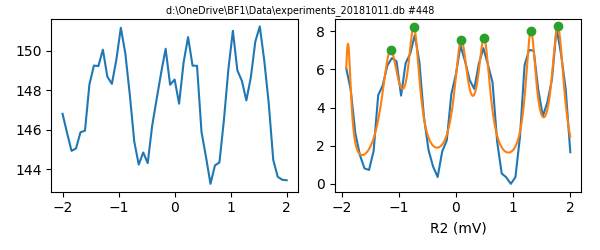

In [1606]:
ymax = len(r2)
i = 3

x = pg*1e3
y = r2[0:ymax]
z = cphase
z = z[:,0:ymax]

D = []
X = []

xt = x[1:]
zt = z[:,i][1:]-min(z[:,i][1:])

xfit = np.linspace(min(xt), max(xt), 1001)

maxtab, mintab = peakdet(zt, 1, xt)
xp = array(maxtab)[:,0]
yp = array(maxtab)[:,1]
# xp = np.append(xp, x[-1])
# yp = np.append(yp, y[-1])

guess = []
bound_min = []
bound_max = []
for i in range(len(xp)):
    guess += [xp[i], .1, .1] 
    bound_min += [min(x), 0, 0] 
    bound_max += [max(x), 10, 2] 
try:
    popt, pcov = curve_fit(fitfunc, xt, zt, p0=guess, bounds=(bound_min, bound_max))
except:
    popt, pcov = curve_fit(fitfunc, xt, zt, p0=guess2, bounds=(bound_min, bound_max))

fit = fitfunc(xfit, *popt)
guess2 = popt

maxtab, mintab = peakdet(fit, 1, xfit)
xp = array(maxtab)[1::,0]
yp = array(maxtab)[1::,1]

D.append(xp)
X.append(np.diff(xp))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2.5))

ax2.plot(xt, zt)
ax2.plot(xfit, fit)
ax2.plot(xp, yp, 'o')
ax2.set_xlabel('R2 (mV)')

ax1.plot(pg*1e3,cphase[:,0])

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

In [1608]:
p = np.diff(D[0])
e = p[0::2]
o = p[1::2]
print(p)
print((o[0:min(len(o),len(e))]+e[0:min(len(o),len(e))])/4/0.9)
print(abs(o[0:min(len(o),len(e))]-e[0:min(len(o),len(e))])/4/0.9)

[ 0.39981323  0.8349041   0.39589349  0.81922515  0.47036851]
[ 0.34297704  0.33753296]
[ 0.12085857  0.11759213]


In [1612]:
ymax = len(r2)

x = pg*1e3
y = r2[0:ymax]
z = cphase
z = z[:,0:ymax]

D = []
X = []
xt = []
zt= []
for i in range(len(y)):
    print(i)
    xt = x[1:]
    zt = z[:,i][1:]-min(z[:,i][1:])

    xfit = np.linspace(min(xt), max(xt), 1001)

    maxtab, mintab = peakdet(zt, 1, xt)
    xp = array(maxtab)[:,0]
    yp = array(maxtab)[:,1]
#     xp = np.append(xp, x[-1])
#     yp = np.append(yp, y[-1])

    guess = []
    bound_min = []
    bound_max = []
    for i in range(len(xp)):
        guess += [xp[i], 0.1, 0.5] 
        bound_min += [min(x), 0, 0] 
        bound_max += [max(x), 10, 2] 
    try:
        popt, pcov = curve_fit(fitfunc, xt, zt, p0=guess, bounds=(bound_min, bound_max))
    except:
        popt, pcov = curve_fit(fitfunc, xt, zt, p0=guess2, bounds=(bound_min, bound_max))

    fit = fitfunc(xfit, *popt)
    guess2 = popt

    maxtab, mintab = peakdet(fit, 1, xfit)
    xp = array(maxtab)[1::,0]
    yp = array(maxtab)[1::,1]

    D.append(xp)
    X.append(np.diff(xp))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2.5))

ax2.plot(xt, zt)
ax2.plot(xfit, fit)
ax2.plot(xp, yp, 'o')
ax2.set_xlabel('R2 (mV)')



fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


IndexError: too many indices for array

In [1613]:
ec = []
gap = []

for i in range(len(X)):
    if X[i][0]>X[i][1]:
        e = X[i][0::2]
        o = X[i][1::2]
    else:
        e = X[i][1::2]
        o = X[i][0::2]


    ec.append((o[0:min(len(o),len(e))]+e[0:min(len(o),len(e))])*1e3/4/0.9)
    gap.append(abs(o[0:min(len(o),len(e))]-e[0:min(len(o),len(e))])*1e3/4/0.9)

ec = np.concatenate(ec)
gap = np.concatenate(gap)
# E = []
# delta = []    
# for i in range(len(X)):
#     E.append(np.average(ec[i]))
#     delta.append(np.average(gap[i]))
    
# E = np.array(E)
# delta = np.array(gap)

C:\Users\Administrator\Anaconda3\envs\qcodes\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


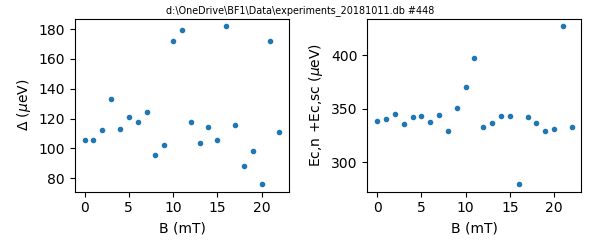

In [1614]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2.5))

ax1.plot(gap, '.')
ax1.set_ylabel(r'$\Delta$ ($\mu$eV)')
ax1.set_xlabel("B (mT)")
ax2.plot(ec, '.')
ax2.set_ylabel(r'Ec,n +Ec,sc ($\mu$eV)')
ax2.set_xlabel("B (mT)")
fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

# c

In [1412]:
qc.config['core']['db_location'] = r"d:/OneDrive/BF1/Data/experiments_20181011.db"
# qc.config['core']['db_location'] = r"d:/OneDrive/BF1/Data/experiments_20180916.db"

C:\Users\Administrator\Anaconda3\envs\qcodes\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


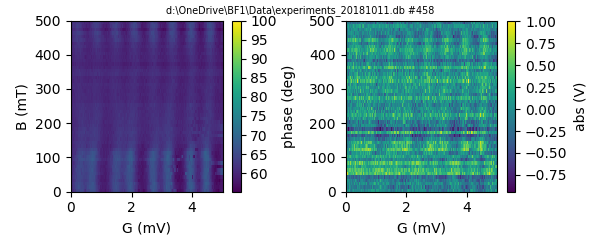

(51, 251)


In [1709]:
run_id = 458

data = DataSetDict(run_id=run_id)


ret_mag = dict(data.get_grid('detector_signal_abs'))
ret_real = dict(data.get_grid('detector_signal_real'))
ret_imag = dict(data.get_grid('detector_signal_imag'))
ret_phi = dict(data.get_grid('detector_signal_phase'))

B = ret_mag["AMI430_field"]["values"]
pg = ret_mag["ivvi_setup_G_fine_voltage"]["values"]

mag = np.ma.getdata(ret_mag['detector_signal_abs']['values'])[:,:,0,1]
real = np.ma.getdata(ret_real['detector_signal_real']['values'])[:,:,0,1]
imag = np.ma.getdata(ret_imag['detector_signal_imag']['values'])[:,:,0,1]
phi = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0,1]
phi_ref = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0,0]

fig, ((ax1, ax2)) = plt.subplots(
    1,2, figsize=(6,2.5))

cphase = ((phi-phi_ref)).T
cphase= (cphase.T - cphase[:,0]).T


im1 = ax1.pcolor(pg*1e3, B*1e3,  (cphase-300)%360,vmax=100)
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("B (mT)")
ax1.set_xlabel("G (mV)")
cb1.set_label('phase (deg)')

im2 = ax2.pcolor(pg*1e3, B*1e3,  (mag-mag.T[:,-1]).T)
cb2 = fig.colorbar(im2, ax=ax2)
cb2.set_label('abs (V)')
ax2.set_xlabel("G (mV)")

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

print(cphase.shape)

C:\Users\Administrator\Anaconda3\envs\qcodes\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


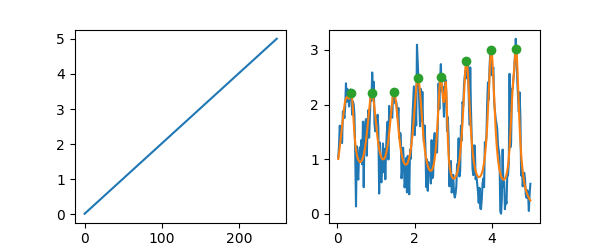

In [1741]:
ymax = len(B)
i = 39
x = pg*1e3
y = B[0:ymax]
z = (cphase-300)%360
z = z[0:ymax,:]

D = []
X = []

xt = x[1:]
zt = z[i,:][1:]-min(z[i,:][1:])

xfit = np.linspace(min(xt), max(xt), 1001)

maxtab, mintab = peakdet(zt, 1, xt)
xp = array(maxtab)[:,0]
yp = array(maxtab)[:,1]
# xp = np.append(xp, x[-1])
# yp = np.append(yp, y[-1])

guess = []
bound_min = []
bound_max = []
for i in range(len(xp)):
    guess += [xp[i], .5, .5] 
    bound_min += [min(x), 0, 0] 
    bound_max += [max(x), 10, 2] 
try:
    popt, pcov = curve_fit(fitfunc, xt, zt, p0=guess, bounds=(bound_min, bound_max))
except:
    popt, pcov = curve_fit(fitfunc, xt, zt, p0=guess2, bounds=(bound_min, bound_max))

fit = fitfunc(xfit, *popt)
guess2 = popt

maxtab, mintab = peakdet(fit, 0.5, xfit)
xp = array(maxtab)[0::,0]
yp = array(maxtab)[0::,1]

D.append(xp)
X.append(np.diff(xp))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2.5))

ax1.plot(xt)

ax2.plot(xt, zt)
ax2.plot(xfit, fit)
ax2.plot(xp, yp, 'o')
ax2.set_xlabel('G (mV)')

# ax1.plot(pg*1e3,cphase[:,0])

# fig.suptitle(ds_title(str(run_id)), size='x-small')
# fig.tight_layout()

In [1734]:
p = np.diff(D[0])
e = p[0::2]
o = p[1::2]
print(p)
print(np.average((o+e)/4/0.85))
print(np.average(abs(o-e)/4/0.85))

[ 0.6224918   0.60257206  0.62747173  0.61751186  0.6224918   0.62747173
  0.607552  ]


ValueError: operands could not be broadcast together with shapes (3,) (4,) 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


C:\Users\Administrator\Anaconda3\envs\qcodes\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


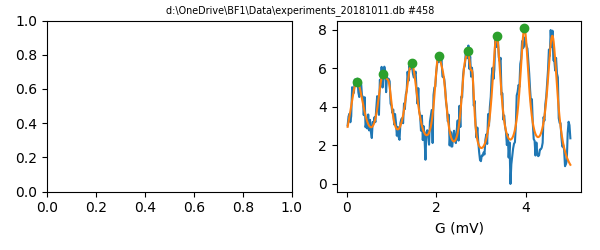

In [1742]:
ymax = len(B)
i = 0

x = pg*1e3
y = B[0:ymax]
z = (cphase-300)%360
z = z[0:ymax,:]

D = []
X = []
B_idx = []
xt = []
zt= []
for i in range(0,len(y)):
    if i==144 or i==145:
        B_idx.append(False)
        pass
    else:
        
        print(i)
        xt = x[1:]
        zt = z[i,:][1:]-min(z[i,:][1:])

        xfit = np.linspace(min(xt), max(xt), 1001)

        maxtab, mintab = peakdet(zt, 1, xt)
        xp = array(maxtab)[:,0]
        yp = array(maxtab)[:,1]
    #     xp = np.append(xp, x[-1])
    #     yp = np.append(yp, y[-1])

        guess = []
        bound_min = []
        bound_max = []
        for i in range(len(xp)):
            guess += [xp[i], 0.5, 0.5] 
            bound_min += [min(x), 0, 0] 
            bound_max += [max(x), 10, 2] 
        try:
            popt, pcov = curve_fit(fitfunc, xt, zt, p0=guess, bounds=(bound_min, bound_max))
        except:
            popt, pcov = curve_fit(fitfunc, xt, zt, p0=guess2, bounds=(bound_min, bound_max))

        fit = fitfunc(xfit, *popt)
        guess2 = popt

        maxtab, mintab = peakdet(fit, 0.5, xfit)
        xp = array(maxtab)[0:7,0]
        yp = array(maxtab)[0:7,1]

        D.append(xp)
        X.append(np.diff(xp))
        B_idx.append(True)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2.5))

ax2.plot(xt, zt)
ax2.plot(xfit, fit)
ax2.plot(xp, yp, 'o')
ax2.set_xlabel('G (mV)')



fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

In [1743]:
for i,q in enumerate(X):
    print(i,q)

0 [ 0.11951843  0.42827436  0.88642832  0.37349508  0.7669099   0.45815396]
1 [ 0.41831449  0.81670924  0.45815396  0.77188983  0.44321416  0.79180957]
2 [ 0.42827436  0.79180957  0.51791318  0.74201022  0.45815396  0.74699016]
3 [ 0.42329442  0.77686976  0.4631339   0.80176944  0.51293324  0.70217075]
4 [ 0.40835462  0.80674937  0.43823423  0.77686976  0.44321416  0.11951843]
5 [ 0.38843488  0.83662898  0.42329442  0.77686976  0.4930135   0.72707042]
6 [ 0.40835462  0.81670924  0.43823423  0.7967895   0.51293324  0.16433783]
7 [ 0.39341482  0.79180957  0.44321416  0.72707042  0.50297337  0.22409705]
8 [ 0.34361547  0.84658885  0.42827436  0.75695003  0.48803357  0.75197009]
9 [ 0.36851514  0.85654871  0.38345495  0.7669099   0.43325429  0.68225101]
10 [ 0.38843488  0.82168917  0.42827436  0.77188983  0.4631339   0.66233127]
11 [ 0.37847501  0.79180957  0.42827436  0.76192996  0.52787304  0.61751186]
12 [ 0.39839475  0.82666911  0.41333455  0.7967895   0.44819409  0.73205035]
13 [ 0.42

In [1744]:
ec = []
gap = []

for i in range(0,len(X)):

    if X[i][0]>X[i][1]:
        e = X[i][0::2]
        o = X[i][1::2]
    else:
        e = X[i][1::2]
        o = X[i][0::2]


    ec.append((o[0:min(len(o),len(e))]+e[0:min(len(o),len(e))])*1e3/4/0.9)
    gap.append(abs(o[0:min(len(o),len(e))]-e[0:min(len(o),len(e))])*1e3/4/0.9)

# ec = np.concatenate(ec)
# gap = np.concatenate(gap)
E = []
delta = []    
for i in range(1,len(X)):
    E.append(np.average(ec[i]))
    delta.append(np.average(gap[i]))
    
# E = np.array(E)
# delta = np.array(gap)

In [1745]:
print(len(delta))
len(B)


50


51

In [1751]:
# B_458 = B[1::]
# delta_458 = delta

C:\Users\Administrator\Anaconda3\envs\qcodes\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


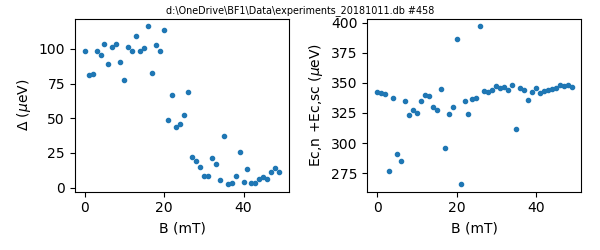

In [1748]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2.5))

ax1.plot(delta, '.')
ax1.set_ylabel(r'$\Delta$ ($\mu$eV)')
ax1.set_xlabel("B (mT)")
# ax1.set_ylim([0,70])
ax2.plot(E, '.')
ax2.set_ylabel(r'Ec,n +Ec,sc ($\mu$eV)')
ax2.set_xlabel("B (mT)")
fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

<IPython.core.display.Javascript object>


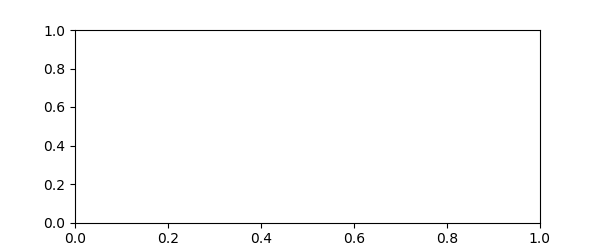

NameError: name 'B_408' is not defined

In [454]:
fig, ax1 = plt.subplots(1,1, figsize=(6,2.5))

ax1.plot(B_408*1e3,delta_408, '.', label = "G = -0.3 V")
ax1.plot(B_403*1e3,delta_403, '.', label = "-0.3 V")
ax1.plot(B_458*1e3,delta_458, '.', label = "-0.35 V")
ax1.plot(B_310*1e3,delta_310, '.', label = "-0.4 V")
ax1.plot(B_483*1e3,delta_483, '.', label = "-0.5 V")
ax1.set_ylabel(r'$\Delta$ ($\mu$eV)')
ax1.set_xlabel("B (mT)")
ax1.set_ylim([0,150])
plt.legend(loc=1)



fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

In [1378]:
(75/0.2)*2/58

12.931034482758621

In [1350]:
qc.config['core']['db_location'] = r"d:/OneDrive/BF1/Data/experiments_20181011.db"

# d

<IPython.core.display.Javascript object>


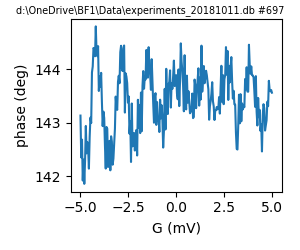

251

In [219]:
run_id = 697

data = DataSetDict(run_id=run_id)
ret_phi = dict(data.get_grid('detector_signal_phase'))

pg = ret_phi["ivvi_setup_G_fine_voltage"]["values"]
phi = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,0,1]
phi_ref = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,0,0]

fig, (ax1) = plt.subplots(1,1, figsize=(3,2.5))

im1 = ax1.plot(pg*1e3,(phi-phi_ref).T%360)
ax1.set_ylabel('phase (deg)')

ax1.set_xlabel('G (mV)')


fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

pg.size

In [204]:
np.linspace(0, 0.5, 6)

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5])

<IPython.core.display.Javascript object>


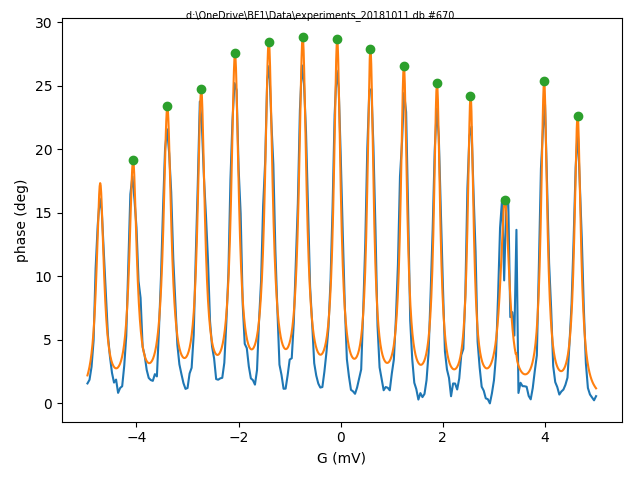

In [206]:


x = pg*1e3
z = (phi-phi_ref).T%360

D = []
X = []

xt = x[1:]
zt = z[1:]-min(z[1:])

xfit = np.linspace(min(xt), max(xt), 1001)

maxtab, mintab = peakdet(zt, 3, xt)
xp = array(maxtab)[:,0]
yp = array(maxtab)[:,1]
# xp = np.append(xp, x[-1])
# yp = np.append(yp, y[-1])

guess = []
bound_min = []
bound_max = []
for i in range(len(xp)):
    guess += [xp[i], .1, .1] 
    bound_min += [min(x), 0, 0] 
    bound_max += [max(x), 3, 2] 
try:
    popt, pcov = curve_fit(fitfunc, xt, zt, p0=guess, bounds=(bound_min, bound_max))
except:
    popt, pcov = curve_fit(fitfunc, xt, zt, p0=guess2, bounds=(bound_min, bound_max))

fit = fitfunc(xfit, *popt)
guess2 = popt

maxtab, mintab = peakdet(fit, 1, xfit)
xp = array(maxtab)[1::,0]
yp = array(maxtab)[1::,1]

D.append(xp)
X.append(np.diff(xp))

fig, (ax2) = plt.subplots(1,1)#, figsize=(3,2.5))

# ax1.plot(xt)

ax2.plot(xt, zt)
ax2.plot(xfit, fit)
ax2.plot(xp, yp, 'o')
ax2.set_xlabel('G (mV)')
ax2.set_ylabel('phase (deg)')
ax2.set_xlabel('G (mV)')
# ax1.plot(pg*1e3,cphase[:,0])

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

In [1861]:
p = np.diff(D[0])
e = p[0::2]
o = p[1::2]
ec = (o[0:min(len(o),len(e))]+e[0:min(len(o),len(e))])*1e3/4/0.85
gap =abs(o[0:min(len(o),len(e))]-e[0:min(len(o),len(e))])*1e3/4/0.85

print(ec, gap)

[ 377.88913872  374.95976555  377.88913872  377.88913872  380.81851189
  372.03039238  369.10101921] [ 108.38680723  117.17492673  114.24555357   96.66931456   82.02244871
   90.81056822  105.45743406]


In [1842]:
np.linspace(25e-3, 250e-3, 10)

array([ 0.025,  0.05 ,  0.075,  0.1  ,  0.125,  0.15 ,  0.175,  0.2  ,
        0.225,  0.25 ])

In [430]:
qc.config['core']['db_location'] = r"d:/OneDrive/BF1/Data/experiments_20180916.db"

In [431]:
for run_id in range(431,202,1):
    print(run_id)

In [432]:
C0 = []
T_idx = []
for run_id in range(511,554,1):
    if run_id == 124:
        T_idx.append(False)
        pass
    else:
        run_id = run_id

        data = DataSetDict(run_id=run_id)
        ret_phi = dict(data.get_grid('detector_signal_phase'))

        pg = ret_phi["ivvi_setup_G_fine_voltage"]["values"]
        phi = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,0,1]
        phi_ref = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,0,0]


        cphase = (phi-phi_ref)%360

        c0 = cphase-min(cphase)
        C0.append(c0)
        T_idx.append(True)

In [433]:
T_idx

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

<IPython.core.display.Javascript object>


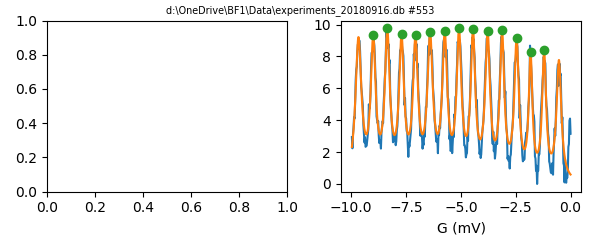

In [434]:
x = pg*1e3

D = []
X = []

xt = []
zt= []
for i in range(len(C0)):
#     print(i)
    xt = x[1:]
    zt = C0[i][1:]
    
    xfit = np.linspace(min(xt), max(xt), 1001)

    maxtab, mintab = peakdet(zt, 3, xt)
    xp = array(maxtab)[:,0]
    yp = array(maxtab)[:,1]
#     xp = np.append(xp, x[-1])
#     yp = np.append(yp, y[-1])

    guess = []
    bound_min = []
    bound_max = []
    for i in range(len(xp)):
        guess += [xp[i], 0.5, 0.5] 
        bound_min += [min(x), 0, 0] 
        bound_max += [max(x), 3, 2] 
    try:
        popt, pcov = curve_fit(fitfunc, xt, zt, p0=guess, bounds=(bound_min, bound_max))
    except:
        popt, pcov = curve_fit(fitfunc, xt, zt, p0=guess2, bounds=(bound_min, bound_max))

    fit = fitfunc(xfit, *popt)
    guess2 = popt

    maxtab, mintab = peakdet(fit, 0.5, xfit)
    xp = array(maxtab)[1:-1,0]
    yp = array(maxtab)[1:-1,1]

    D.append(xp)
    X.append(np.diff(xp))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2.5))

ax2.plot(xt, zt)
ax2.plot(xfit, fit)
ax2.plot(xp, yp, 'o')
ax2.set_xlabel('G (mV)')



fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()


In [435]:
ec = []
gap = []

for i in range(len(X)):
    if X[i][0]>X[i][1]:
        e = X[i][0::2]
        o = X[i][1::2]
    else:
        e = X[i][1::2]
        o = X[i][0::2]


    ec.append((o[0:min(len(o),len(e))]+e[0:min(len(o),len(e))])*1e3/4/0.9)
    gap.append(abs(o[0:min(len(o),len(e))]-e[0:min(len(o),len(e))])*1e3/4/0.9)

print(gap)
# ec = np.concatenate(ec)
# gap = np.concatenate(gap)
E = []
delta = []    
for i in range(len(X)):
    E.append(np.average(ec[i]))
    delta.append(np.average(gap[i]))
    
E = np.array(E)
delta = np.array(delta)

[array([ 124.68909743,  113.6056221 ,  127.45996626,  116.37649093,
        130.23083509,  105.29301561]), array([ 124.68909743,  127.45996626,  130.23083509,  121.9182286 ,
        127.45996626,  124.68909743]), array([ 113.6056221 ,  119.14735977,  124.68909743,  133.00170392,
        124.68909743,  121.9182286 ]), array([ 124.68909743,  119.14735977,  124.68909743,  130.23083509,
        127.45996626,  113.6056221 ]), array([ 113.6056221 ,  113.6056221 ,  130.23083509,  130.23083509,
        135.77257276,  135.77257276]), array([ 119.14735977,  119.14735977,  124.68909743,  130.23083509,
        138.54344159,  110.83475327]), array([ 113.6056221 ,  116.37649093,  127.45996626,  133.00170392,
        130.23083509,  105.29301561]), array([ 116.37649093,  121.9182286 ,  119.14735977,  133.00170392,
        135.77257276,  119.14735977]), array([ 113.6056221 ,  121.9182286 ,  124.68909743,  127.45996626,
        130.23083509,  127.45996626]), array([ 113.6056221 ,  119.14735977,  133.001

In [436]:
# T = np.array([20,30])*1e-3
# T300 = np.linspace(25e-3, 450e-3, 11)
# T = np.linspace(20e-3, 440e-3, 43)
T = np.linspace(25e-3, 450e-3, 18)
temp_all = np.linspace(25e-3, 450e-3, 18)
T = np.linspace(20e-3, 440e-3, 43)

In [437]:
# data_300 = delta
# temp_0 = T[T_idx]
# T = T[T_idx]


<IPython.core.display.Javascript object>


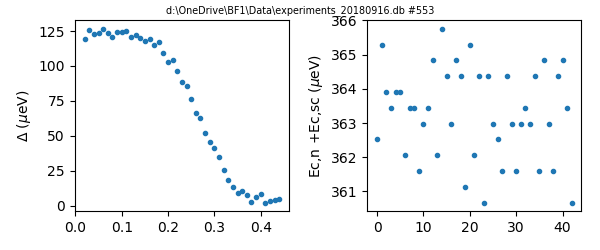

In [438]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2.5))
ax1.plot(T,delta, '.')
# ax1.plot(delta, '.')
ax1.set_ylabel(r'$\Delta$ ($\mu$eV)')
# ax1.set_xlabel("B (mT)")
ax2.plot(E, '.')
ax2.set_ylabel(r'Ec,n +Ec,sc ($\mu$eV)')
# ax2.set_xlabel("B (mT)")
fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

In [439]:
from scipy.special import yn, kn

In [440]:
def free_energy(T, delta, E0):
    k = 86
    pal = 23e-6
    val = 10e4
    Neff = pal*val*np.sqrt(2*np.pi*k*T*delta)
    return -k*T*np.log(Neff*np.exp(-delta/(k*T))+2*np.exp(-E0/(k*T)))

def free_energy_exact(T, delta, E0):
    val = 1.5e5
    k = 86
    pal = 23e-6
    return -k*T*np.log(np.tanh(2*pal*val*delta*kn(1,delta/(k*T))+np.log(1/(np.tanh(E0/(2*k*T))))))

def free_energy_exact_induced(T, delta1, delta2):
    val = 1e5
    k = 86
    pal = 23e-6
    vas = 1e2
    pas = 1e-2
    return -k*T*np.log(np.tanh(2*pal*val*delta1*kn(1,delta1/(k*T)) + 2*pas*vas*delta2*kn(1,delta2/(k*T))))

def free_energy_delta(T, delta, E0):
    val = 1.5e6
    k = 86
    pal = 23e-6
    E0 =delta
    return -k*T*np.log(np.tanh(2*pal*val*delta*kn(1,delta/(k*T))+np.log(1/(np.tanh(E0/(2*k*T))))))

def free_energy_exact_val(T, delta, E0, val):
    k = 86
    pal = 23e-6
    return -k*T*np.log(np.tanh(2*pal*val*delta*kn(1,delta/(k*T))+np.log(1/(np.tanh(E0/(2*k*T))))))

def free_energy_exact_Tel(Tf, Tel, delta, E0):
    T = np.sqrt(Tel**2+Tf**2)
#     T = (Tel**5+Tf**5)**0.2
    val = 5e5
    k = 86
    pal = 23e-6
    return -k*T*np.log(np.tanh(2*pal*val*delta*kn(1,delta/(k*T))+np.log(1/(np.tanh(E0/(2*k*T))))))

def free_energy_exact_Tel_nosg(Tf, Tel, delta):
    T = np.sqrt(Tel**2+Tf**2)
    val = 1.5e6
    k = 86
    pal = 23e-6
    return -k*T*np.log(np.tanh(2*pal*val*delta*kn(1,delta/(k*T))))

<IPython.core.display.Javascript object>


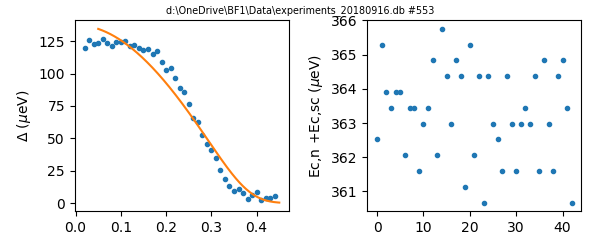

0.347022906062 411.875269782


In [441]:
Tfit = np.linspace(50e-3, 450e-3, 1000)
Ffit = free_energy_exact(Tfit, 200, 130)

guess     = [150e-3,100] 
bound_min = [10e-3,100] 
bound_max = [500e-3,1000] 

popt, pcov = curve_fit(free_energy_exact_Tel_nosg, T, delta, p0=guess, bounds=(bound_min, bound_max))

Ffit = free_energy_exact_Tel_nosg(Tfit, *popt)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2.5))
ax1.plot(T,delta, '.')
ax1.plot(Tfit,Ffit)
# ax1.plot(delta, '.')
ax1.set_ylabel(r'$\Delta$ ($\mu$eV)')
# ax1.set_xlabel("B (mT)")
ax2.plot(E, '.')
ax2.set_ylabel(r'Ec,n +Ec,sc ($\mu$eV)')
# ax2.set_xlabel("B (mT)")
fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

print(*popt)

<IPython.core.display.Javascript object>


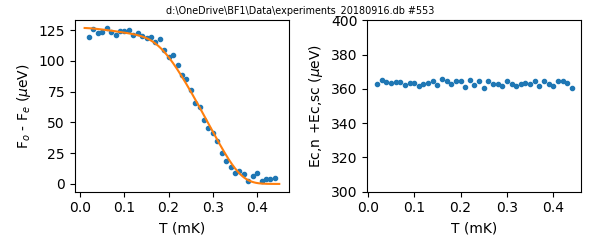

0.0461576932201 247.048703962 129.452263971


In [446]:
Tfit = np.linspace(10e-3, 450e-3, 1000)
Ffit = free_energy_exact(Tfit, 200, 130)

guess     = [50e-3, 200, delta[0]]
bound_min = [10e-3, 1, 1]
bound_max = [100e-3, 500, 500]

popt, pcov = curve_fit(free_energy_exact_Tel, T, delta, p0=guess, bounds=(bound_min, bound_max))

Ffit = free_energy_exact_Tel(Tfit, *popt)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2.5))
ax1.plot(T,delta, '.')
ax1.plot(Tfit,Ffit)
# ax1.plot(delta, '.')
ax1.set_ylabel(r'F$_o$ - F$_e$ ($\mu$eV)')
ax1.set_xlabel("T (mK)")

# Tfit = np.linspace(50e-3, 450e-3, 1000)
# Ffit = free_energy_exact(Tfit, 200, 130)

# guess     = [200, delta[0]]
# bound_min = [1, 1]
# bound_max = [300, 300]

# popt, pcov = curve_fit(free_energy_exact, T, delta, p0=guess, bounds=(bound_min, bound_max))
# Ffit = free_energy_exact(Tfit, *popt)

# ax1.plot(Tfit,Ffit)

ax2.plot(T, E, '.')
ax2.set_ylabel(r'Ec,n +Ec,sc ($\mu$eV)')
ax2.set_xlabel("T (mK)")
fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()
ax2.set_ylim([300,400])

print(*popt)

<IPython.core.display.Javascript object>


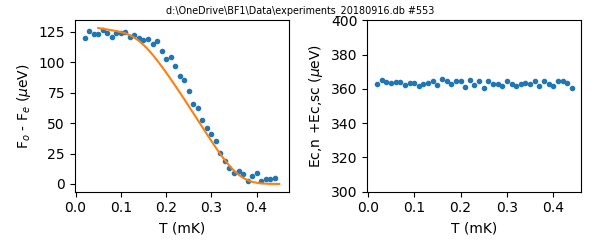

203.261637271 131.141346854


In [447]:
Tfit = np.linspace(50e-3, 450e-3, 1000)
Ffit = free_energy_exact(Tfit, 200, 130)

guess     = [200, delta[0]]
bound_min = [1, 1]
bound_max = [300, 300]

popt, pcov = curve_fit(free_energy_exact, T, delta, p0=guess, bounds=(bound_min, bound_max))

Ffit = free_energy_exact(Tfit, *popt)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2.5))
ax1.plot(T,delta, '.')
ax1.plot(Tfit,Ffit)
# ax1.plot(delta, '.')
ax1.set_ylabel(r'F$_o$ - F$_e$ ($\mu$eV)')
ax1.set_xlabel("T (mK)")

ax2.plot(T, E, '.')
ax2.set_ylabel(r'Ec,n +Ec,sc ($\mu$eV)')
ax2.set_xlabel("T (mK)")
fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()
ax2.set_ylim([300,400])

print(*popt)

<IPython.core.display.Javascript object>


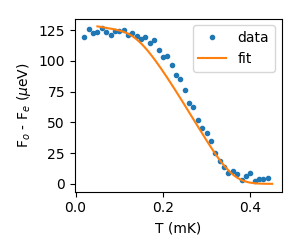

203.261637271 131.141346854


In [453]:
Tfit = np.linspace(50e-3, 450e-3, 1000)
Ffit = free_energy_exact(Tfit, 200, 130)

guess     = [200, delta[0]]
bound_min = [1, 1]
bound_max = [300, 300]

popt, pcov = curve_fit(free_energy_exact, T, delta, p0=guess, bounds=(bound_min, bound_max))

Ffit = free_energy_exact(Tfit, *popt)

fig, ax1 = plt.subplots(1,1, figsize=(3,2.5))
ax1.plot(T,delta, '.', label="data")
ax1.plot(Tfit,Ffit, label="fit")
# ax1.plot(delta, '.')
ax1.set_ylabel(r'F$_o$ - F$_e$ ($\mu$eV)')
ax1.set_xlabel("T (mK)")
plt.legend()

# ax2.plot(T, E, '.')
# ax2.set_ylabel(r'Ec,n +Ec,sc ($\mu$eV)')
# ax2.set_xlabel("T (mK)")
# fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()
# ax2.set_ylim([300,400])

print(*popt)

<IPython.core.display.Javascript object>


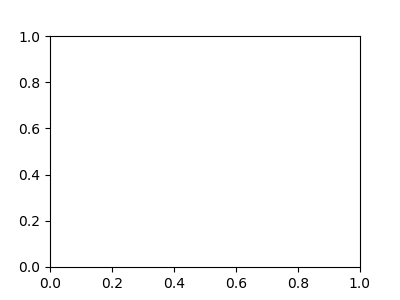

NameError: name 'data_0' is not defined

In [241]:
Tfit = np.linspace(10e-3, 450e-3, 1000)

guess     = [150e-3, 200, 130]
bound_min = [50e-3, 200, 10]
bound_max = [1000e-3, 300, 140]

fig, ax1 = plt.subplots(1,1, figsize=(4,3))

guess     = [150e-3, 200, data_0[0]]
bound_min = [50e-3, 200, 10]
bound_max = [1000e-3, 300, 140]
popt, pcov = curve_fit(free_energy_exact_Tel, temp_0, data_0, p0=guess, bounds=(bound_min, bound_max))
Ffit = free_energy_exact_Tel(Tfit, *popt)
print('0')
print(popt)
ax1.plot(temp_0, data_0, '.', label = "B = 0 mT")
ax1.plot(Tfit, Ffit, color = 'k')

guess     = [150e-3, 200, data_50[0]]
bound_min = [50e-3, 200, 10]
bound_max = [1000e-3, 300, 140]
popt, pcov = curve_fit(free_energy_exact_Tel, temp_all, data_50, p0=guess, bounds=(bound_min, bound_max))
Ffit = free_energy_exact_Tel(Tfit, *popt)
print('50')
print(popt)
ax1.plot(temp_all, data_50, '.', label = "50 mT")
ax1.plot(Tfit, Ffit, color = 'k')

guess     = [150e-3, 200, data_150[0]]
bound_min = [50e-3, 200, 10]
bound_max = [1000e-3, 300, 140]
popt, pcov = curve_fit(free_energy_exact_Tel, temp_all, data_150, p0=guess, bounds=(bound_min, bound_max))
Ffit = free_energy_exact_Tel(Tfit, *popt)
print('150')
print(popt)
ax1.plot(temp_all, data_150, '.', label = "150 mT")
ax1.plot(Tfit, Ffit, color = 'k')

guess     = [50e-3, 290, data_200[0]]
bound_min = [10e-3, 200, 10]
bound_max = [1000e-3, 300, 140]
popt, pcov = curve_fit(free_energy_exact_Tel, temp_all, data_200, p0=guess, bounds=(bound_min, bound_max))
Ffit = free_energy_exact_Tel(Tfit, *popt)
print('200')
print(popt)
ax1.plot(temp_all, data_200, '.', label = "200 mT")
ax1.plot(Tfit, Ffit, color = 'k')

guess     = [150e-3, 290, data_250[0]]
bound_min = [10e-3, 200, 10]
bound_max = [1000e-3, 300, 180]
popt, pcov = curve_fit(free_energy_exact_Tel, temp_all, data_250, p0=guess, bounds=(bound_min, bound_max))
Ffit = free_energy_exact_Tel(Tfit, *popt)
print('250')
print(popt)
ax1.plot(temp_all, data_250, '.', label = "250 mT")
ax1.plot(Tfit, Ffit, color = 'k')


guess     = [50e-3, 100, data_300[0]]
bound_min = [40e-3, 100, 10]
bound_max = [1000e-3, 300, 140]
popt, pcov = curve_fit(free_energy_exact_Tel, temp_all, data_300, p0=guess, bounds=(bound_min, bound_max))
Ffit = free_energy_exact_Tel(Tfit, *popt)
print('300')
print(popt)
ax1.plot(temp_all, data_300, '.', label = '300 mT')
ax1.plot(Tfit, Ffit, color = 'k')

guess     = [50e-3, 250, data_350[0]]
bound_min = [10e-3, 200, 10]
bound_max = [1000e-3, 300, 140]
popt, pcov = curve_fit(free_energy_exact_Tel, temp_all, data_350, p0=guess, bounds=(bound_min, bound_max))
Ffit = free_energy_exact_Tel(Tfit, *popt)
print('350')
print(popt)
ax1.plot(temp_all, data_350, '.', label = '350 mT')
ax1.plot(Tfit, Ffit, color = 'k')

guess     = [50e-3, 250, data_350[0]]
bound_min = [10e-3, 200, 10]
bound_max = [1000e-3, 300, 140]
popt, pcov = curve_fit(free_energy_exact_Tel, temp_all, data_500, p0=guess, bounds=(bound_min, bound_max))
Ffit = free_energy_exact_Tel(Tfit, *popt)
print('500')
print(popt)
ax1.plot(temp_all, data_500, '.', label = '500 mT')
# ax1.plot(Tfit, Ffit, color = 'k')

ax1.set_ylabel(r'F$_o$ - F$_e$ ($\mu$eV)')
ax1.set_xlabel("T (mK)")
plt.legend(loc=0,frameon=True)

fig.tight_layout()

In [ ]:
Tfit = np.linspace(50e-3, 450e-3, 1000)
Ffit = free_energy_exact(Tfit, 200, 130)

tem = temp_0
dat = data_0

guess     = [50e-3, 200, dat[0]]
bound_min = [40e-3, 200, 10]
bound_max = [1000e-3, 300, 140]
popt, pcov = curve_fit(free_energy_exact_Tel, tem, dat, p0=guess, bounds=(bound_min, bound_max))

Ffit = free_energy_exact_Tel(Tfit, *popt)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2.5))
ax1.plot(tem,dat, '.')
ax1.plot(Tfit,Ffit)
# ax1.plot(delta, '.')
ax1.set_ylabel(r'$\Delta$ ($\mu$eV)')
# ax1.set_xlabel("B (mT)")
ax2.plot(E, '.')
ax2.set_ylabel(r'Ec,n +Ec,sc ($\mu$eV)')
# ax2.set_xlabel("B (mT)")
fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

print(*popt)

In [ ]:
Tfit = np.linspace(10e-3, 450e-3, 1000)
Ffit = free_energy_exact(Tfit, 200, 130)

guess     = [150e-3, 280, 130]
bound_min = [50e-3, 250, 10]
bound_max = [500e-3, 500, 500]

fig, ax1 = plt.subplots(1,1, figsize=(4,3))


T = np.linspace(20e-3, 440e-3, 43)
popt, pcov = curve_fit(free_energy_exact_Tel, T, D0, p0=guess, bounds=(bound_min, bound_max))
Ffit = free_energy_exact_Tel(Tfit, *popt)

ax1.plot(T,D0, '.', label = "B = 0 mT")
ax1.plot(Tfit,Ffit, color = 'k')
# ax1.plot(delta, '.')
ax1.set_ylabel(r'F$_o$ - F$_e$ ($\mu$eV)')
ax1.set_xlabel("T (mK)")
print('0')
print(popt)

T = np.linspace(25e-3, 450e-3, 11)
popt, pcov = curve_fit(free_energy_exact_Tel, T, D300, p0=guess, bounds=(bound_min, bound_max))
Ffit = free_energy_exact_Tel(Tfit, *popt)

ax1.plot(T,D300, '.', label = "B = 300 mT")
ax1.plot(Tfit,Ffit, color = 'k')
# ax1.plot(delta, '.')
ax1.set_ylabel(r'F$_o$ - F$_e$ ($\mu$eV)')
ax1.set_xlabel("T (mK)")
print('300')
print(popt)

T = np.linspace(20e-3, 440e-3, 43)
popt, pcov = curve_fit(free_energy_exact_Tel, T, D400, p0=guess, bounds=(bound_min, bound_max))
Ffit = free_energy_exact_Tel(Tfit, *popt)

ax1.plot(T,D400, '.', label = "B = 400 mT")
ax1.plot(Tfit,Ffit, color = 'k')
# ax1.plot(delta, '.')
ax1.set_ylabel(r'F$_o$ - F$_e$ ($\mu$eV)')
ax1.set_xlabel("T (mK)")
print('400')
print(popt)

plt.legend(loc=0,frameon=True)

fig.tight_layout()

<IPython.core.display.Javascript object>


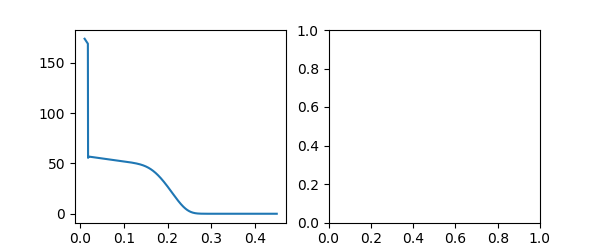

In [804]:
x = np.linspace(0,3,100)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2.5))


y = free_energy_exact(Tfit, 180, 58)


ax1.plot(Tfit, y)

In [ ]:
run_id = 733
data = DataSetDict(run_id=run_id)
ret_phi = dict(data.get_grid('detector_signal_phase'))

pg = ret_phi["ivvi_setup_R1_voltage"]["values"]
phi = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,0,1]
phi_ref = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,0,0]

fig, (ax1) = plt.subplots(1,1, figsize=(3,2.5))

im1 = ax1.plot(pg*1e3,(phi-phi_ref).T%360)
ax1.set_ylabel('phase (deg)')
ax1.set_xlabel('G (mV)')


fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

pg.size

# e

In [284]:
qc.config['core']['db_location'] = r"d:/OneDrive/BF1/Data/experiments_20181011.db"

<IPython.core.display.Javascript object>


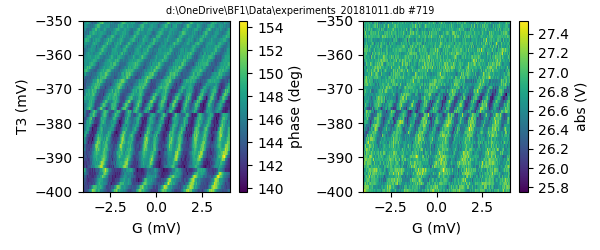

In [315]:
run_id = 719
data = DataSetDict(run_id=run_id)

ret_mag = dict(data.get_grid('detector_signal_abs'))
ret_real = dict(data.get_grid('detector_signal_real'))
ret_imag = dict(data.get_grid('detector_signal_imag'))
ret_phi = dict(data.get_grid('detector_signal_phase'))

t3 = ret_mag["ivvi_setup_T3_voltage"]["values"]
pg = ret_mag["ivvi_setup_G_fine_voltage"]["values"]

mag = np.ma.getdata(ret_mag['detector_signal_abs']['values'])[:,:,0,1]
real = np.ma.getdata(ret_real['detector_signal_real']['values'])[:,:,0,1]
imag = np.ma.getdata(ret_imag['detector_signal_imag']['values'])[:,:,0,1]
phi = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0,1]
phi_ref = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0,0]

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2.5))

cphase =(phi-phi_ref).T%360

im1 = ax1.pcolor(pg*1e3, t3*1e3,  (phi-phi_ref).T%360)
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("T3 (mV)")
# ax1.set_ylim([-500, -350])
cb1.set_label('phase (deg)')
ax1.set_xlabel("G (mV)")

im2 = ax2.pcolor(pg*1e3, t3*1e3,  mag.T)
cb2 = fig.colorbar(im2, ax=ax2)
cb2.set_label('abs (V)')
ax2.set_xlabel("G (mV)")

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()





<IPython.core.display.Javascript object>


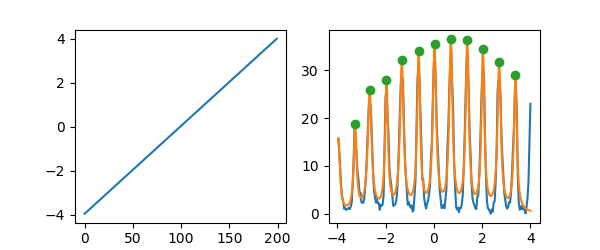

[array([ 0.60493843,  0.69249531,  0.63677729,  0.69249531,  0.66065644,
        0.67657588,  0.67657588,  0.65269673,  0.67657588,  0.66861616])]


In [311]:
x = pg*1e3
y = t3
z = (cphase-300)%360
z = z[:,:]
i = 100

D = []
X = []

xt = x[1:]
zt = z[i,:][1:]-min(z[i,:][1:])

xfit = np.linspace(min(xt), max(xt), 1001)

maxtab, mintab = peakdet(zt, 2, xt)
xp = array(maxtab)[:,0]
yp = array(maxtab)[:,1]
# xp = np.append(xp, x[-1])
# yp = np.append(yp, y[-1])

guess = []
bound_min = []
bound_max = []
for i in range(len(xp)):
    guess += [xp[i], 0.1, 0.1] 
    bound_min += [min(x), 0, 0] 
    bound_max += [max(x), 10, 2] 
try:
    popt, pcov = curve_fit(fitfunc, xt, zt, p0=guess, bounds=(bound_min, bound_max))
except:
    popt, pcov = curve_fit(fitfunc, xt, zt, p0=guess2, bounds=(bound_min, bound_max))

fit = fitfunc(xfit, *popt)
guess2 = popt

maxtab, mintab = peakdet(fit, 1.5, xfit)
xp = array(maxtab)[1::,0]
yp = array(maxtab)[1::,1]




D.append(xp)
X.append(np.diff(xp))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2.5))

ax1.plot(xt)

ax2.plot(xt, zt)
ax2.plot(xfit, fit)
ax2.plot(xp, yp, 'o')
ax2.set_xlabel('G (mV)')

# ax1.plot(pg*1e3,cphase[:,0])

# fig.suptitle(ds_title(str(run_id)), size='x-small')
# fig.tight_layout()
print(X)

In [310]:
i = 0
x = pg*1e3
y = t3
z = (cphase-300)%360
z = z[:,:]

D = []
X = []

for i in range(len(y)):
    xt = x[1:]
    zt = z[i,:][1:]-min(z[i,:][1:])

    xfit = np.linspace(min(xt), max(xt), 1001)

    maxtab, mintab = peakdet(zt, 2, xt)
    xp = array(maxtab)[:,0]
    yp = array(maxtab)[:,1]
    # xp = np.append(xp, x[-1])
    # yp = np.append(yp, y[-1])

    guess = []
    bound_min = []
    bound_max = []
    for i in range(len(xp)):
        guess += [xp[i], 0.1, 0.1] 
        bound_min += [min(x), 0, 0] 
        bound_max += [max(x), 10, 2] 
    try:
        popt, pcov = curve_fit(fitfunc, xt, zt, p0=guess, bounds=(bound_min, bound_max))
    except:
        popt, pcov = curve_fit(fitfunc, xt, zt, p0=guess2, bounds=(bound_min, bound_max))

    fit = fitfunc(xfit, *popt)
    guess2 = popt

    maxtab, mintab = peakdet(fit, 1.5, xfit)
    xp = array(maxtab)[1:-1,0]
    yp = array(maxtab)[1:-1,1]

    D.append(xp)
    X.append(np.diff(xp))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2.5))

ax1.plot(xt)

ax2.plot(xt, zt)
ax2.plot(xfit, fit)
ax2.plot(xp, yp, 'o')
ax2.set_xlabel('G (mV)')

# ax1.plot(pg*1e3,cphase[:,0])

# fig.suptitle(ds_title(str(run_id)), size='x-small')
# fig.tight_layout()

IndexError: too many indices for array

In [304]:
ec = []
gap = []

for i in range(len(X)):
    if X[i][0]>X[i][1]:
        e = X[i][0::2]
        o = X[i][1::2]
    else:
        e = X[i][1::2]
        o = X[i][0::2]


    ec.append((o[0:min(len(o),len(e))]+e[0:min(len(o),len(e))])*1e3/4/0.9)
    gap.append(abs(o[0:min(len(o),len(e))]-e[0:min(len(o),len(e))])*1e3/4/0.9)

print(gap)
# ec = np.concatenate(ec)
# gap = np.concatenate(gap)
E = []
delta = []    
for i in range(len(X)):
    E.append(np.average(ec[i]))
    delta.append(np.average(gap[i]))
    
E = np.array(E)
delta = np.array(delta)

IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2.5))
ax1.plot(t3*1e3,delta, '.')
# ax1.plot(delta, '.')
ax1.set_ylabel(r'$\Delta$ ($\mu$eV)')
ax1.set_xlabel("T3 (mV)")
ax2.plot(t3*1e3,E, '.')
ax2.set_ylabel(r'Ec,n +Ec,sc ($\mu$eV)')
ax2.set_xlabel("T3 (mV)")
fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()

<IPython.core.display.Javascript object>


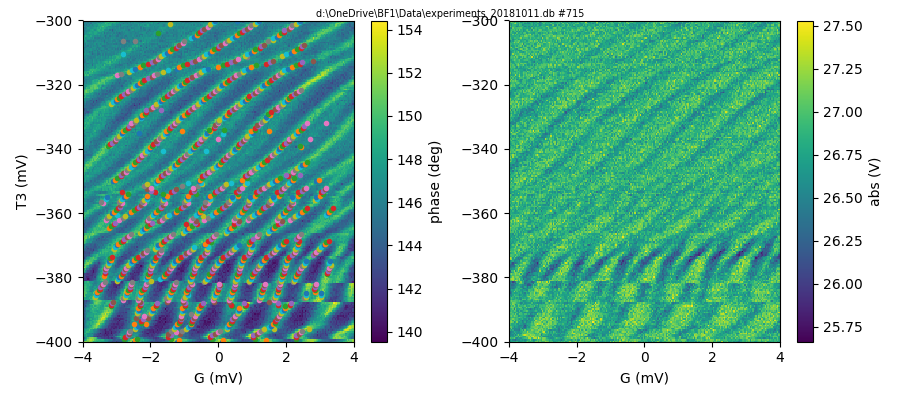

In [306]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(9,4))

cphase =(phi-phi_ref).T%360

im1 = ax1.pcolor(pg*1e3, t3*1e3,  (phi-phi_ref).T%360)
cb1 = fig.colorbar(im1, ax=ax1)
ax1.set_ylabel("T3 (mV)")
cb1.set_label('phase (deg)')
ax1.set_xlabel("G (mV)")

for i in range(len(D)):
    ax1.plot(D[i], t3[i]*1e3*np.ones(len(D[i])),'.')

im2 = ax2.pcolor(pg*1e3, t3*1e3,  mag.T)
cb2 = fig.colorbar(im2, ax=ax2)
cb2.set_label('abs (V)')
ax2.set_xlabel("G (mV)")

fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()


# Charge stability diagrams

In [460]:
import scipy.ndimage

<IPython.core.display.Javascript object>


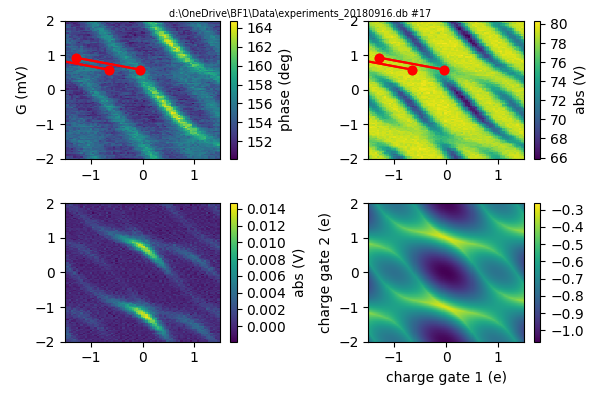

In [564]:
run_id = 13
data   = DataSetDict(run_id=run_id)
ret    = dict(data.get_grid('ivvi_setup_SD_conductance'))
g      = ret['ivvi_setup_SD_conductance']['values']
g      = -1*g

run_id = 17
data   = DataSetDict(run_id=run_id)

ret_mag = dict(data.get_grid('detector_signal_abs'))
ret_phi = dict(data.get_grid('detector_signal_phase'))

pg = ret_mag["ivvi_setup_G_fine_voltage"]["values"]*1e3
r2 = ret_mag["ivvi_setup_R2_voltage"]["values"]*1e3

mag = np.ma.getdata(ret_mag['detector_signal_abs']['values'])[:,:,0,1]
phi = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0,1]
phi_ref = np.ma.getdata(ret_phi['detector_signal_phase']['values'])[:,:,0,0]

cphase = (phi-phi_ref).T%360

npzfile  = np.load('Emut50_deltai_0p3_1e_0p1_2e_2.npz')
edata = npzfile['edata']
wdata = npzfile['wdata']
charges = np.linspace(-2,2, 201)

# -- Extract the line...
# Make a line with "num" points...

y = pg
x = r2

dng_n = 0.647
dng_s = 0.173

fig, ((ax11, ax12),(ax13, ax23)) = plt.subplots(2,2, figsize=(6,4))

im11 = ax11.pcolor(r2/dng_n + 0, pg/dng_s - 3.8,  (phi-phi_ref).T%360)
cb11 = fig.colorbar(im11, ax=ax11)
ax11.set_ylabel("G (mV)")
ax11.set_xlim([-1.5, 1.5])
ax11.set_ylim([-2, 2])
cb11.set_label('phase (deg)')

im12 = ax12.pcolor(r2/dng_n + 0, pg/dng_s - 3.8,  mag.T)
cb12 = fig.colorbar(im12, ax=ax12)
cb12.set_label('abs (V)')
ax12.set_xlim([-1.5, 1.5])
ax12.set_ylim([-2,2])

im13 = ax13.pcolor(r2/dng_n + 0, pg/dng_s - 3.8,  g.T)
cb13 = fig.colorbar(im13, ax=ax13)
cb13.set_label('abs (V)')
ax13.set_xlim([-1.5, 1.5])
ax13.set_ylim([-2,2])

im23 = ax23.pcolormesh(charges,charges, edata[:,:,0].transpose())
ax23.set_xlabel(r'charge gate 1 (e)')
ax23.set_ylabel(r'charge gate 2 (e)')
ax23.set_xlim([-1.5, 1.5])
fig.colorbar(im23, ax=ax23)





fig.suptitle(ds_title(str(run_id)), size='x-small')
fig.tight_layout()



In [561]:
qc.config['core']['db_location'] = r"d:/OneDrive/BF1/Data/experiments_20180916.db"

37.625

C:\Users\Administrator\Anaconda3\envs\qcodes\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


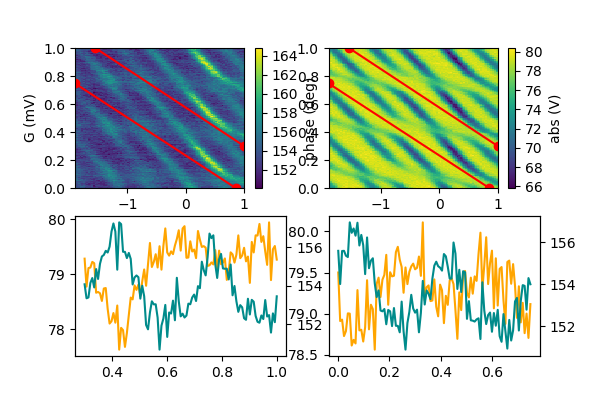

In [576]:


cphase = (phi-phi_ref).T%360
fig, ((ax11, ax12),(ax21, ax22)) = plt.subplots(2,2, figsize=(6,4))

im11 = ax11.pcolor(r2,pg,  (phi-phi_ref).T%360)
cb11 = fig.colorbar(im11, ax=ax11)
ax11.set_ylabel("G (mV)")

cb11.set_label('phase (deg)')

im12 = ax12.pcolor(r2,pg,  mag.T)
cb12 = fig.colorbar(im12, ax=ax12)
cb12.set_label('abs (V)')




yof = 0
xof = 0

xstart, ystart = -1.55,1
xend, yend     = 1, 0.3

x0, y0 = np.argmin(abs(x-xstart)), np.argmin(abs(y-ystart)) # These are in _pixel_ coordinates!!
x1, y1 = np.argmin(abs(x-xend)), np.argmin(abs(y-yend))
num = 101
xc, yc = np.linspace(x0, x1, num), np.linspace(y0, y1, num)
yv = np.linspace(ystart, yend, num)

pi = scipy.ndimage.map_coordinates(cphase, np.vstack((yc, xc)))
mi = scipy.ndimage.map_coordinates(mag.T, np.vstack((yc, xc)))

ax11.plot([x[x0], x[x1]], [y[y0], y[y1]], 'ro-')
ax12.plot([x[x0], x[x1]], [y[y0], y[y1]], 'ro-')
axp = ax21.twinx()
axp.plot(yv, pi, 'darkcyan')
ax21.plot(yv, mi, 'orange')

#------------------------------------------------------------------------------------
yof = 0

xstart, ystart = -1.9,0.75
xend, yend     = 0.85,0

x0, y0 = np.argmin(abs(x-xstart)), np.argmin(abs(y-ystart)) # These are in _pixel_ coordinates!!
x1, y1 = np.argmin(abs(x-xend)), np.argmin(abs(y-yend))
num = 101
xc, yc = np.linspace(x0, x1, num), np.linspace(y0, y1, num)
yv = np.linspace(ystart, yend, num)

pi = scipy.ndimage.map_coordinates(cphase, np.vstack((yc, xc)))
mi = scipy.ndimage.map_coordinates(mag.T, np.vstack((yc, xc)))

ax11.plot([x[x0], x[x1]], [y[y0], y[y1]], 'ro-')
ax12.plot([x[x0], x[x1]], [y[y0], y[y1]], 'ro-')
axp = ax22.twinx()
axp.plot(yv, pi, 'darkcyan')
ax22.plot(yv, mi, 'orange')

In [484]:
x

array([  3.05180438e-04,   6.40878920e-03,   1.31227588e-02,
         1.98367285e-02,   2.65506981e-02,   3.32646677e-02,
         3.99786374e-02,   4.66926070e-02,   5.34065766e-02,
         6.01205463e-02,   6.68345159e-02,   7.35484855e-02,
         8.02624552e-02,   8.63660639e-02,   9.30800336e-02,
         9.97940032e-02,   1.06507973e-01,   1.13221942e-01,
         1.19935912e-01,   1.26649882e-01,   1.33363851e-01,
         1.40077821e-01,   1.46791791e-01,   1.53505760e-01,
         1.60219730e-01,   1.66933700e-01,   1.73037308e-01,
         1.79751278e-01,   1.86465248e-01,   1.93179217e-01,
         1.99893187e-01,   2.06607156e-01,   2.13321126e-01,
         2.20035096e-01,   2.26749065e-01,   2.33463035e-01,
         2.40177005e-01,   2.46890974e-01,   2.53604944e-01,
         2.59708553e-01,   2.66422522e-01,   2.73136492e-01,
         2.79850462e-01,   2.86564431e-01,   2.93278401e-01,
         2.99992370e-01,   3.06706340e-01,   3.13420310e-01,
         3.20134279e-01,